### Note

Cell output has been cleared if containing data related to individual accounts

# Identifying the core of the communities

In [1]:
# read in graph

import networkit as nk

edge_list_file = '../../data/aus_to_aus/edge_list_index.csv'

graph = nk.readGraph(edge_list_file, fileformat=nk.Format.EdgeList, separator=",", 
                     firstNode=0, continuous=True, directed=True)

In [2]:
# read communities

communities = nk.community.readCommunities('../../data/aus_to_aus/modularity_2_0_PLM.csv')

read communities from: ../../data/aus_to_aus/modularity_2_0_PLM.csv


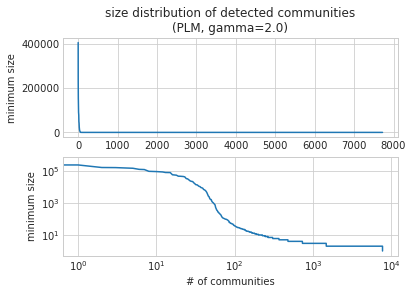

In [6]:
# inspect community sizes

import matplotlib.pyplot as plt

sizes = communities.subsetSizes()
sizes.sort(reverse=True)

ax1 = plt.subplot(2,1,1)
ax1.set_ylabel("minimum size")
ax1.plot(sizes)
ax1.set_title("size distribution of detected communities\n(PLM, gamma=2.0)")

ax2 = plt.subplot(2,1,2)
ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.set_ylabel("minimum size")
ax2.set_xlabel("# of communities")
ax2.plot(sizes)
plt.show()

In [7]:
# filtering for communities with > 1000 accounts

import pandas as pd

sizes = communities.subsetSizes()
pd_sizes = pd.DataFrame(sizes)

pd_sizes.columns = ['size']
pd_sizes.index.name = 'modularity_class'
pd_sizes.sort_values('size', ascending=False, inplace=True)

communities_1000 = pd_sizes[pd_sizes['size'] > 1000]

find most influential users based on k-core based on finding in

Kitsak, M., Gallos, L. K., Havlin, S., Liljeros, F., Muchnik, L., Stanley, H. E., & Makse, H. A. (2010).
Identification of influential spreaders in complex networks. Nature Physics, 6(11), 888-893.
doi:http://dx.doi.org.ezp01.library.qut.edu.au/10.1038/nphys1746

that k-core/k-shell predicts influence in SIS and SIR models better than degree or in-betweenness.

In [ ]:
core_decompositions = {}

for row in communities_1000.iterrows():
    print(row)
    members = communities.getMembers(row[0])
    subgraph = graph.subgraphFromNodes(members)
    subgraph.removeSelfLoops()
    core_decompositions[row[0]] = nk.centrality.CoreDecomposition(subgraph)
    core_decompositions[row[0]].run()

/home/ubuntu/anaconda3/envs/community_detection_py35/lib/python3.5/site-packages/numpy/lib/arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


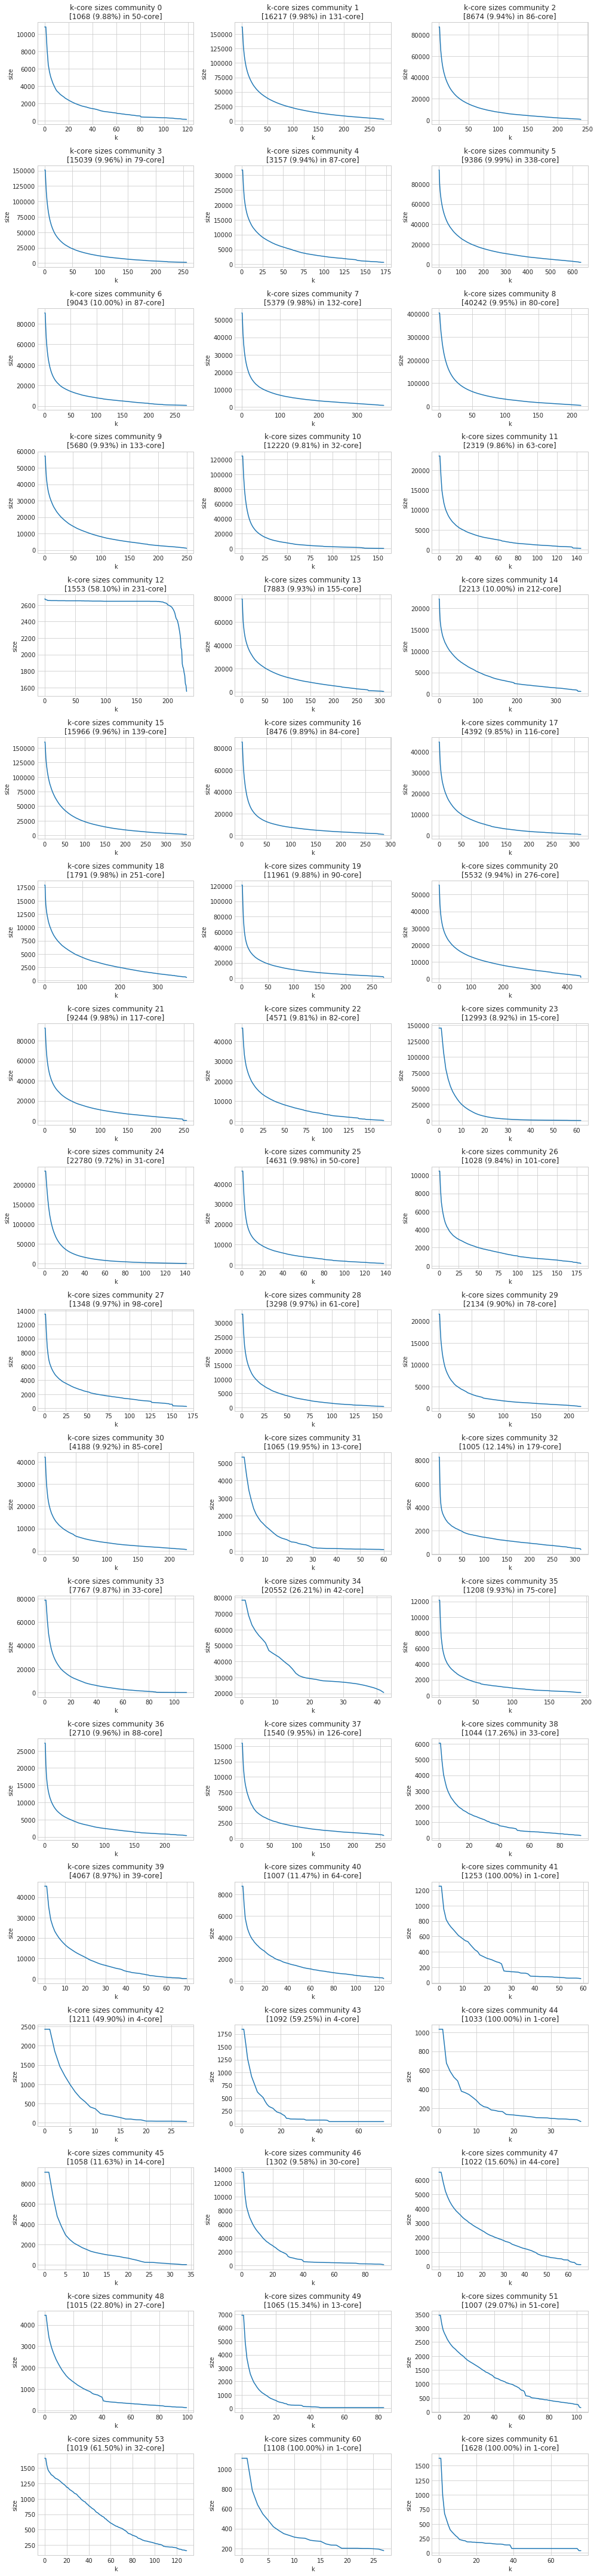

In [33]:
#  find user ids of k-cores with either 10% of the community or the smallest possible core with at least 1000 accounts

pd_accounts_index = pd.read_csv('../../data/aus_to_aus/accounts_index.csv', index_col='index')

all_tweets = {}

fig = plt.figure(figsize=(14,20*3))

j = 1

for i in core_decompositions.keys():
    cores = core_decompositions[i].getCover()
    max_k = core_decompositions[i].maxCoreNumber()
    core_sizes = cores.subsetSizeMap()

    x,y = zip(*sorted(core_sizes.items()))

    ax = fig.add_subplot(len(core_decompositions) / 3, 3, j)
    ax.plot(x,y)
    ax.set_xlabel('k')
    ax.set_ylabel('size')
    ax.set_aspect('auto')
    
    pd_core_sizes = pd.DataFrame.from_dict(core_sizes, orient='index')
    
    percent = 10
    fraction = percent * 1/100

    try:
        k = pd_core_sizes[pd_core_sizes[0] <= pd_core_sizes[0][0] * fraction].index[0] 
        # get k for which k-core contains percent % of the community
        # if under 1000 accounts find core with at least 1000
        if pd_core_sizes[0][k] < 1000:
            k = pd_core_sizes[pd_core_sizes[0] >= 1000].index[-1]
        actual_fraction = pd_core_sizes[0][k] / pd_core_sizes[0][0]
    except:
        k = max_k
        if pd_core_sizes[0][k] < 1000:
            k = pd_core_sizes[pd_core_sizes[0] >= 1000].index[-1]
        actual_fraction = pd_core_sizes[0][k] / pd_core_sizes[0][0]

    
    members = cores.getMembers(k)
    
    ax.set_title('k-core sizes community {i}\n[{members} ({percent:.2f}%) in {k}-core]'.format(
        i=i, percent=actual_fraction * 100, k=k, members=len(members)))
    
    core_user_ids = pd_accounts_index.loc[members]['user_id']
    
    core_user_ids.to_csv('../../data/aus_to_aus/community_cores_10_percent_PLM_2.0/{}.csv'.format(i),
                         index=False, header=False)
    
    j += 1

plt.tight_layout()
plt.show()

## remark

Some core size distributions differ significantly from the rest. This might point towards the bot network identified by Axel Bruns.

restarting kernel to free up memory

In [2]:

# read core users back into dataframe

from glob import glob
import pandas as pd
import re

filenames = glob('../../data/aus_to_aus/community_cores_10_percent_PLM_2.0/*.csv')

filenames = [file for file in filenames if re.search(r'/\d*.csv$', file)]

core_users = {}

for filename in filenames:
    community = int(re.match(r'.+/(.+).csv', filename).groups()[0])
    core_users[community] = pd.read_csv(filename, header=None)

In [ ]:
# get tweets of core users from TrISMA Google BigQuery database

all_tweets = {}

query = """
            SELECT
              from_user_id, text
            FROM
              [future-fellowship:q1_2017.tweets_australia_q1]
            WHERE
              from_user_id IN(
              {user_ids}
              )
              AND 
              LEFT(created_at, 9) == '2017-02-1'
            GROUP BY
              from_user_id, text
            """

for key in core_users.keys():
    
    user_ids = core_users[key][0].values.tolist()
    
    if len(user_ids) < 20000:
        
    
        user_ids="{}".format(user_ids).strip('[]')
    
        this_query = query.format(user_ids=user_ids)
    
        tweets = pd.read_gbq(this_query, "future-fellowship")
        
    else:
        
        user_ids_even = user_ids[::2]
        user_ids_odd = user_ids[1::2]
        
        user_ids="{}".format(user_ids_even).strip('[]')
        
        this_query = query.format(user_ids=user_ids)
        
        tweets = pd.read_gbq(this_query, "future-fellowship")
        
        user_ids="{}".format(user_ids_odd).strip('[]')
        
        this_query = query.format(user_ids=user_ids)
        
        tweets.append(pd.read_gbq(this_query, "future-fellowship"))
    
    try:
        print(key, tweets.sample(3))
    except:
        print(key, tweets)
    
    all_tweets[key] = tweets

In [9]:
# save to file for later use

for key in all_tweets.keys():
    all_tweets[key].to_pickle('../../data/aus_to_aus/community_cores_10_percent_PLM_2.0/tweets/2017021/{}.pickle'.format(key))

We will look at the tweets during the time period per user and treat this as one document.

In [ ]:
# merging tweets per user

merged_tweets = {}

for key in all_tweets.keys():
    merged_tweets[key] = all_tweets[key].groupby('from_user_id').agg(lambda x: ' '.join(x))
    
merged_tweets[0].head()

In [ ]:
pd.set_option('display.max_colwidth', 1000)
merged_tweets[0].head()

In [ ]:
for key in merged_tweets.keys():
    merged_tweets[key]['modularity_class'] = key

all_merged_tweets = pd.DataFrame()

for key in merged_tweets.keys():
    all_merged_tweets = all_merged_tweets.append(merged_tweets[key])
    
all_merged_tweets.head()

# Short analysis of user activity

In [61]:
import matplotlib.pyplot as plt

frequencies = pd.DataFrame(columns=['accounts',
                                    'active',
                                    'active accounts per account',
                                    'tweets',
                                    'tweets per user',
                                    'tweets per active user'],
                           index=[key for key in all_tweets.keys()])

for key in all_tweets.keys():
    frequencies['accounts'][key] = len(core_users[key])
    frequencies['active'][key] = len(merged_tweets[key])
    frequencies['active accounts per account'][key] = len(merged_tweets[key]) / len(core_users[key])
    frequencies['tweets'][key] = len(all_tweets[key])
    frequencies['tweets per user'][key] = len(all_tweets[key]) / len(core_users[key])
    frequencies['tweets per active user'][key] = len(all_tweets[key]) / len(merged_tweets[key])

frequencies.to_csv('../../data/aus_to_aus/community_cores_10_percent_PLM_2.0/tweets/2017021/frequencies.csv')

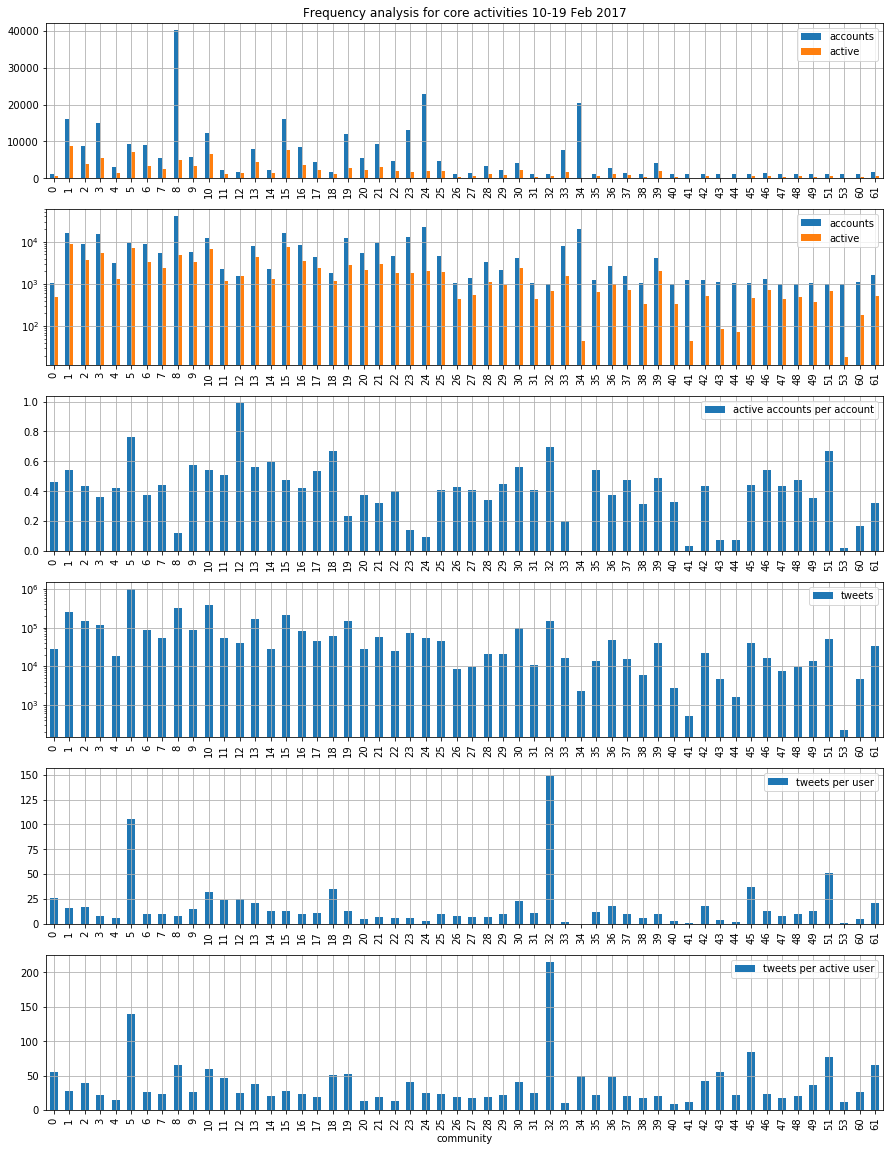

In [78]:
fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(15,20))


axes[0].set_title("Frequency analysis for core activities 10-19 Feb 2017")

frequencies[['accounts','active']].plot.bar(ax=axes[0], grid=True)

frequencies[['accounts','active']].plot.bar(ax=axes[1], grid=True)
axes[1].set_yscale('log')

frequencies[['active accounts per account']].plot.bar(ax=axes[2], grid=True)

frequencies[['tweets']].plot.bar(ax=axes[3], grid=True)
axes[3].set_yscale('log')

frequencies[['tweets per user']].plot.bar(ax=axes[4], grid=True)

frequencies[['tweets per active user']].plot.bar(ax=axes[5], grid=True)
axes[5].set_xlabel('community')

    
plt.grid(True)
plt.show()

In [90]:
tweets_per_user = {}

for key in all_tweets.keys():
    tweets_per_user[key] = all_tweets[key].groupby('from_user_id').count()

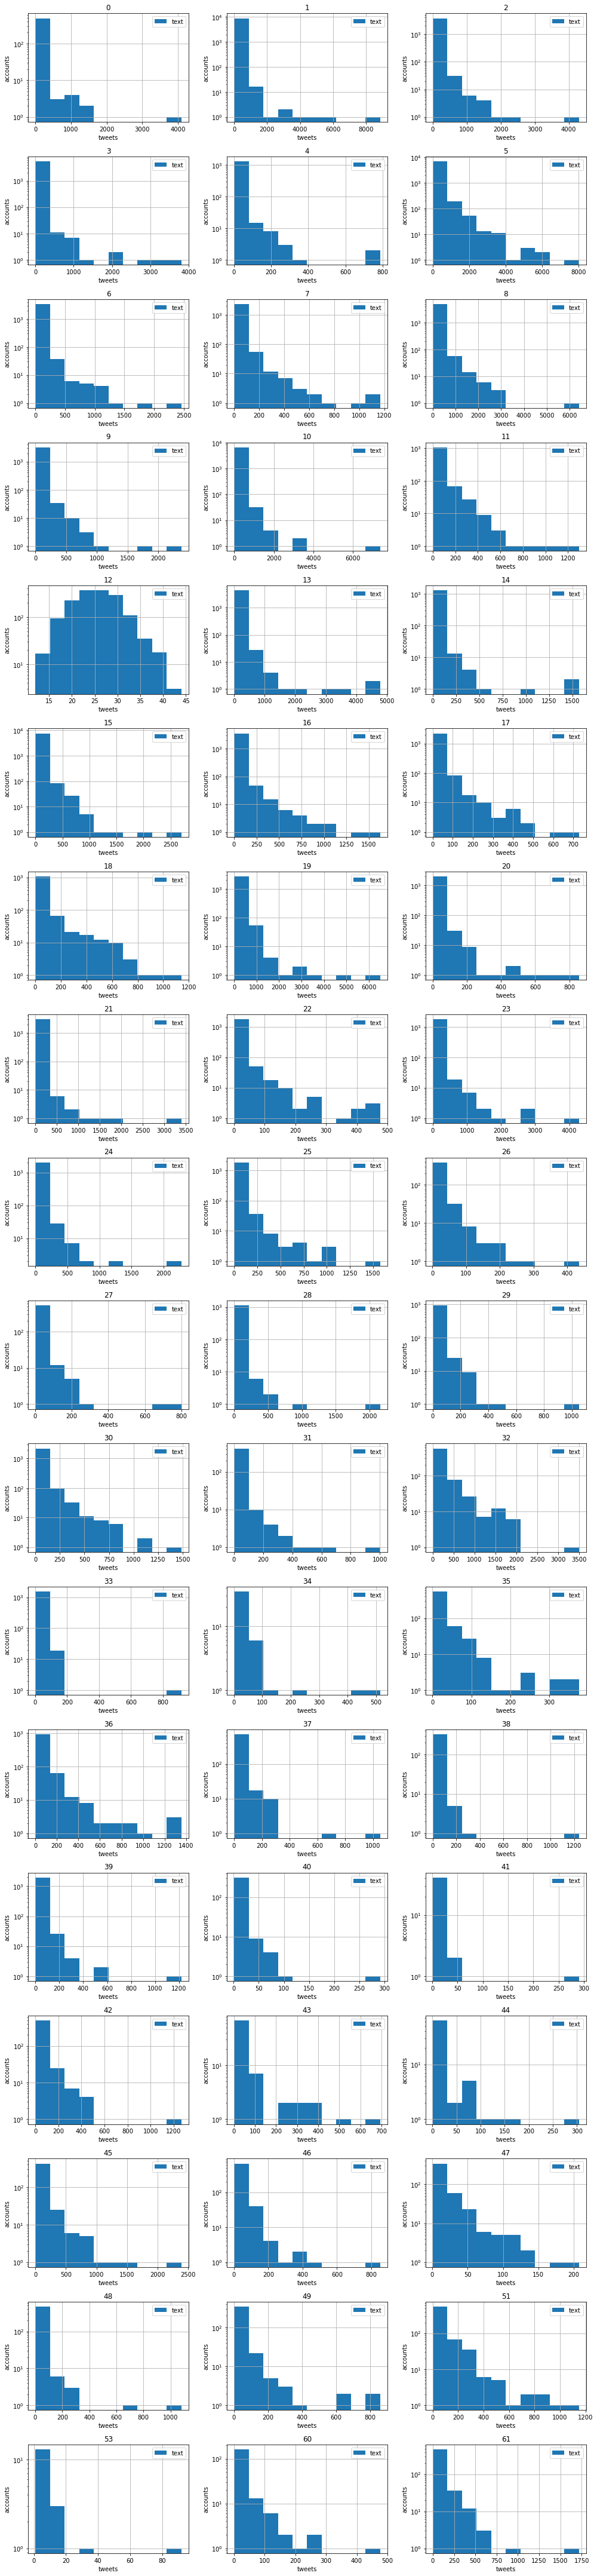

In [102]:
# get distributions of activity for active users

fig = plt.figure(figsize=(14,20*3))

j = 1

for key in all_tweets.keys():
    
    ax = fig.add_subplot(18, 3, j)
    tweets_per_user[key].plot.hist(ax=ax, grid=True, log=True)
    ax.set_aspect('auto')
    ax.set_title(key)
    ax.set_xlabel('tweets')
    ax.set_ylabel('accounts')
    
    j += 1


plt.tight_layout()                    
plt.show()

# Keyword extraction

In [ ]:

# remove links, &amp; and @-mentions

all_merged_tweets['text_cleaned'] = all_merged_tweets['text'].str.replace(
    r'http\S+', ' ').str.replace(
    r'@\S+', ' ').str.replace(
    r'&amp;', ' ')
all_merged_tweets.head()

In [82]:
all_merged_tweets.to_pickle('../../data/aus_to_aus/community_cores_10_percent_PLM_2.0/tweets/2017021/all_merged_tweets.pickle')

In [256]:
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
import numpy as np

my_additional_stop_words = ['rt', 'https', 'http', 'via', 'amp']

stop_words = ENGLISH_STOP_WORDS.union(my_additional_stop_words)

binary_vectorizer = CountVectorizer(stop_words=stop_words, binary=True)
binary_term_document_matrix = binary_vectorizer.fit_transform(all_merged_tweets['text_cleaned'].dropna())

binary_vocabulary = np.array(binary_vectorizer.get_feature_names())

In [270]:
from sklearn.feature_selection import chi2

import matplotlib.pyplot as plt

import seaborn as sns

def percent_not_null(series):
    count = 0
    for element in series:
        if element > 0:
            count +=1
    
    return count / len(series)

def my_len(series):
    return len(series)


def get_keywords(term_document_matrix, vocabulary, community_vector, figsize=(16,16), top=30, vmax=None,
                 annotate=False, treshold=0, test=False, verbose=False):

    keyword_table = pd.DataFrame(columns=["keywords"], index=community_vector)
    
    tdms = {}
    
    
    for community_number in community_vector:
        
        fig, axes = plt.subplots(nrows=1, ncols=2, gridspec_kw={'width_ratios': [1,5]}, figsize=figsize)
        i=0
        
        target = [-1 
                  if i != community_number
                  else community_number
                  for i in all_merged_tweets['modularity_class']]

        cluster_keyness, p = chi2(term_document_matrix, target)

        ranking = np.argsort(cluster_keyness)[::-1]
    
        top_keywords = vocabulary[ranking[:top]]
        top_keyness = cluster_keyness[ranking[:top]]
        top_p_values = p[ranking[:top]]    
    
        filtered_result = pd.DataFrame(term_document_matrix[:, ranking[:top]].toarray())
        filtered_result.columns = vocabulary[ranking[:top]]
        filtered_result.set_index(all_merged_tweets['modularity_class'], inplace=True)
        
        tdms[community_number] = filtered_result
        
        grouped = filtered_result.groupby('modularity_class')
        
        aggregated_result = grouped.agg(percent_not_null)
        counts = grouped.count()
        n = counts.loc[community_number][0]
        
        numeric_results = pd.DataFrame([top_keyness, top_p_values], columns=top_keywords, index=['keyness', 'p'])

        numeric_results = numeric_results.transpose()
    
        print("\n\nCOMMUNITY {}\n n = {}\n==================".format(community_number, n))
    

        numeric_results['fraction'] = aggregated_result.loc[community_number]
        
        if verbose:
            display(numeric_results)
    
        
        numeric_results[['fraction']].iloc[::-1].plot.barh(ax=axes[i], grid=True)
        axes[i].set_ylabel('top {} keywords by chi squared'.format(top))
        axes[i].set_xlabel('fraction')
        axes[i].set_title('account fraction using keyword in core {}'.format(community_number))
    
        i +=1
    
        sns.heatmap(aggregated_result.transpose(), cmap=plt.get_cmap('Blues'), vmax=vmax, annot=annotate,
                    ax=axes[i], linecolor='grey', linewidths=0.1)
        axes[i].set_title("Fraction of accounts in all community cores using the keyword")
        axes[i].set_ylabel('')
        axes[i].set_xlabel('community')
        axes[i].set_yticks([])
        
        keyword_table.loc[community_number,"keywords"] = ", ".join(
            numeric_results[numeric_results['fraction'] > treshold].index.tolist())
        
        plt.tight_layout()
        plt.show()
        
        if community_number >= 0 and test is True:
            break
        
        
    
    display(keyword_table)
    
    return keyword_table, tdms

In [111]:
community_vector = all_merged_tweets['modularity_class'].drop_duplicates()

community_vector = community_vector.astype(int)



COMMUNITY 0
 n = 496


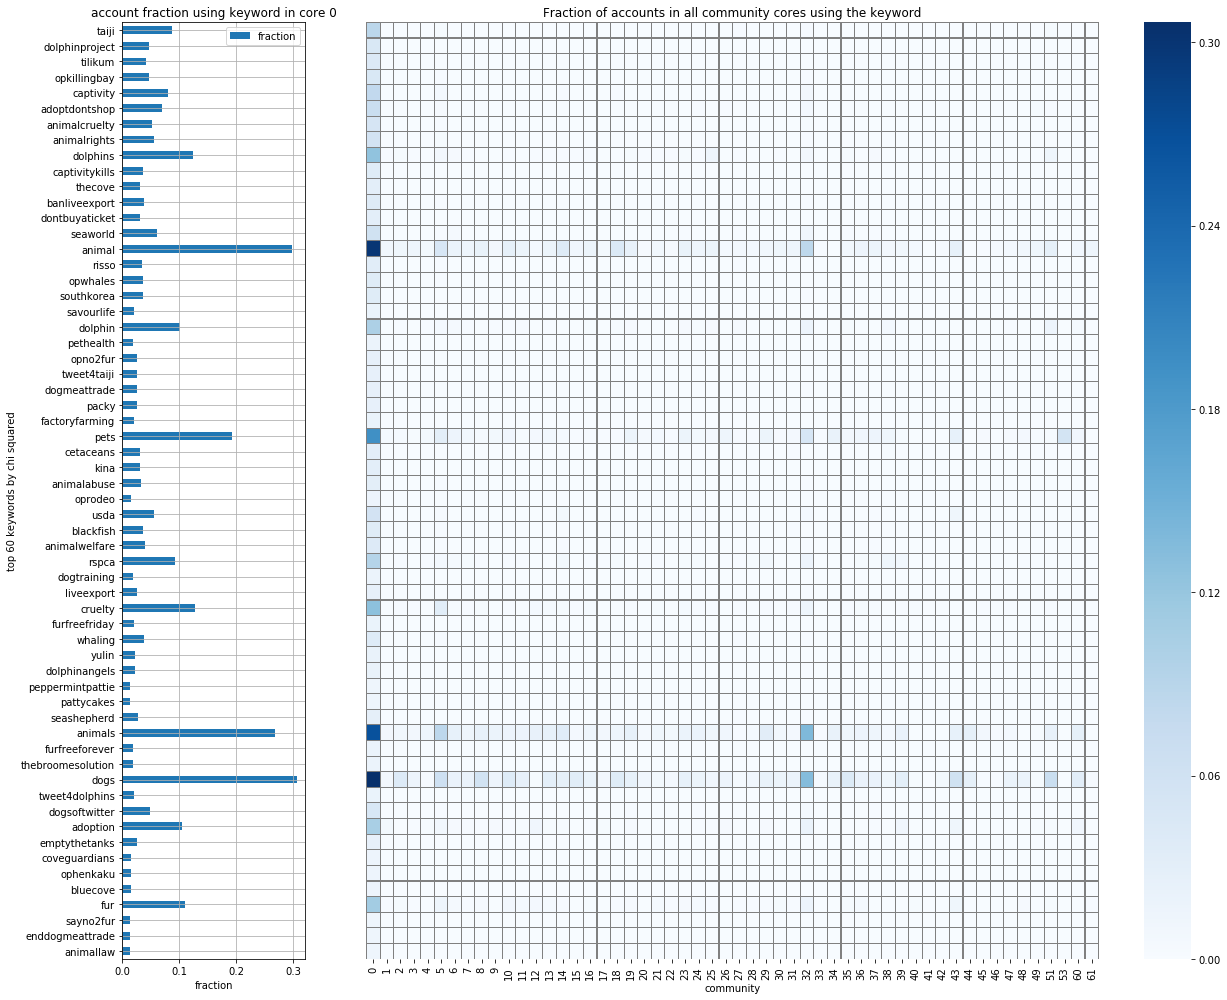



COMMUNITY 1
 n = 8808


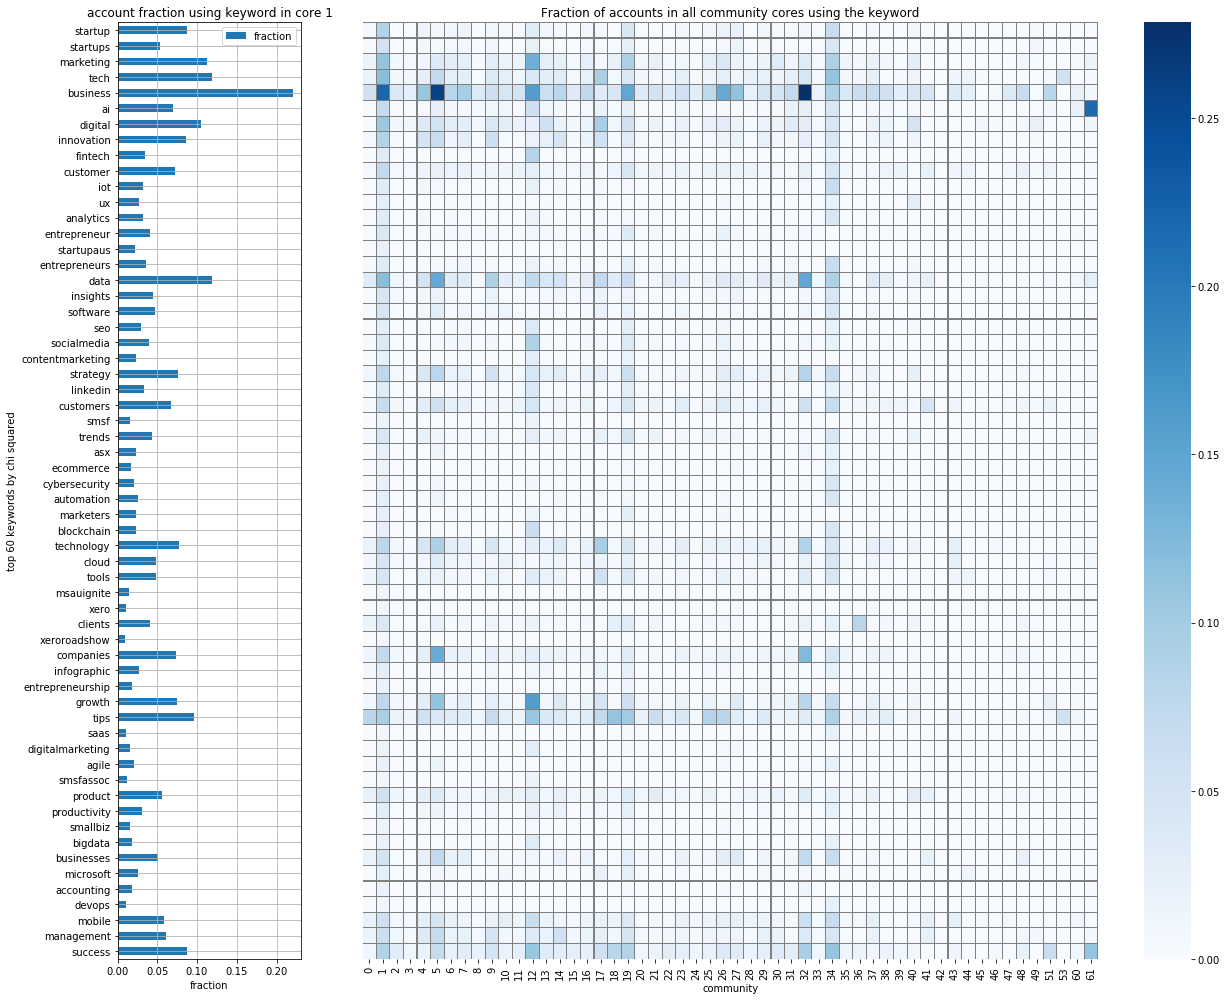



COMMUNITY 2
 n = 3766


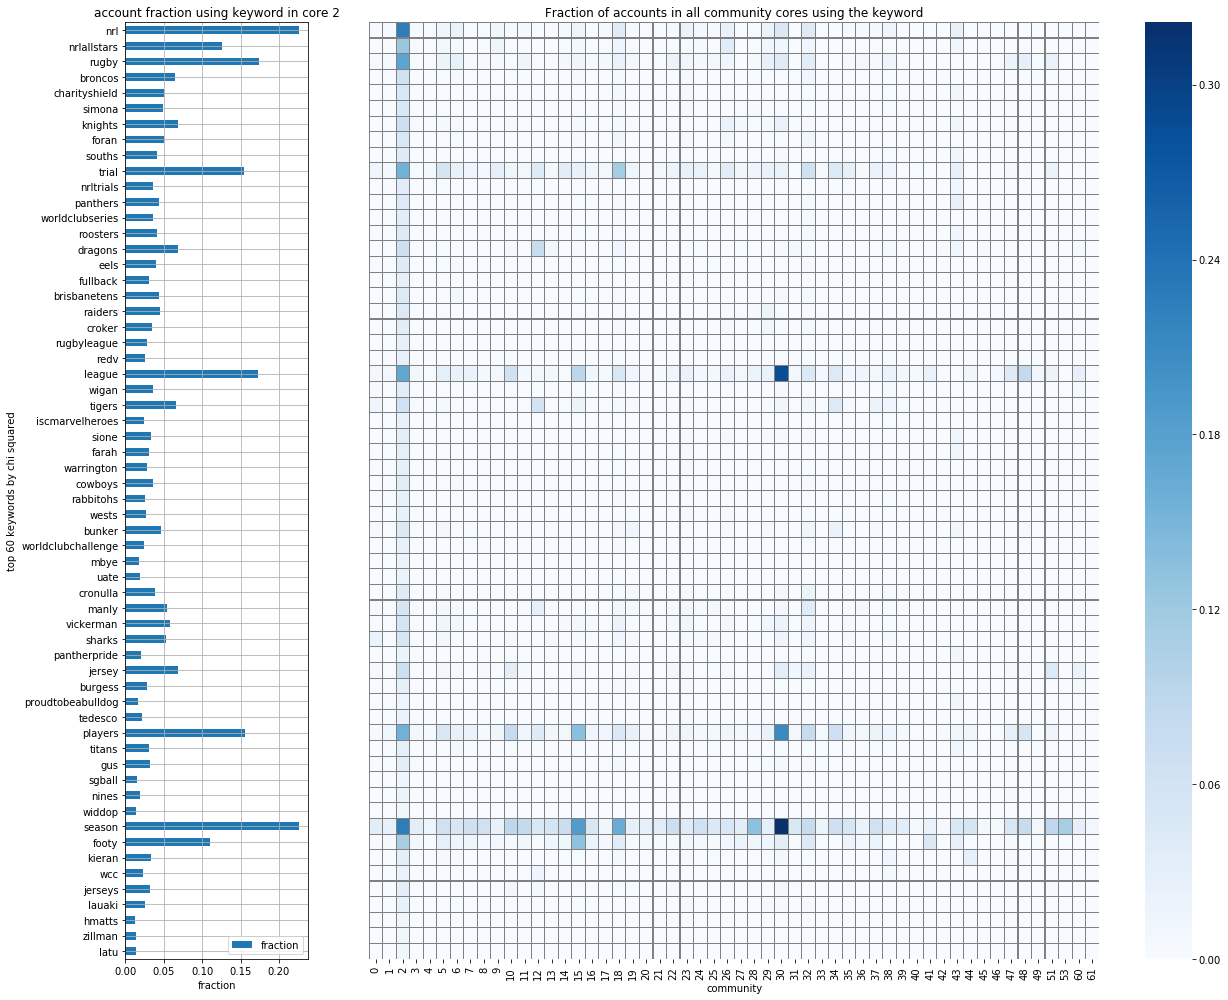



COMMUNITY 3
 n = 5447


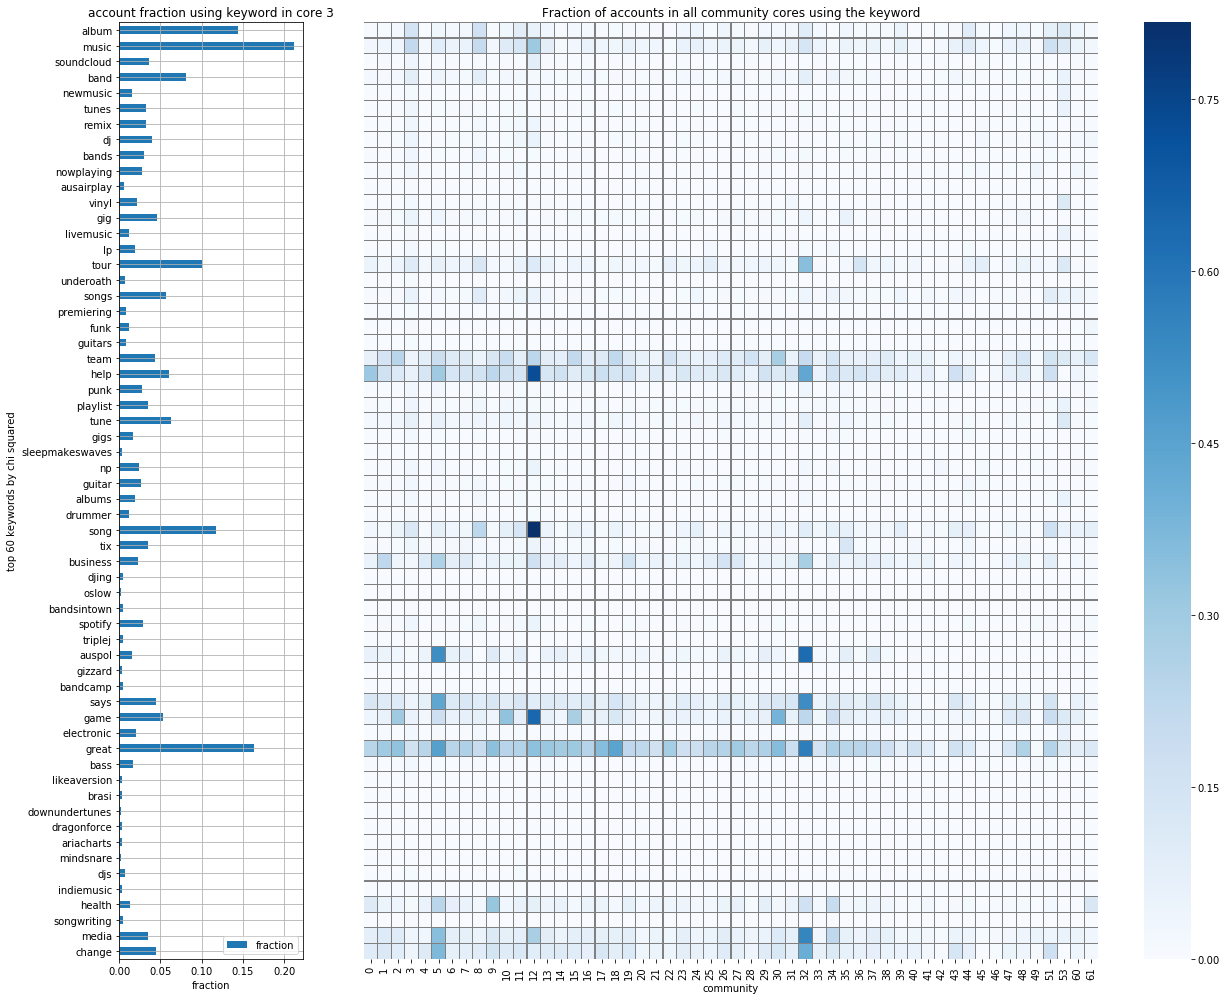



COMMUNITY 4
 n = 1338


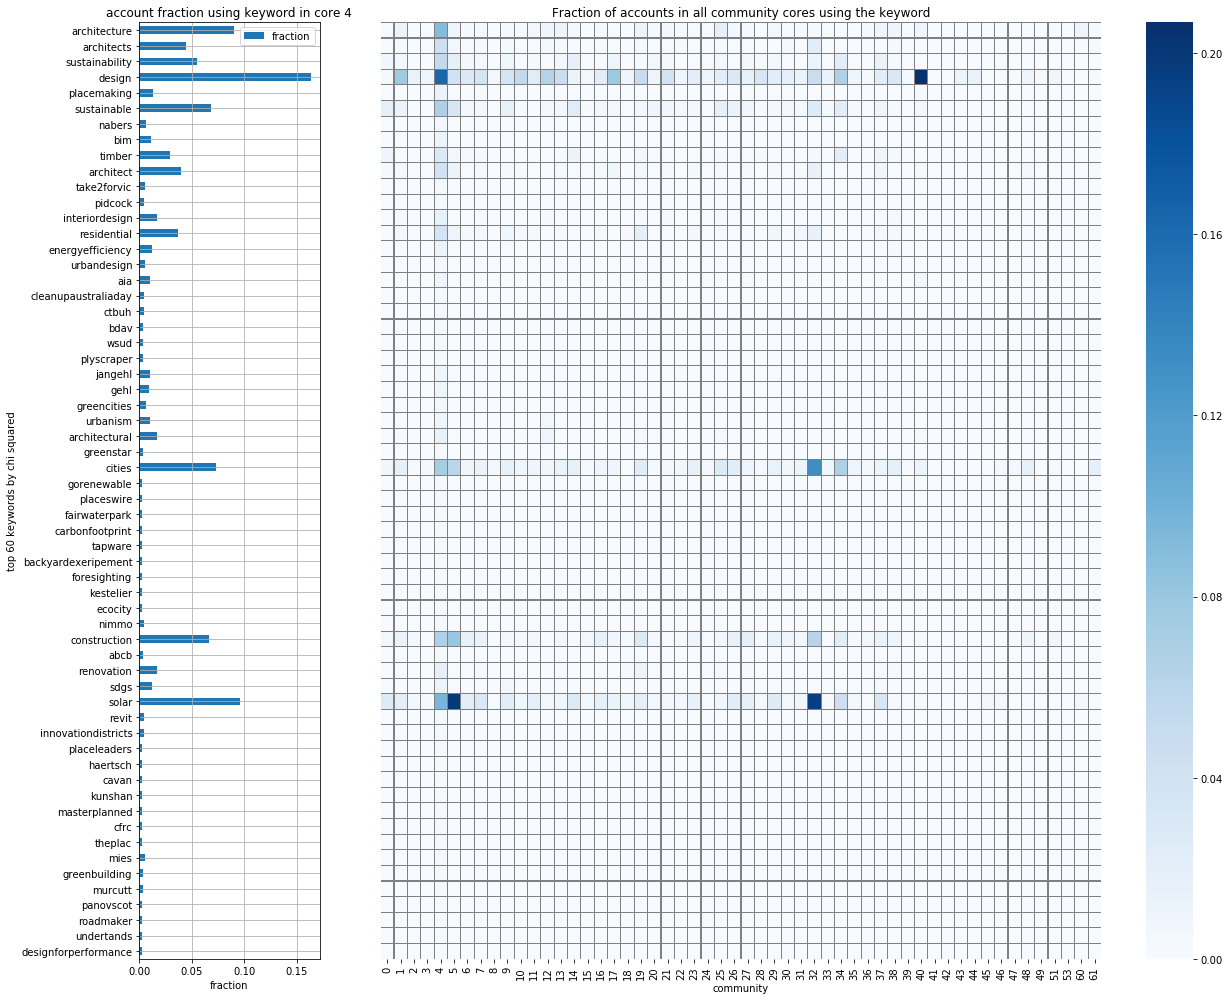



COMMUNITY 5
 n = 7139


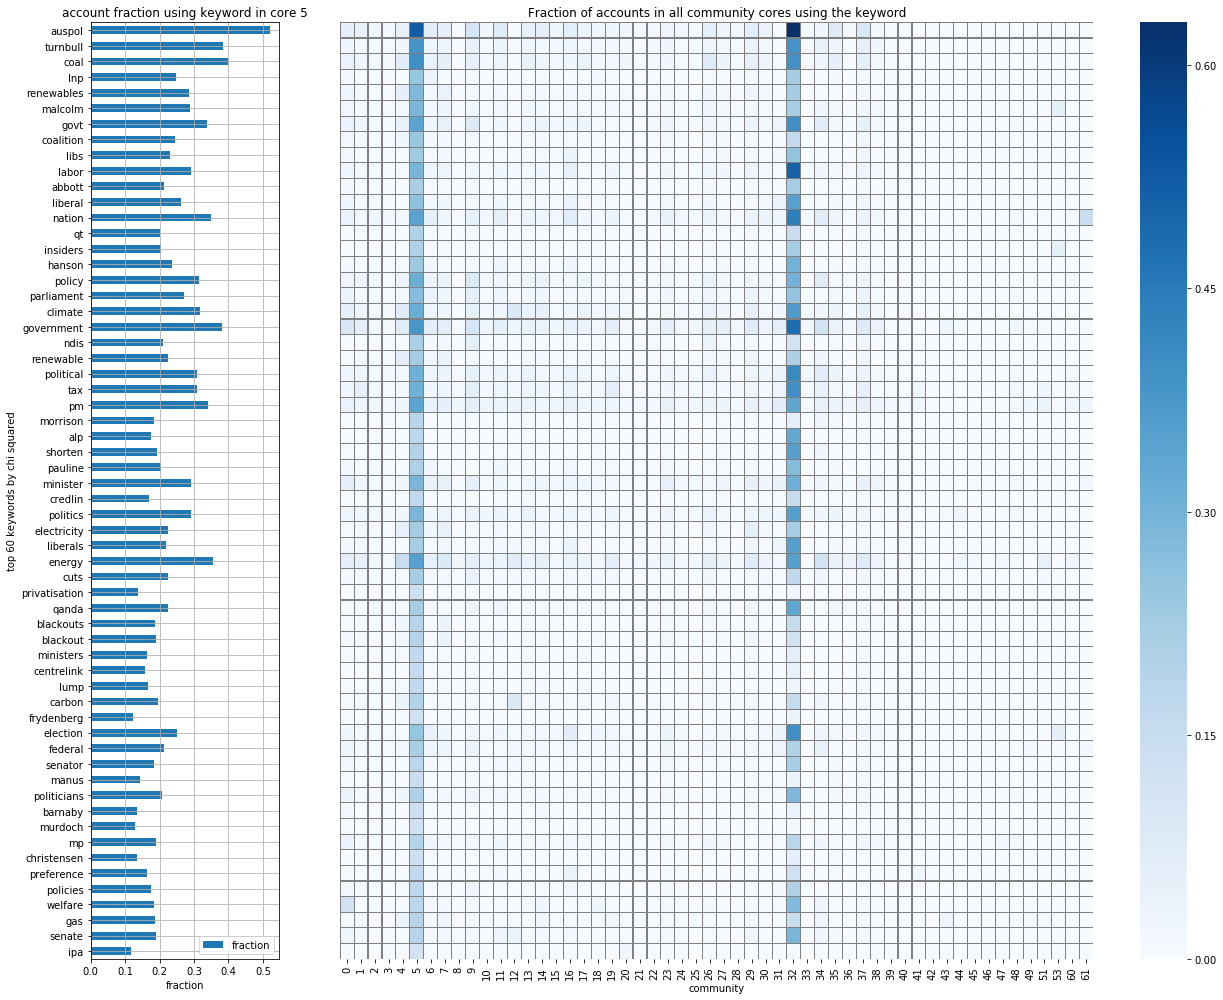



COMMUNITY 6
 n = 3393


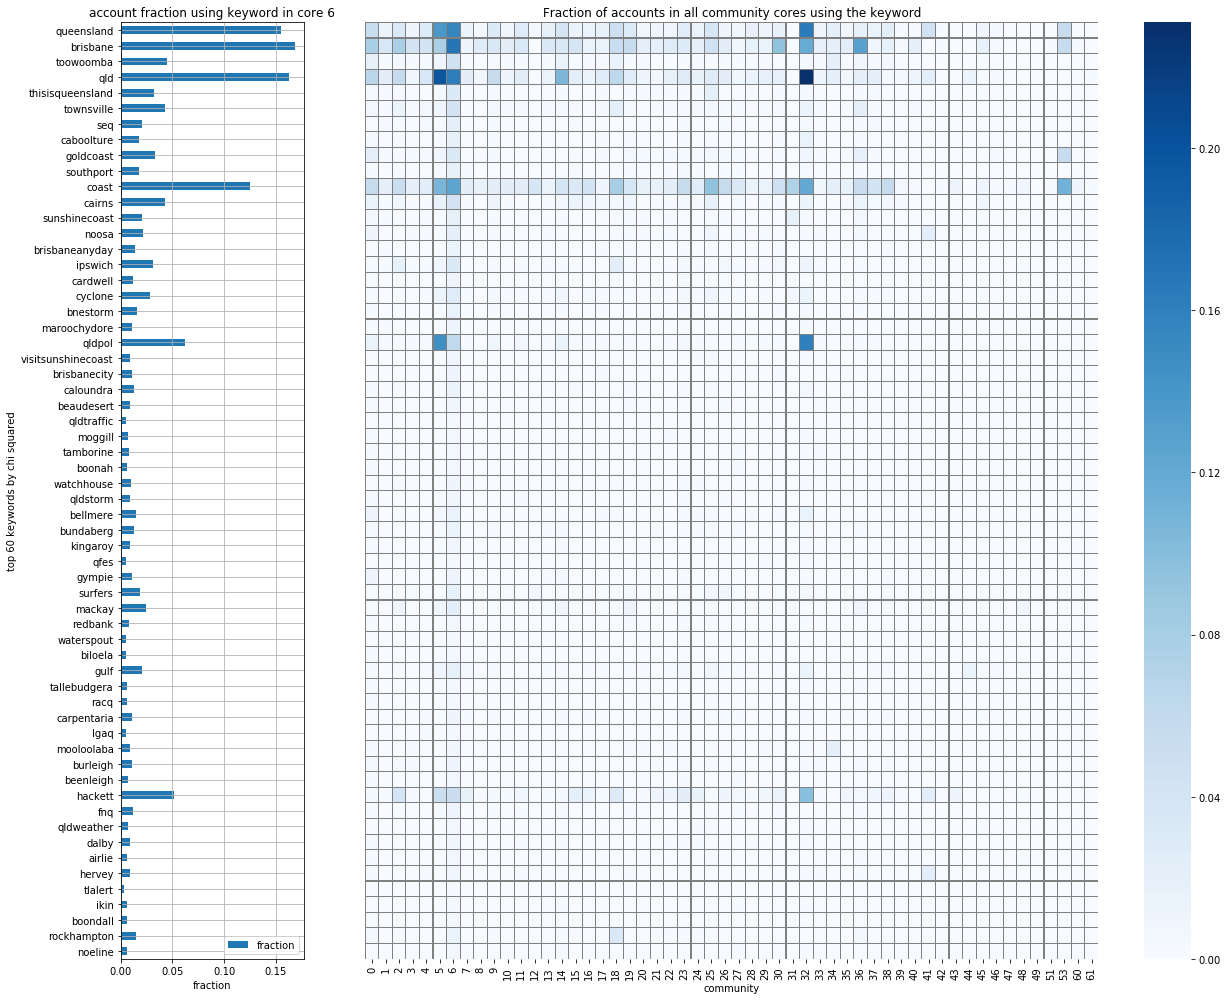



COMMUNITY 7
 n = 2388


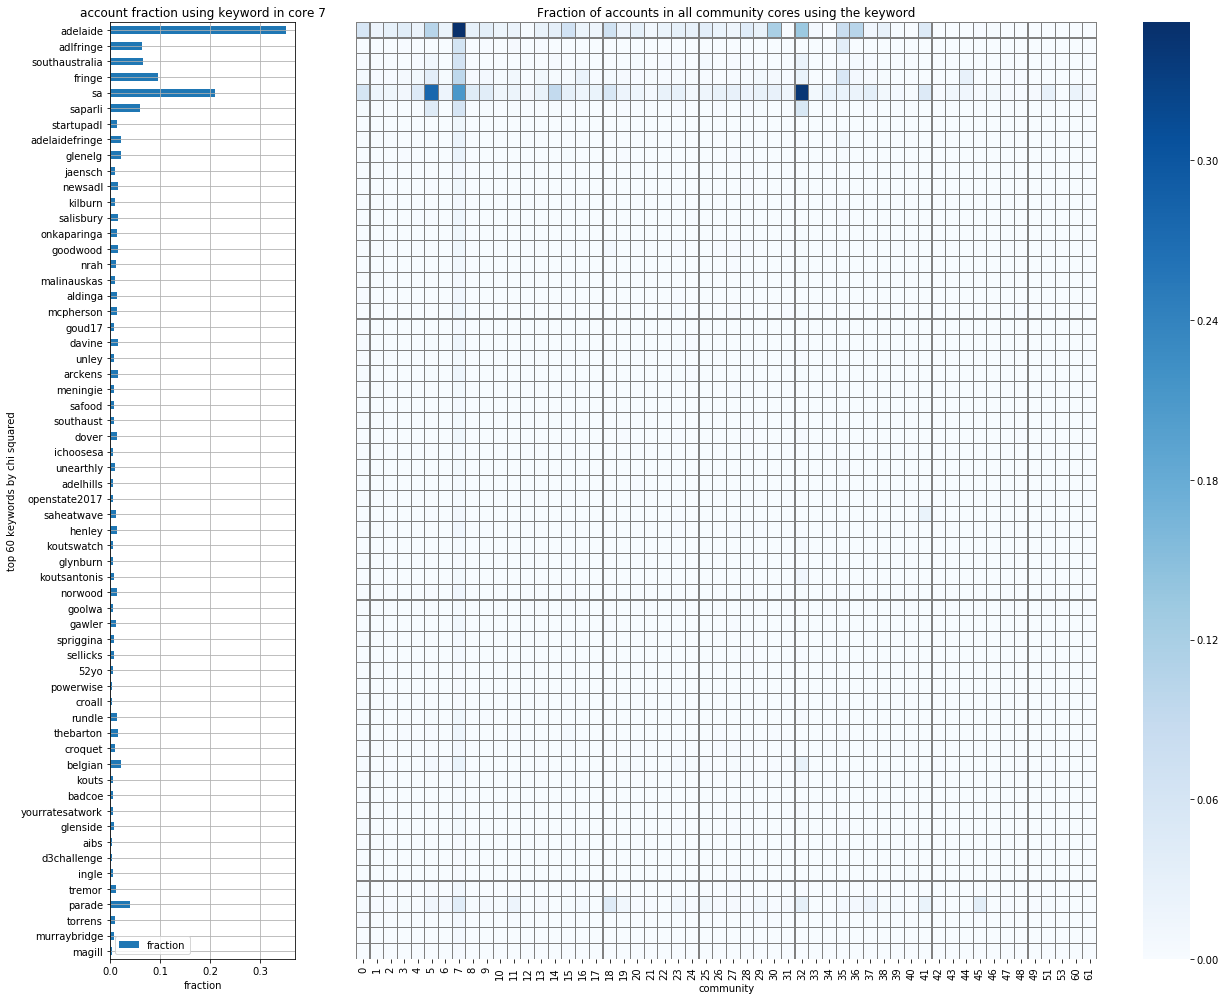



COMMUNITY 8
 n = 4899


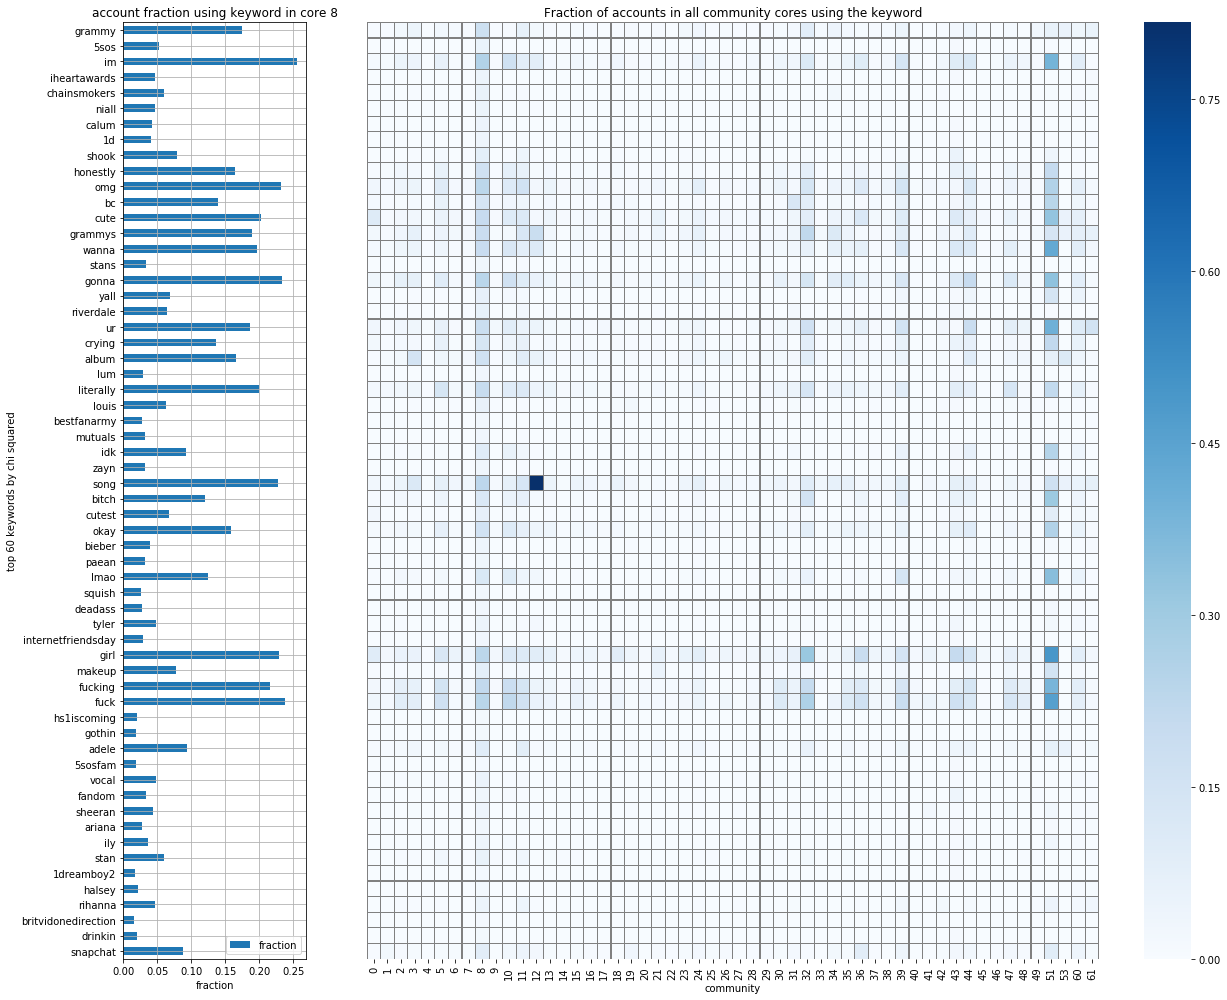



COMMUNITY 9
 n = 3268


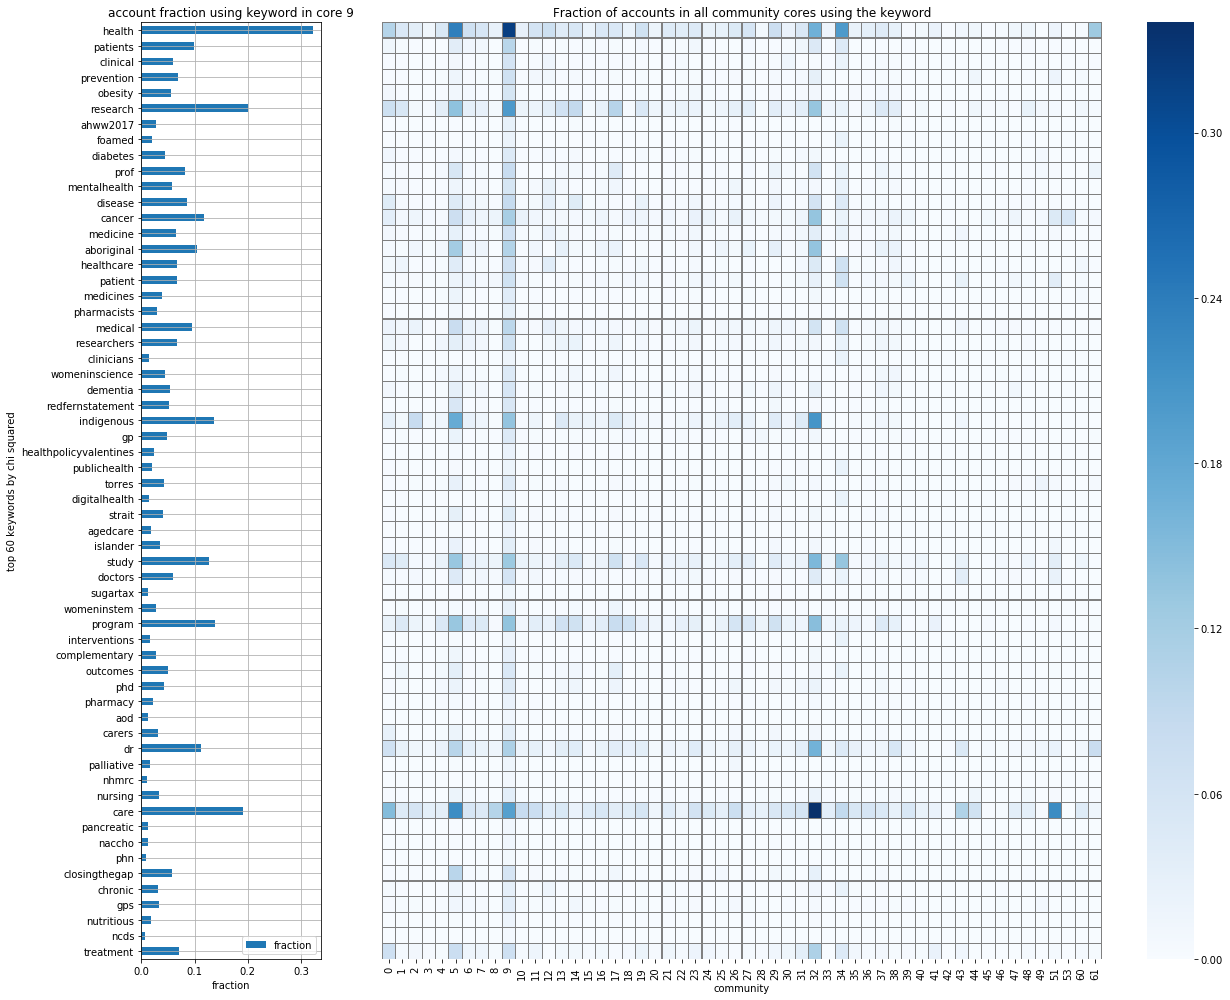



COMMUNITY 10
 n = 6632


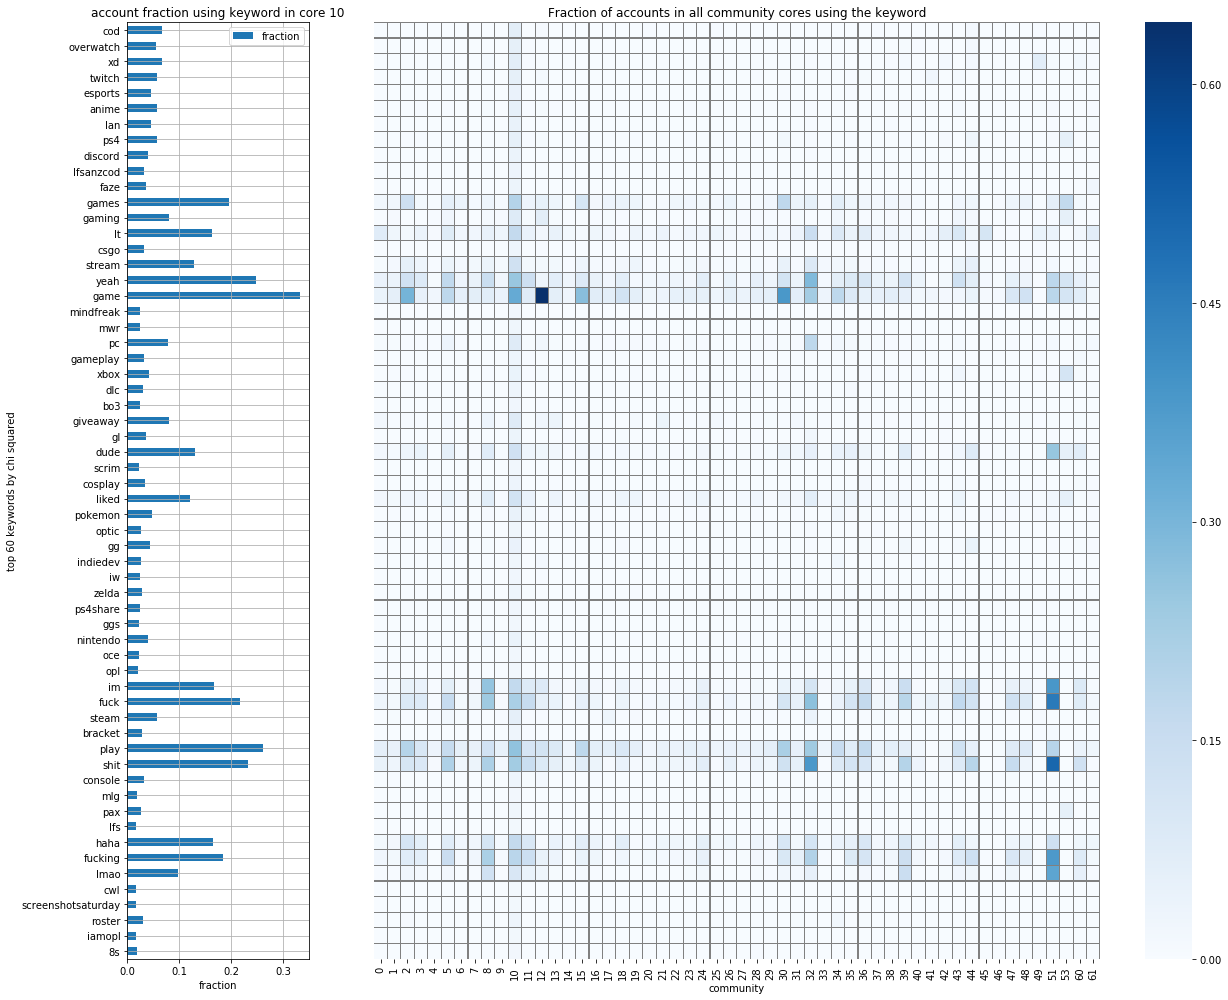



COMMUNITY 11
 n = 1172


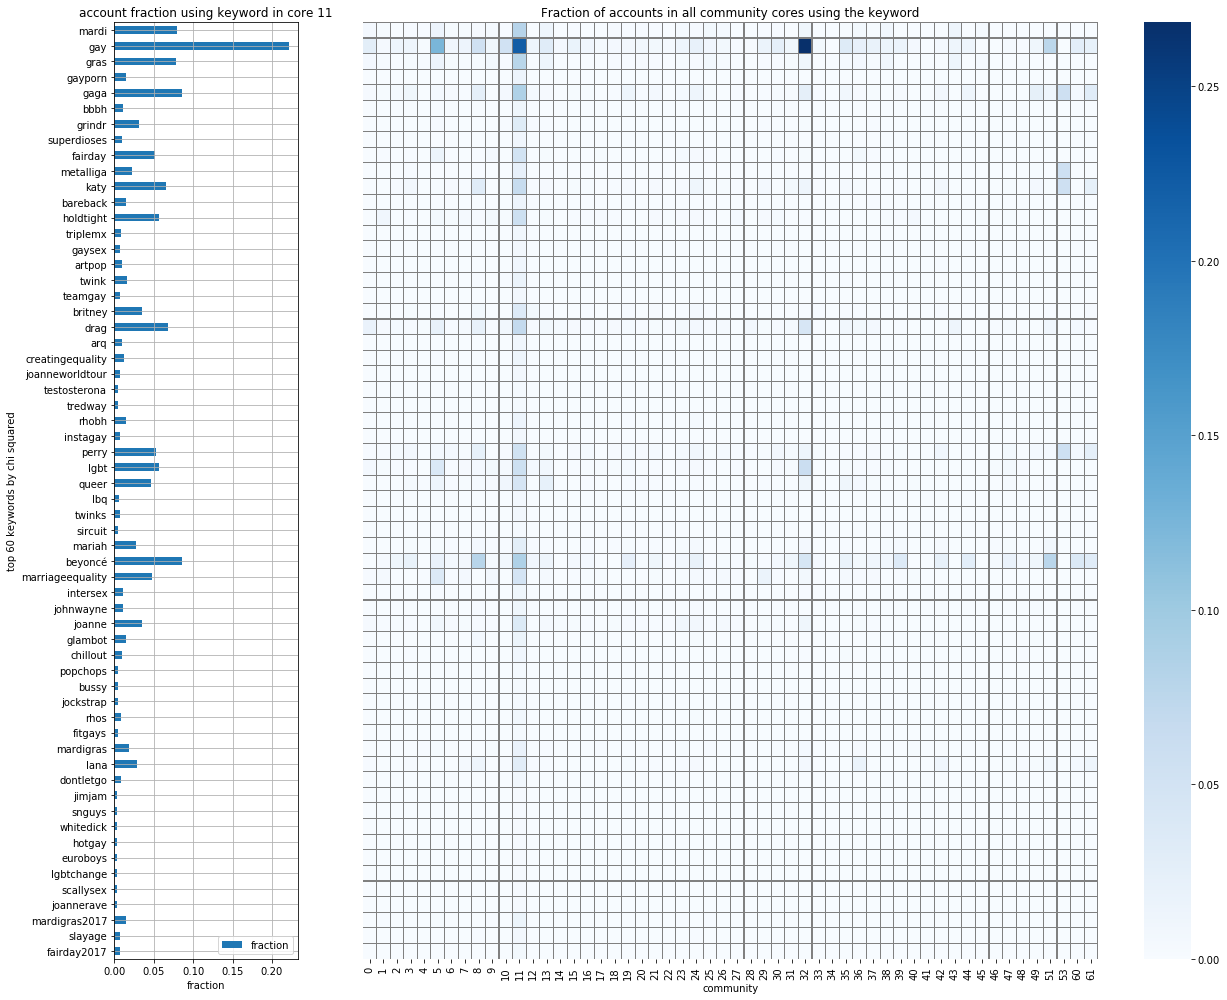



COMMUNITY 12
 n = 1538


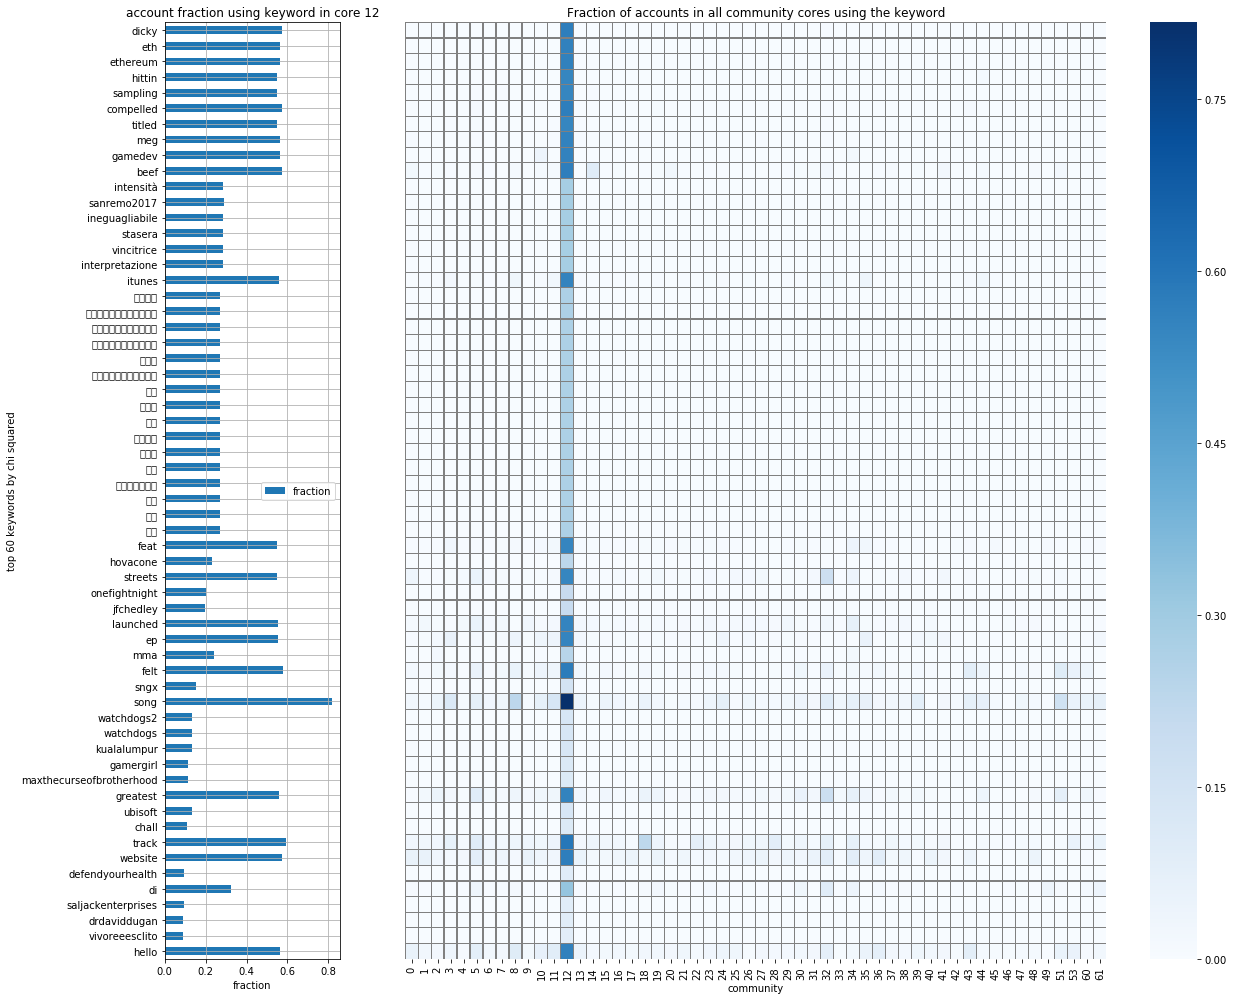



COMMUNITY 13
 n = 4451


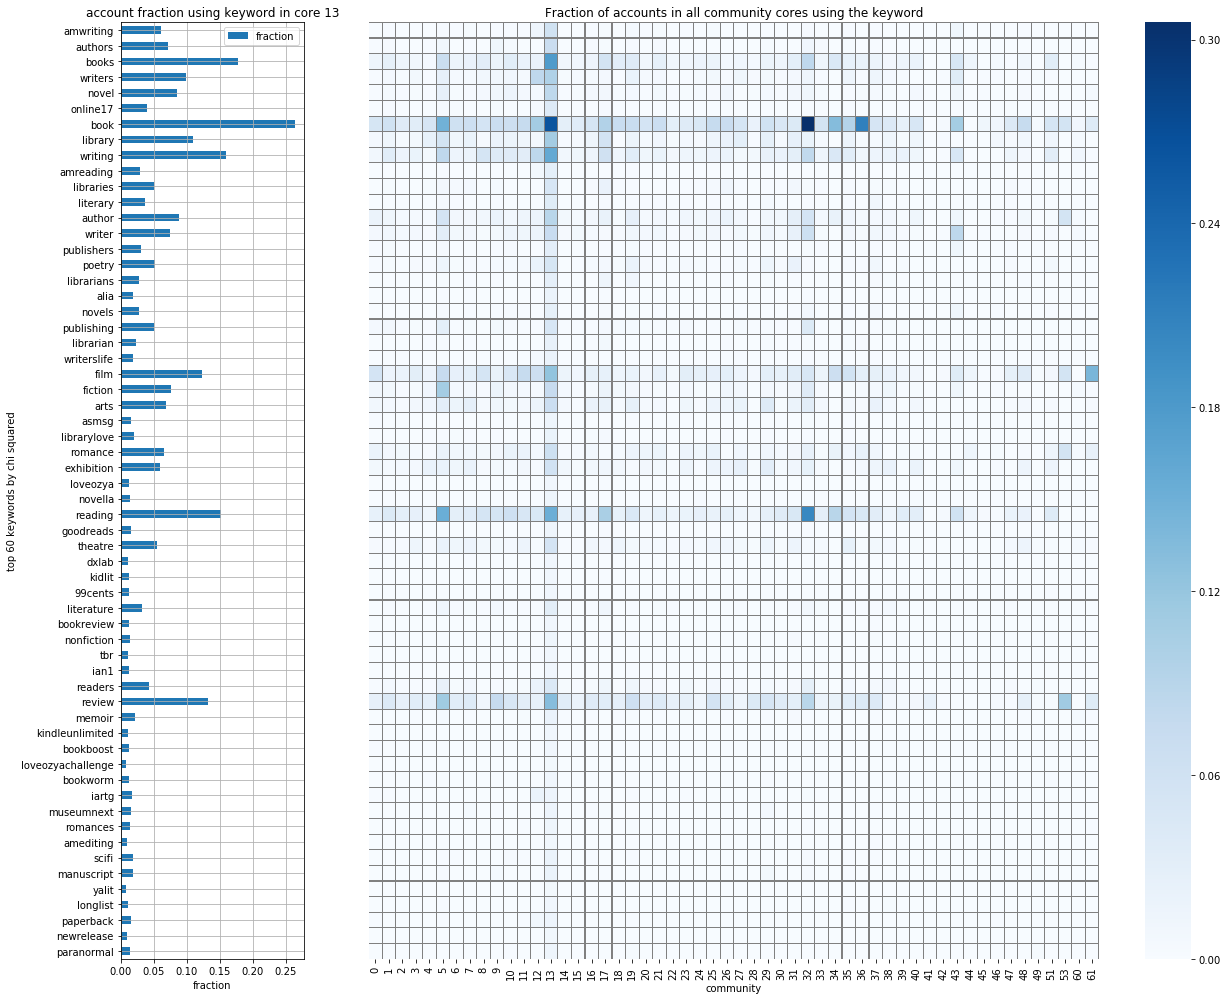



COMMUNITY 14
 n = 1316


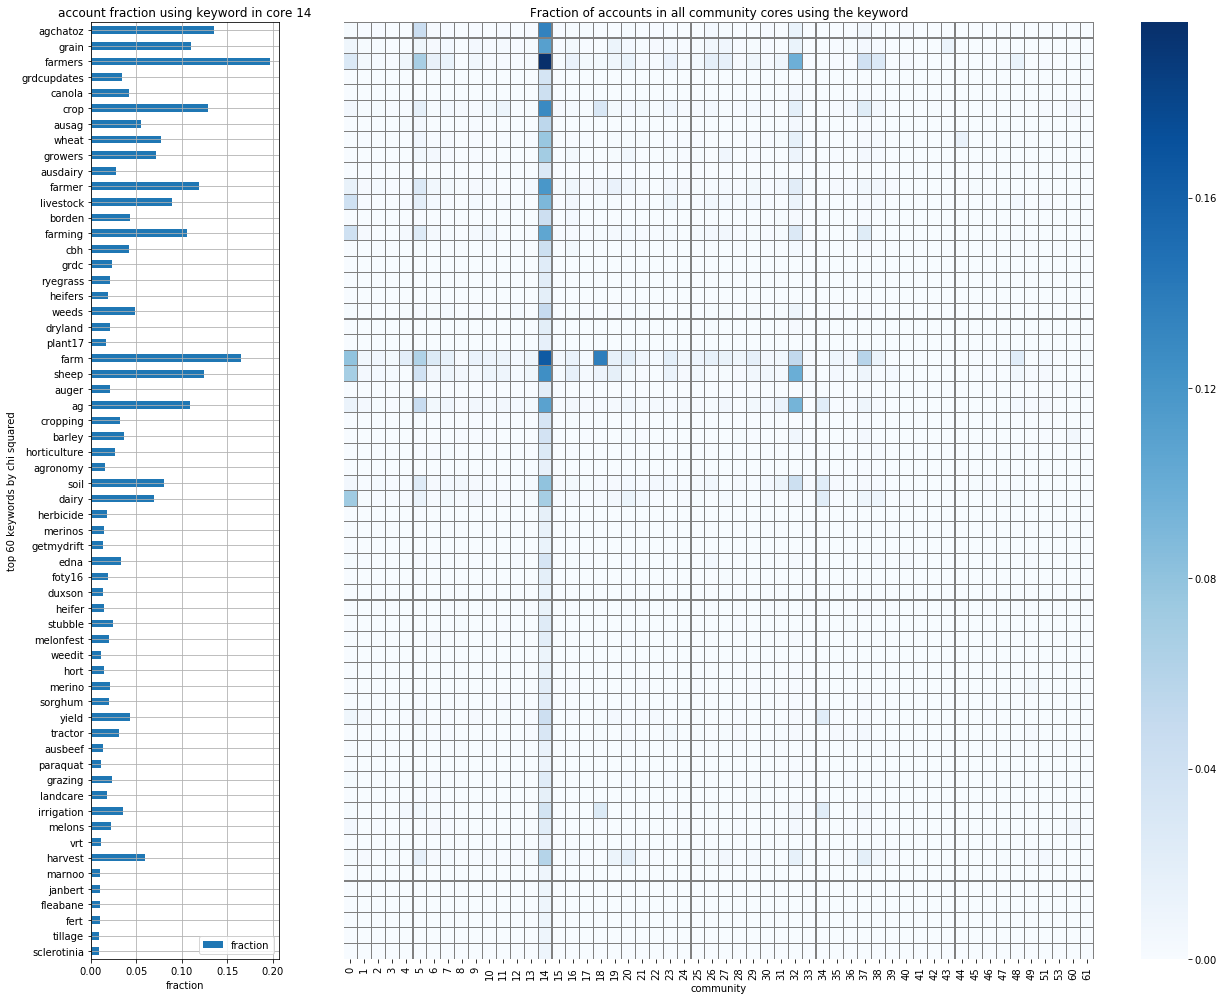



COMMUNITY 15
 n = 7633


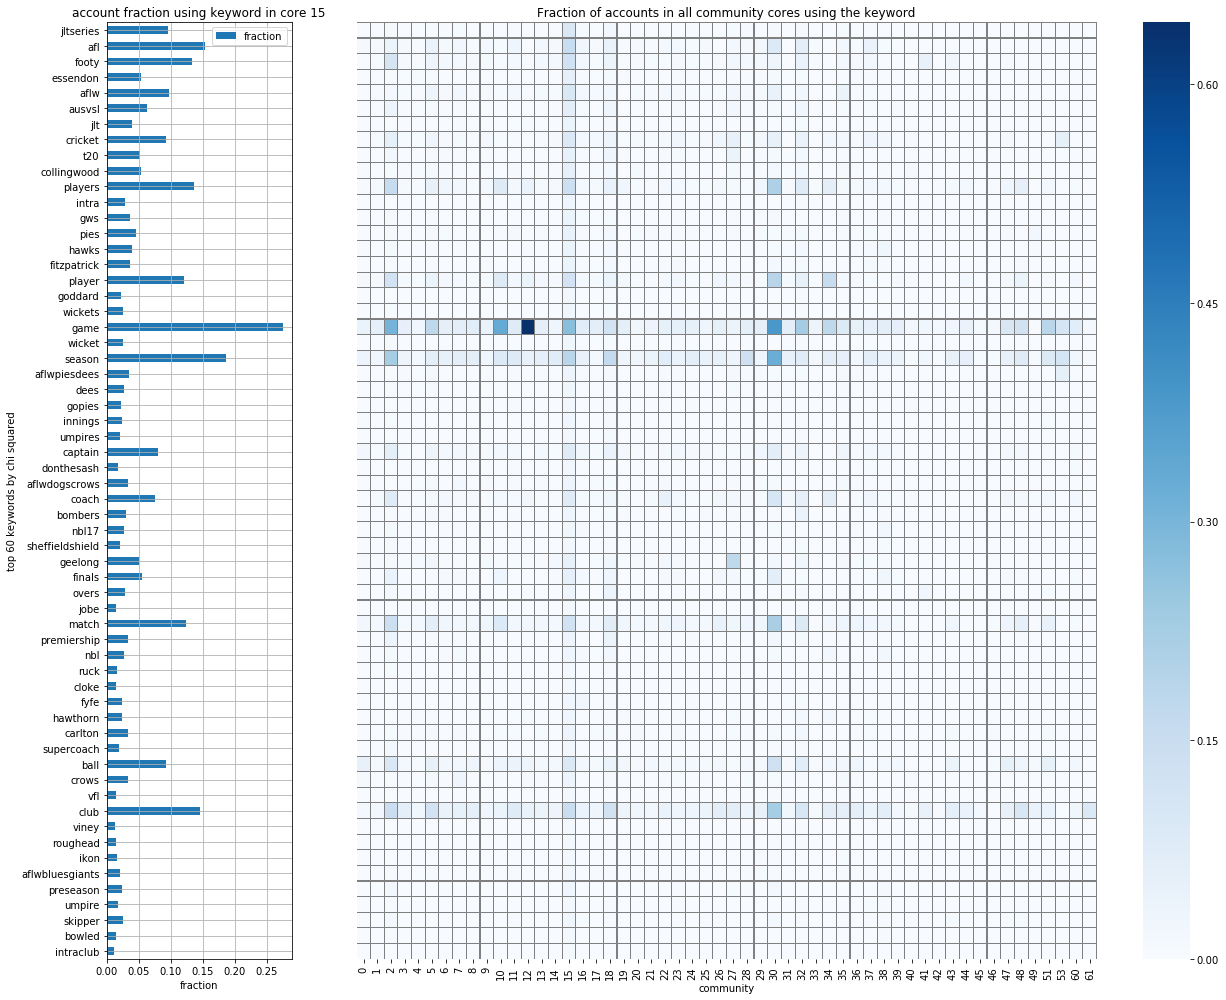



COMMUNITY 16
 n = 3556


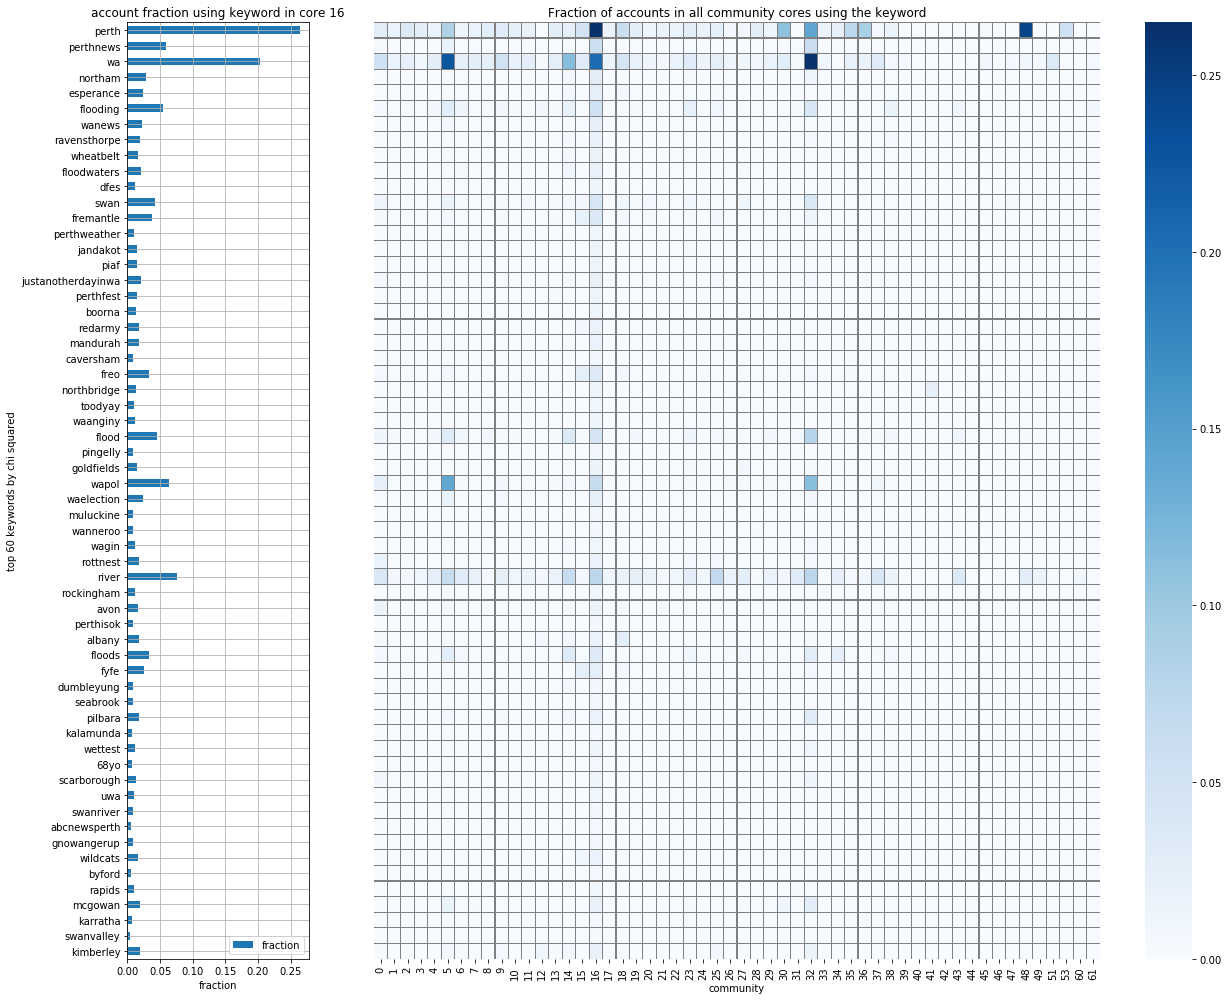



COMMUNITY 17
 n = 2341


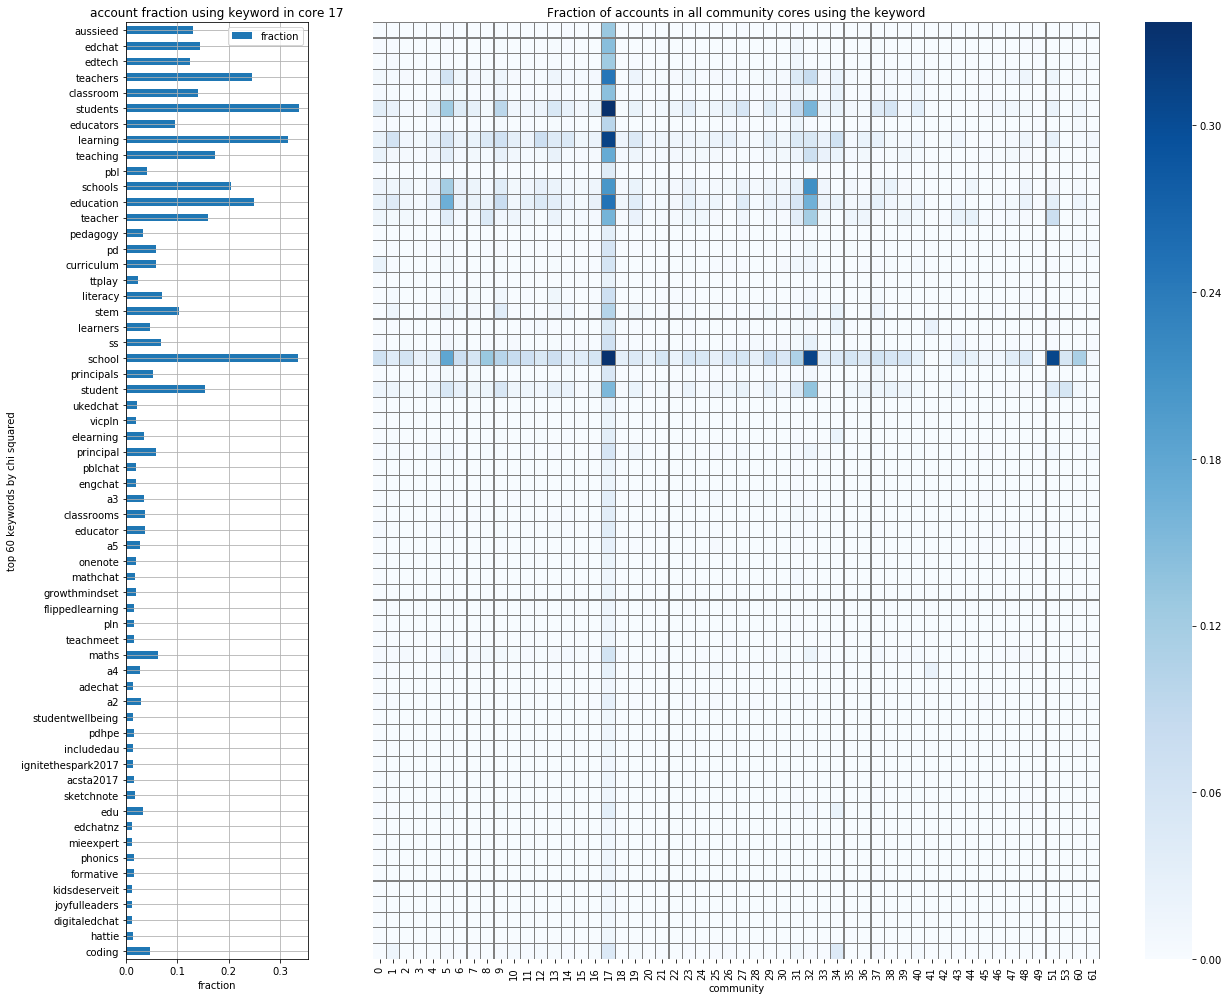



COMMUNITY 18
 n = 1199


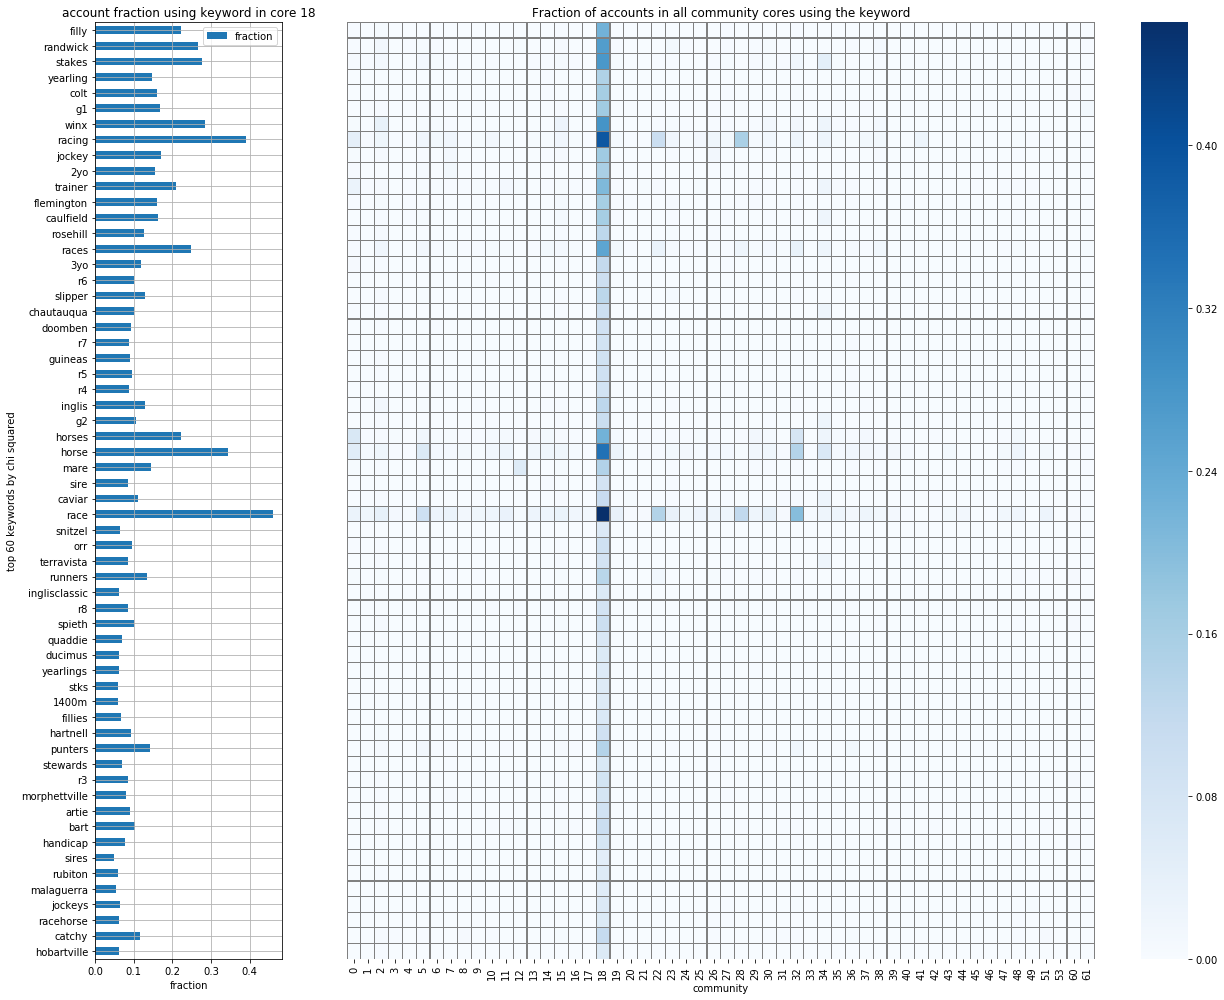



COMMUNITY 19
 n = 2782


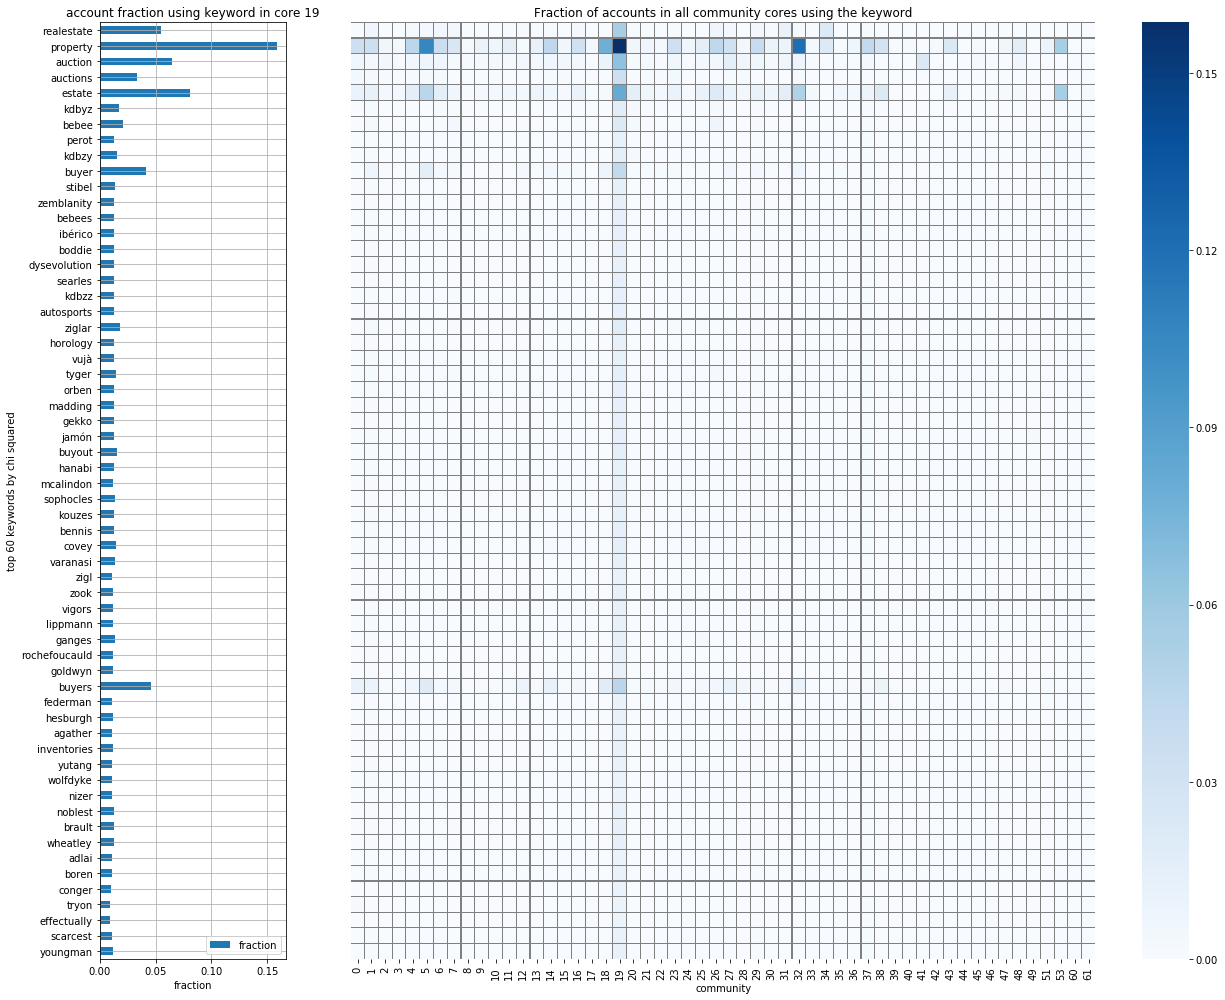



COMMUNITY 20
 n = 2087


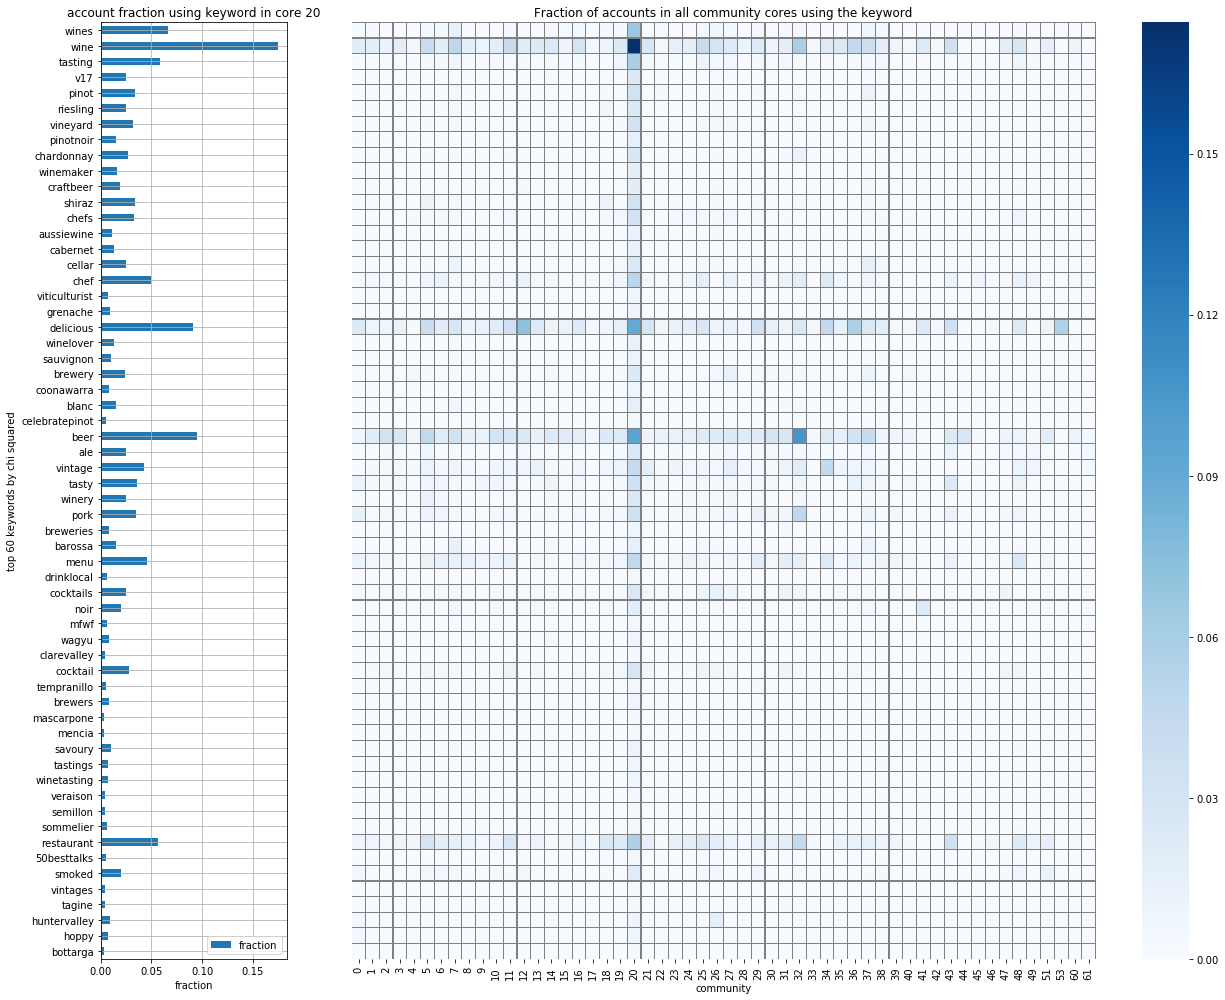



COMMUNITY 21
 n = 2996


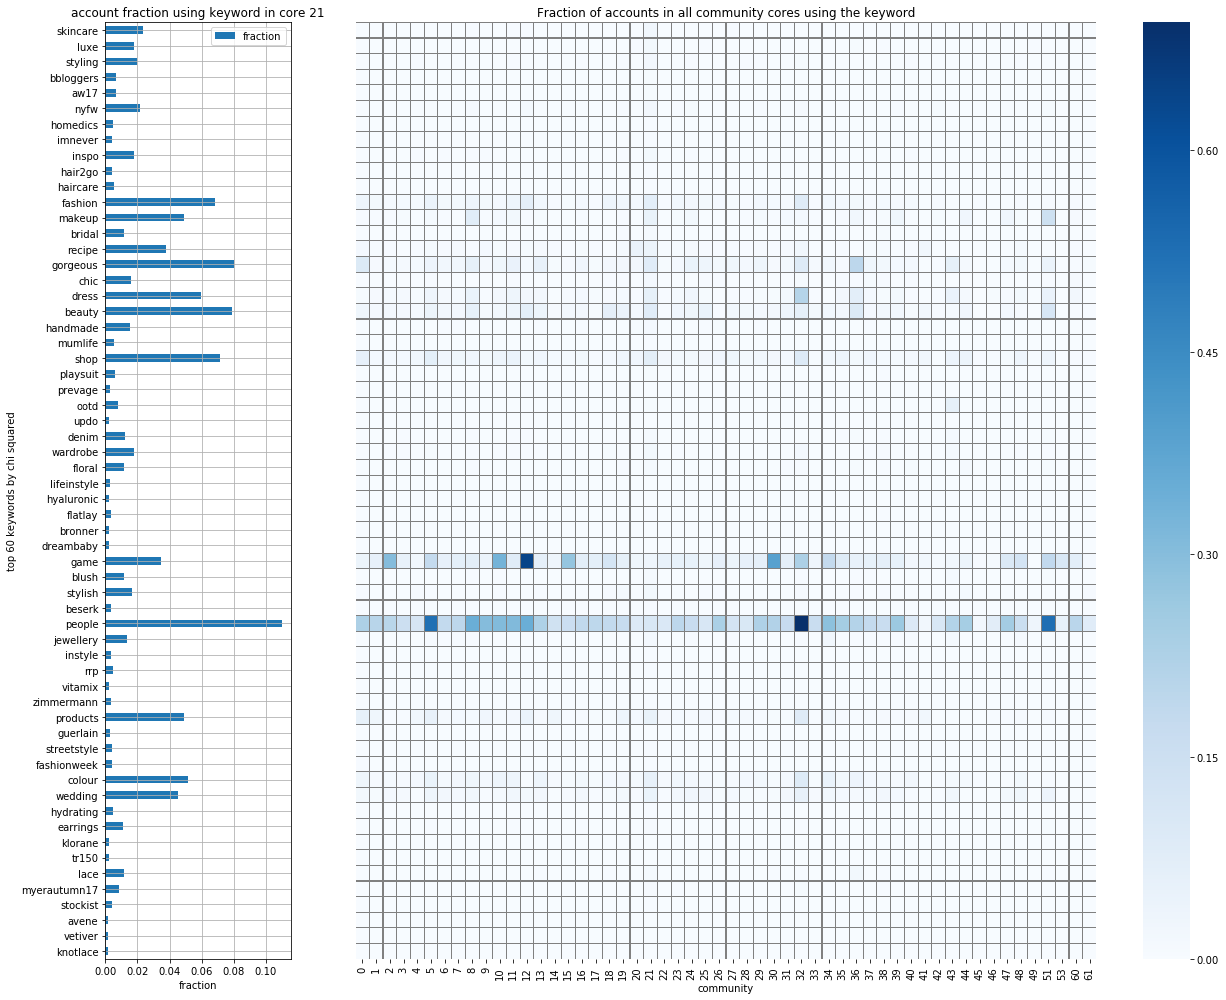



COMMUNITY 22
 n = 1828


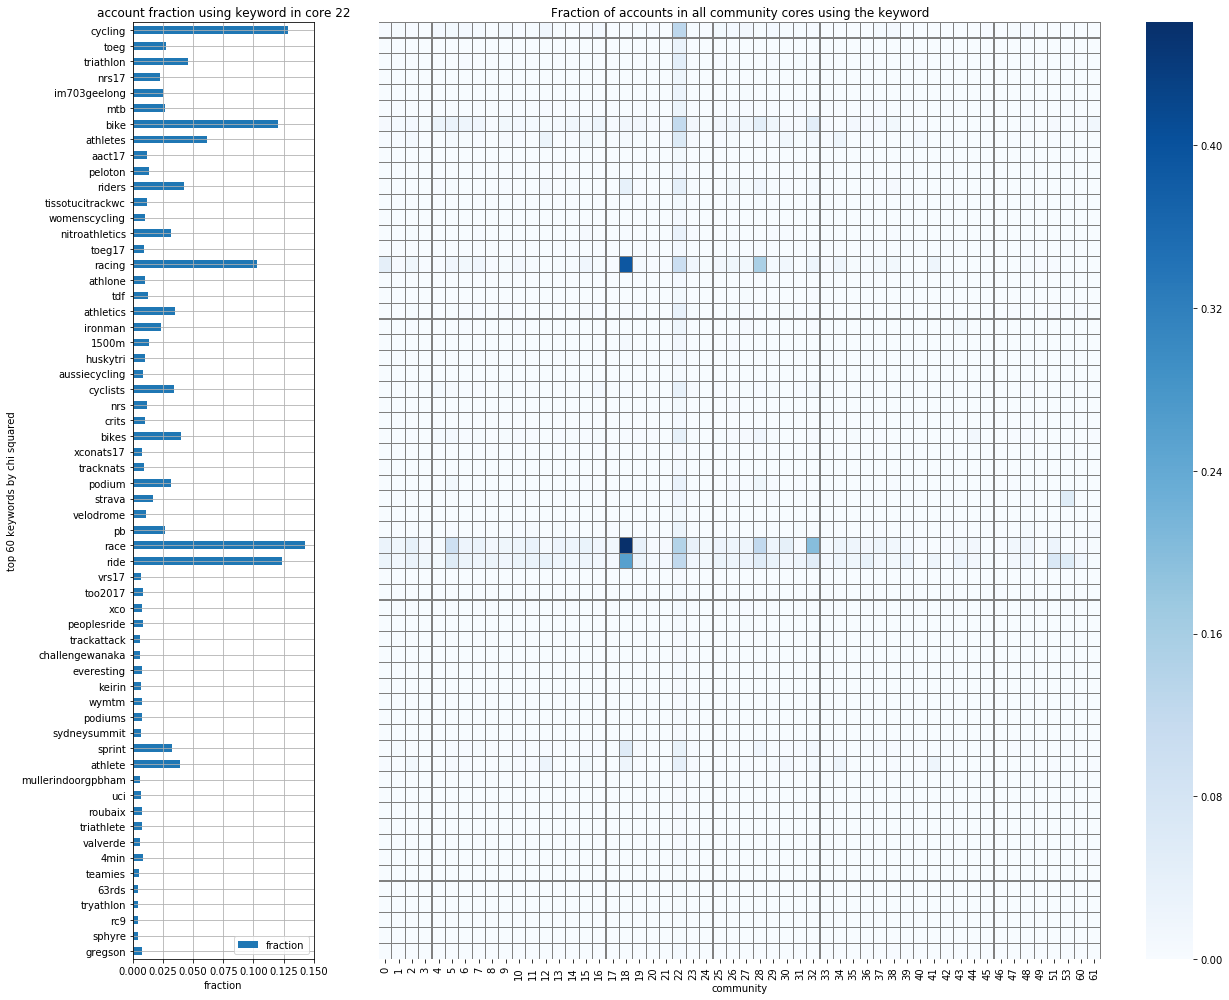



COMMUNITY 23
 n = 1809


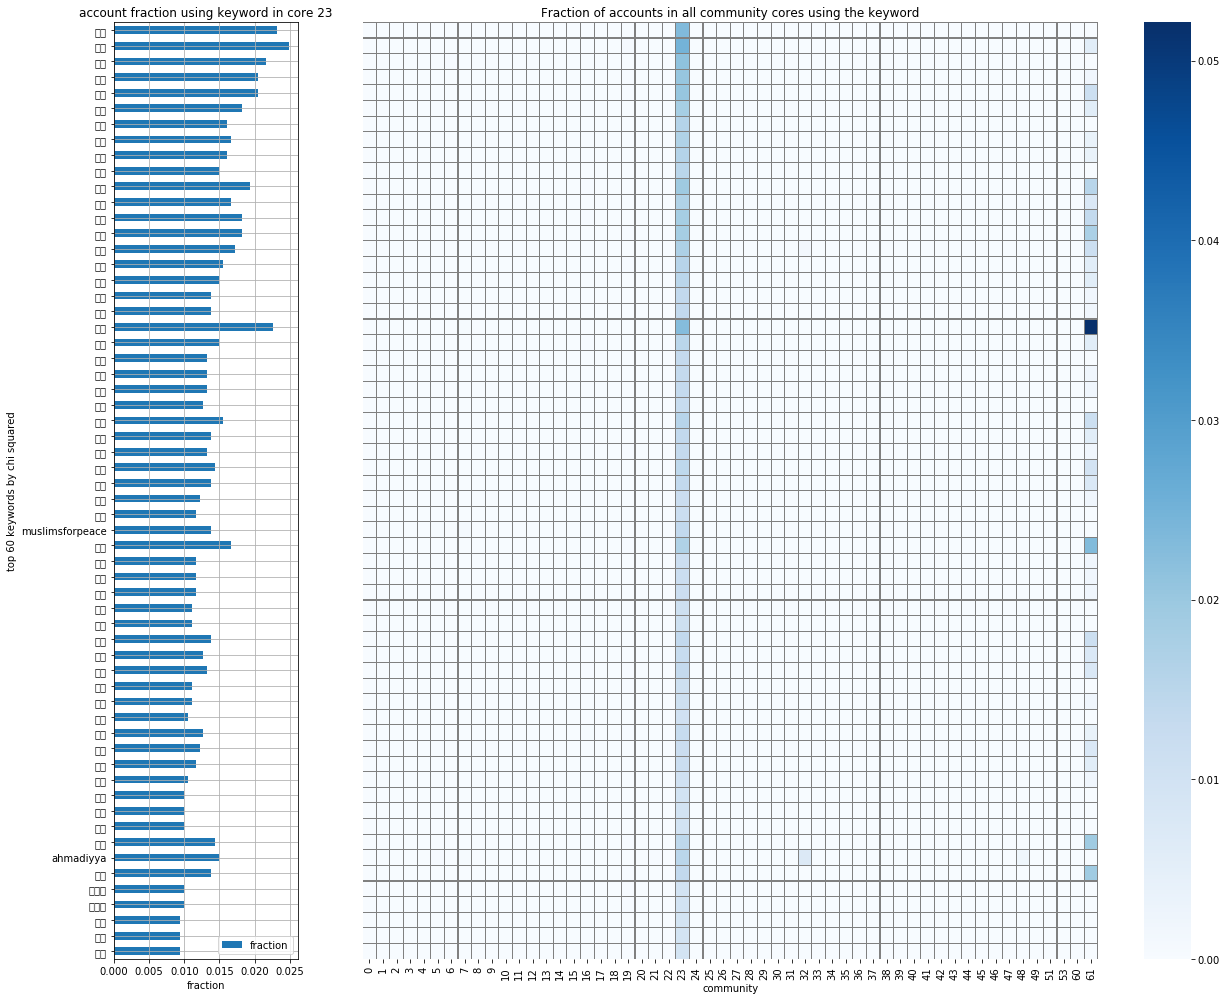



COMMUNITY 24
 n = 2073


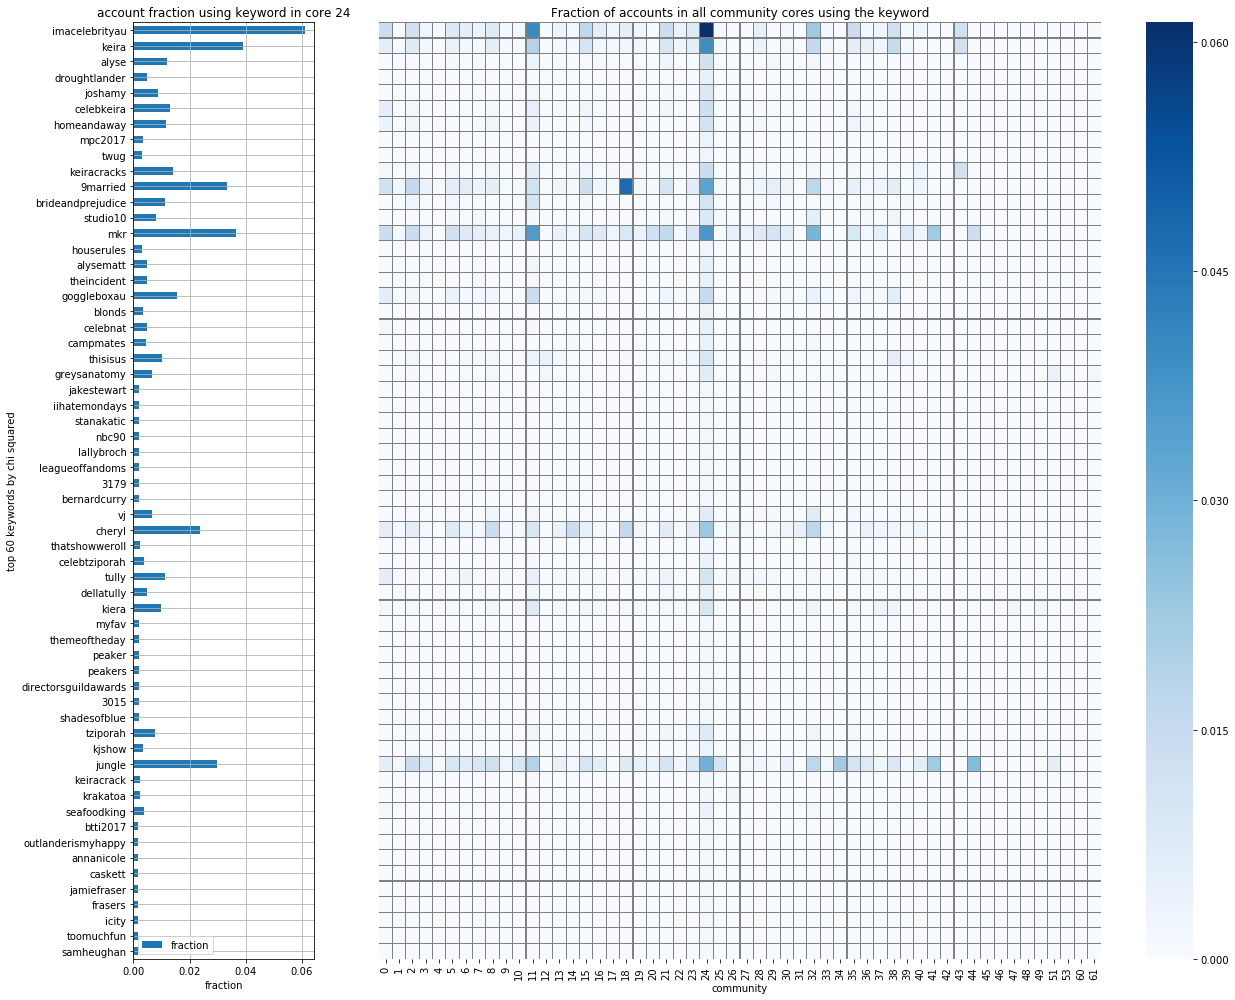



COMMUNITY 25
 n = 1881


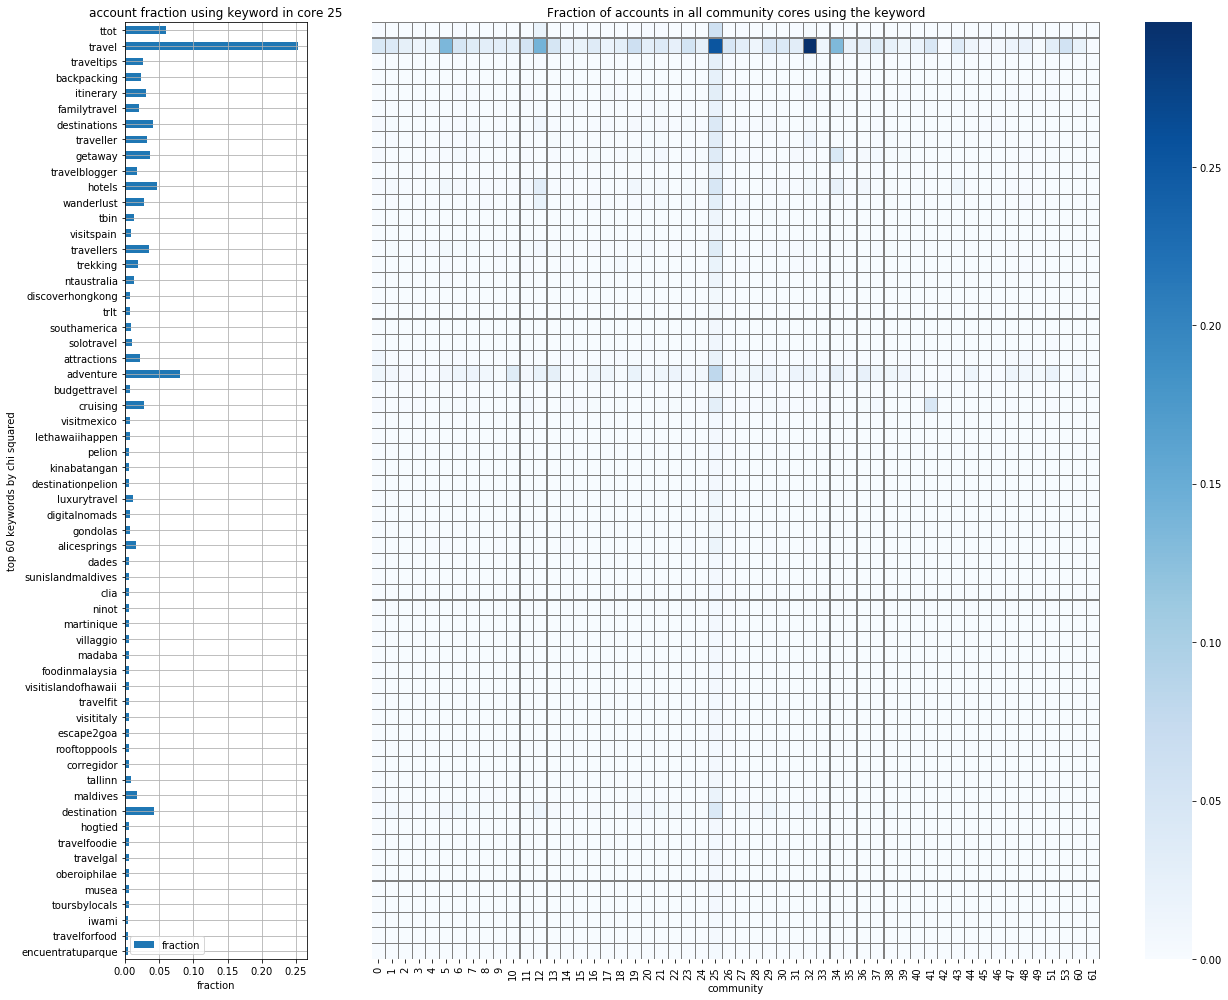



COMMUNITY 26
 n = 438


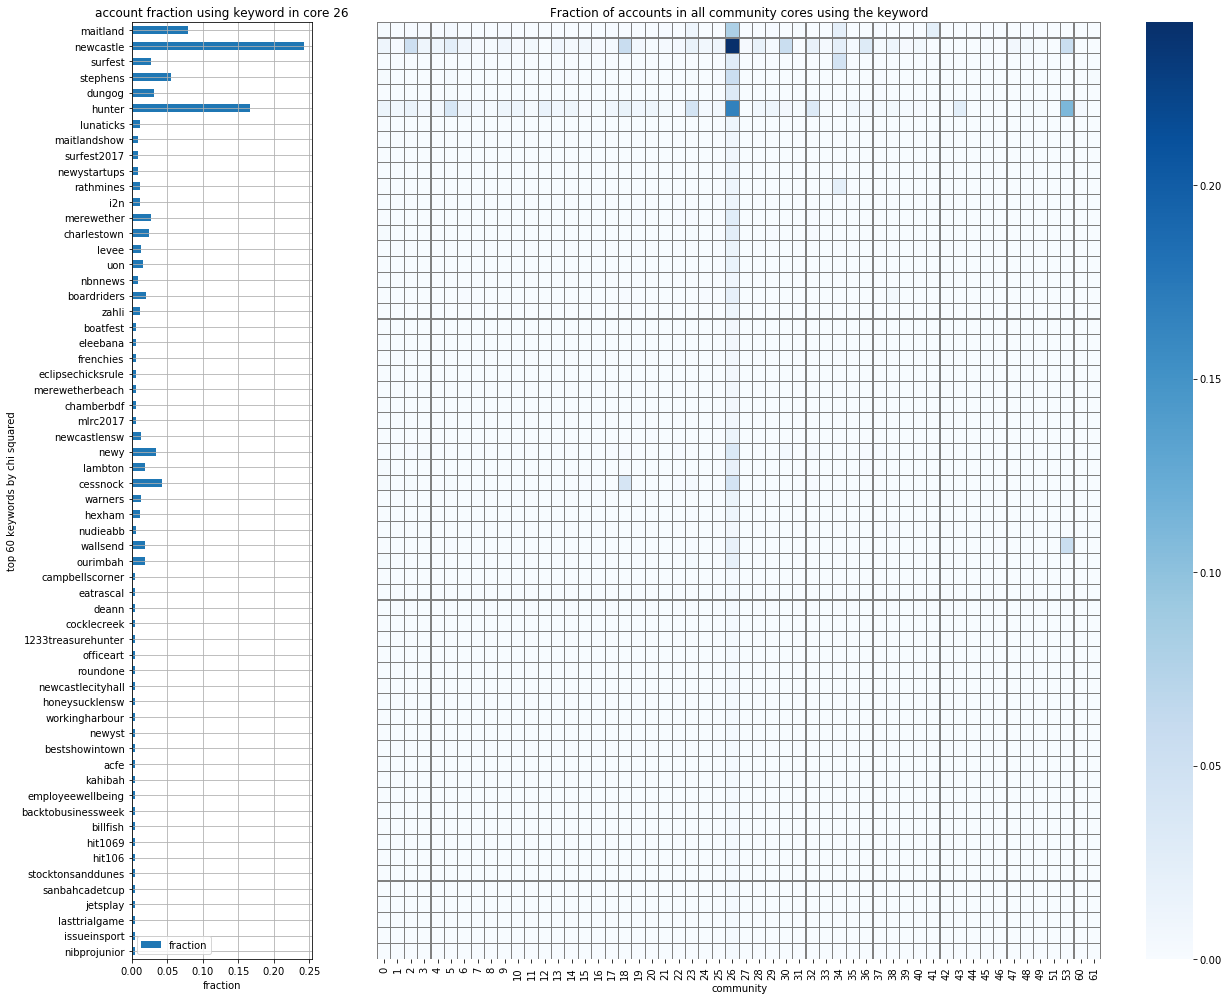



COMMUNITY 27
 n = 548


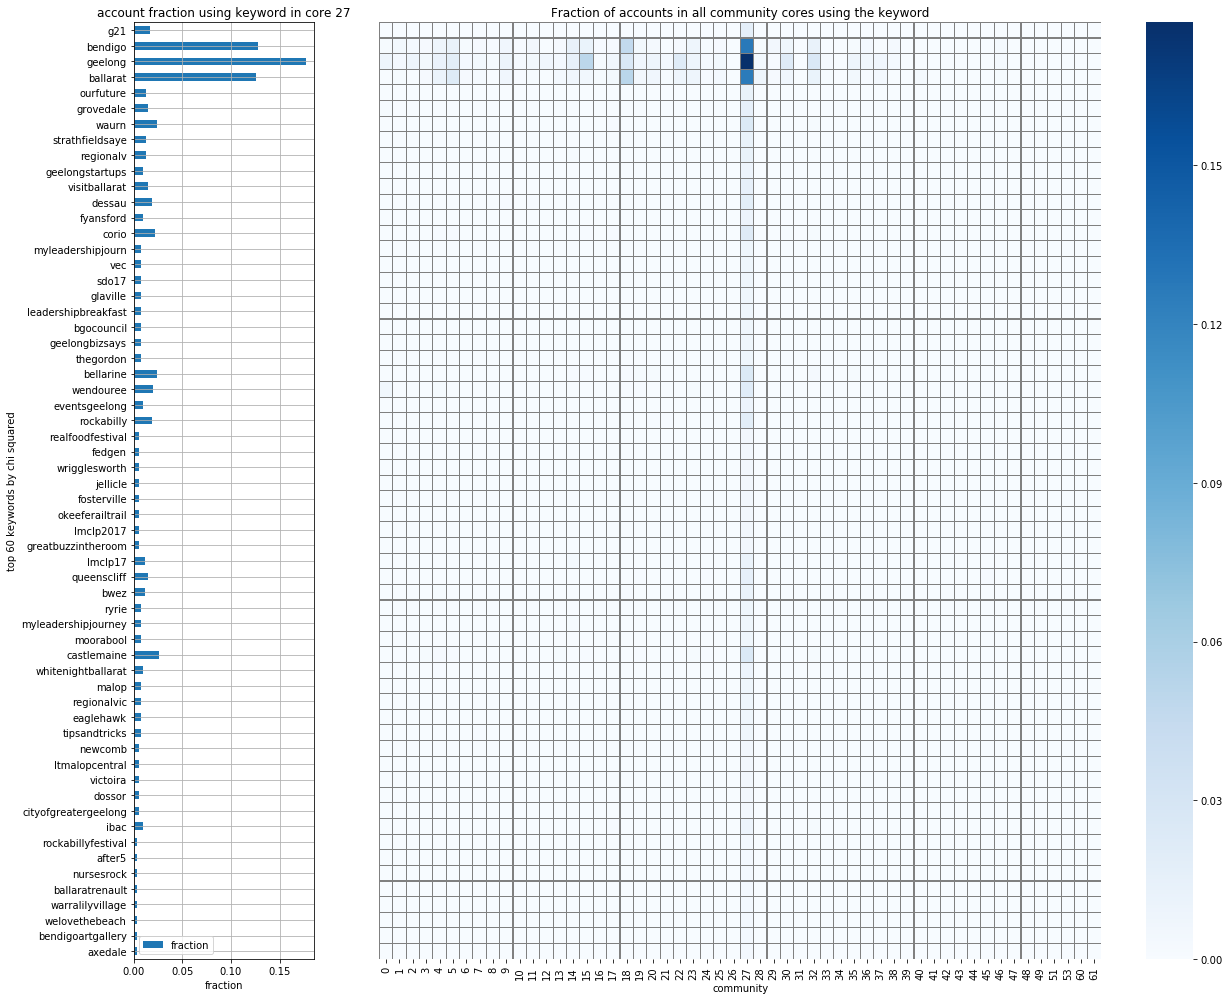



COMMUNITY 28
 n = 1117


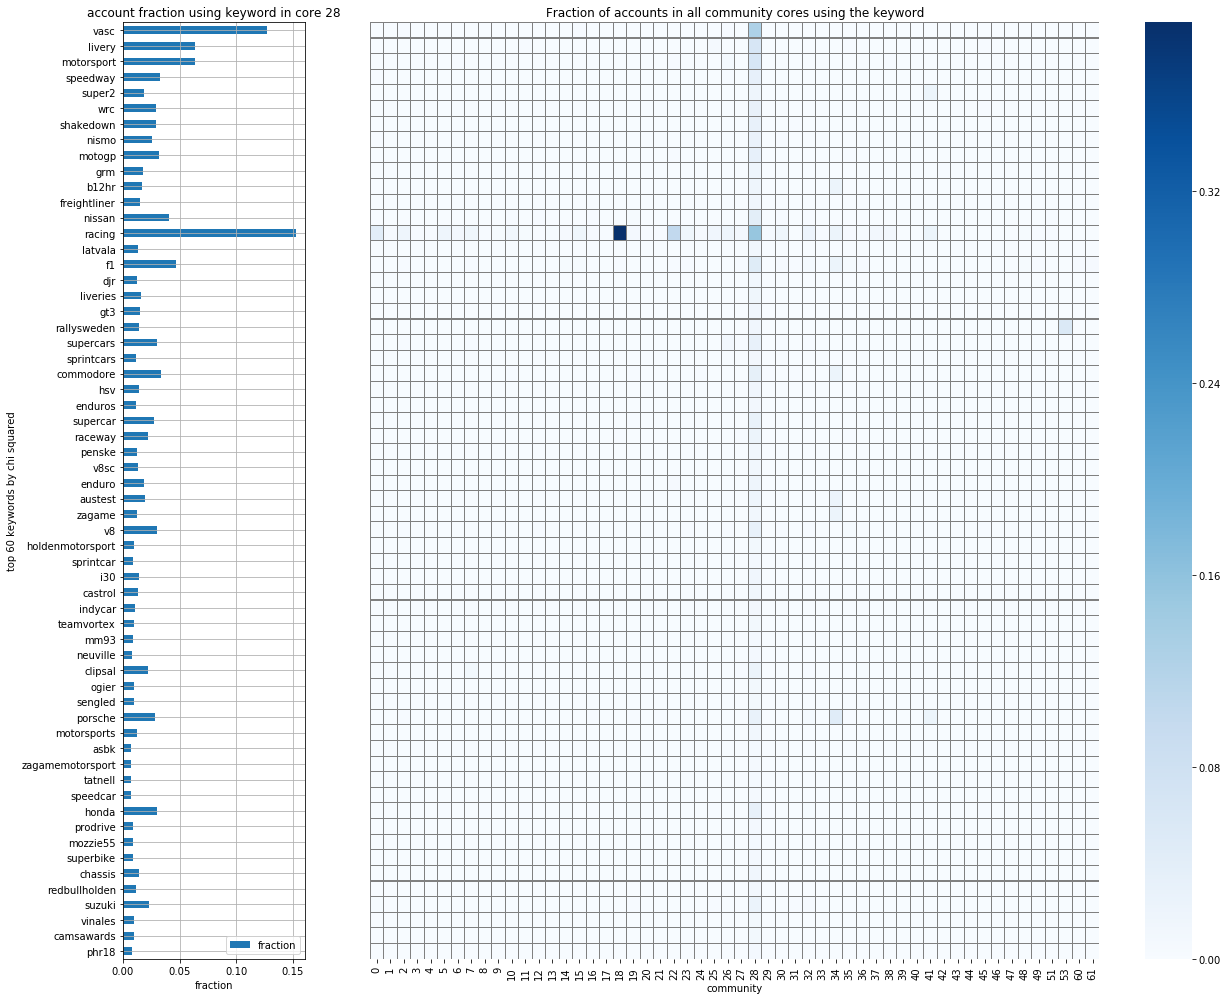



COMMUNITY 29
 n = 958


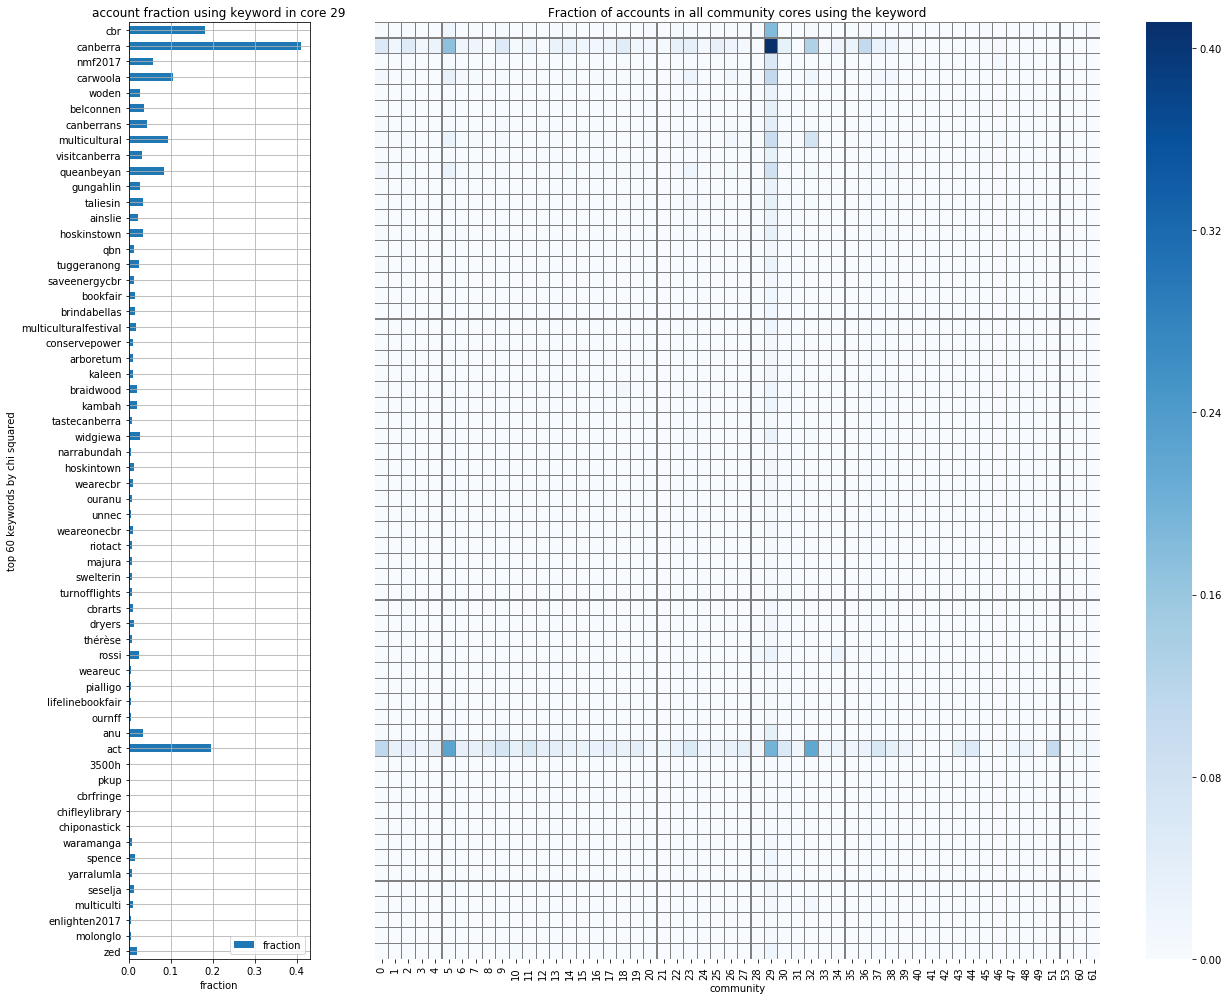



COMMUNITY 30
 n = 2340


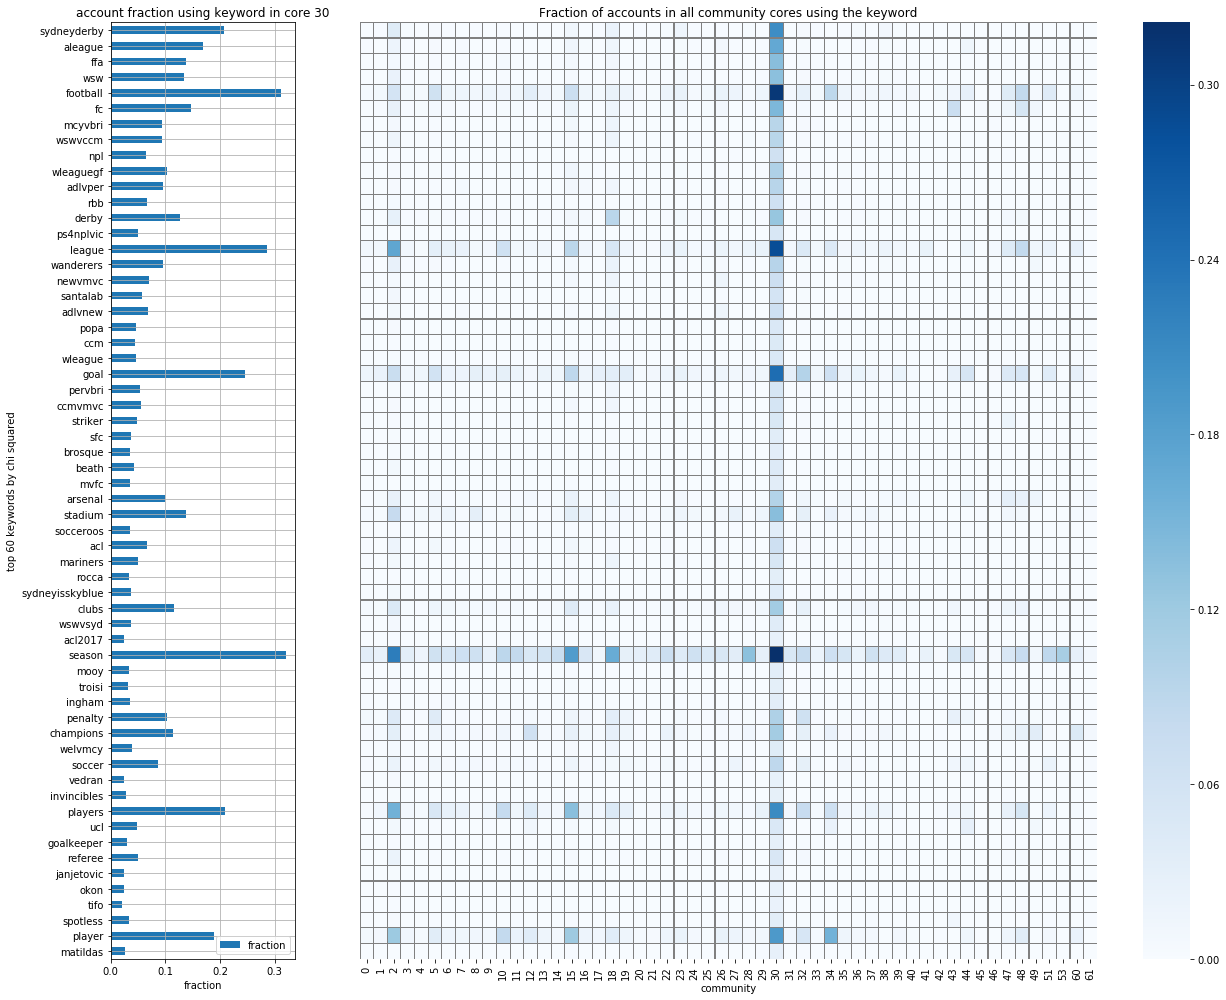



COMMUNITY 31
 n = 437


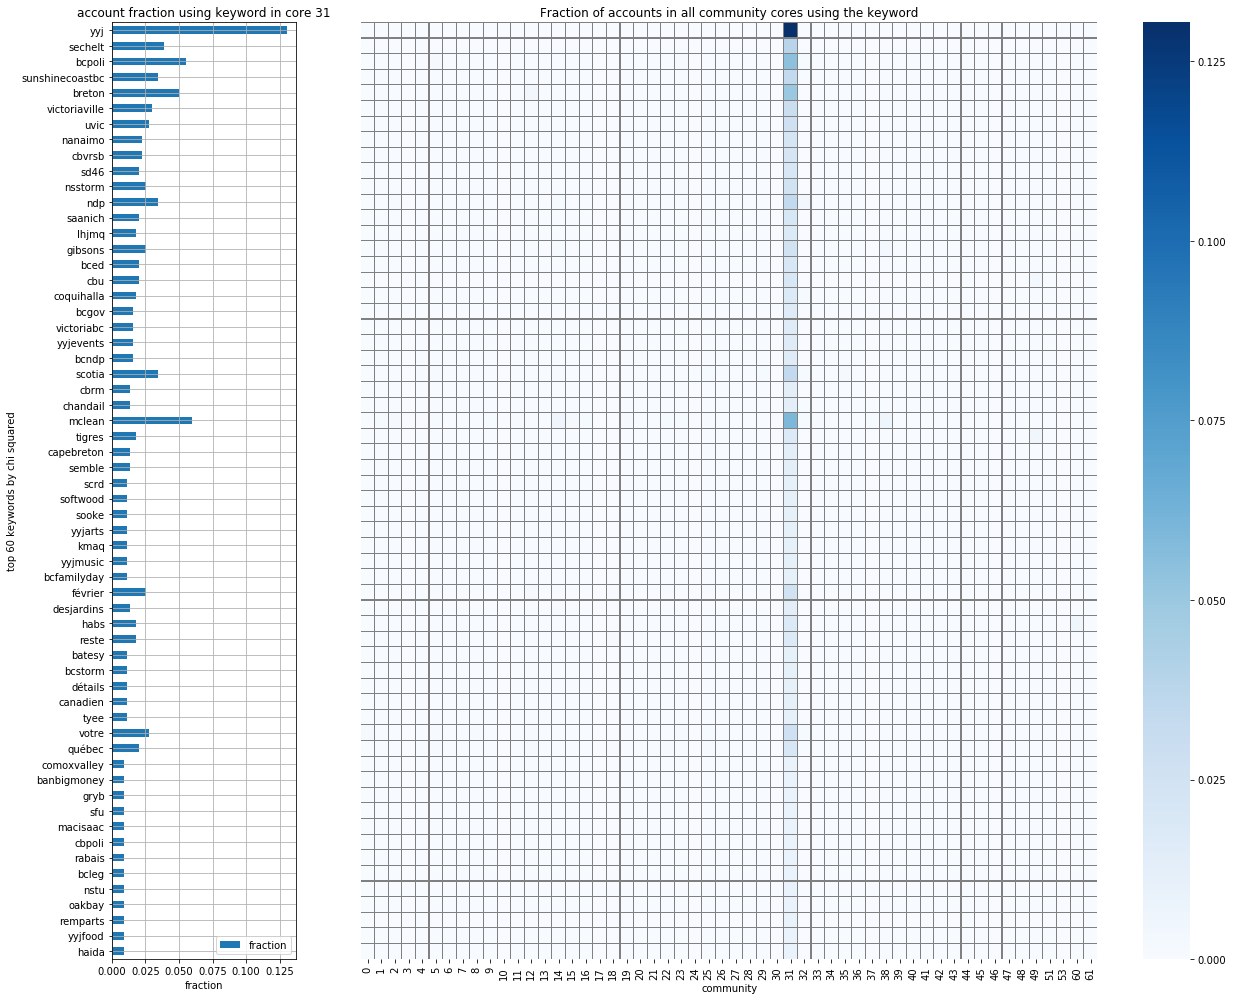



COMMUNITY 32
 n = 697


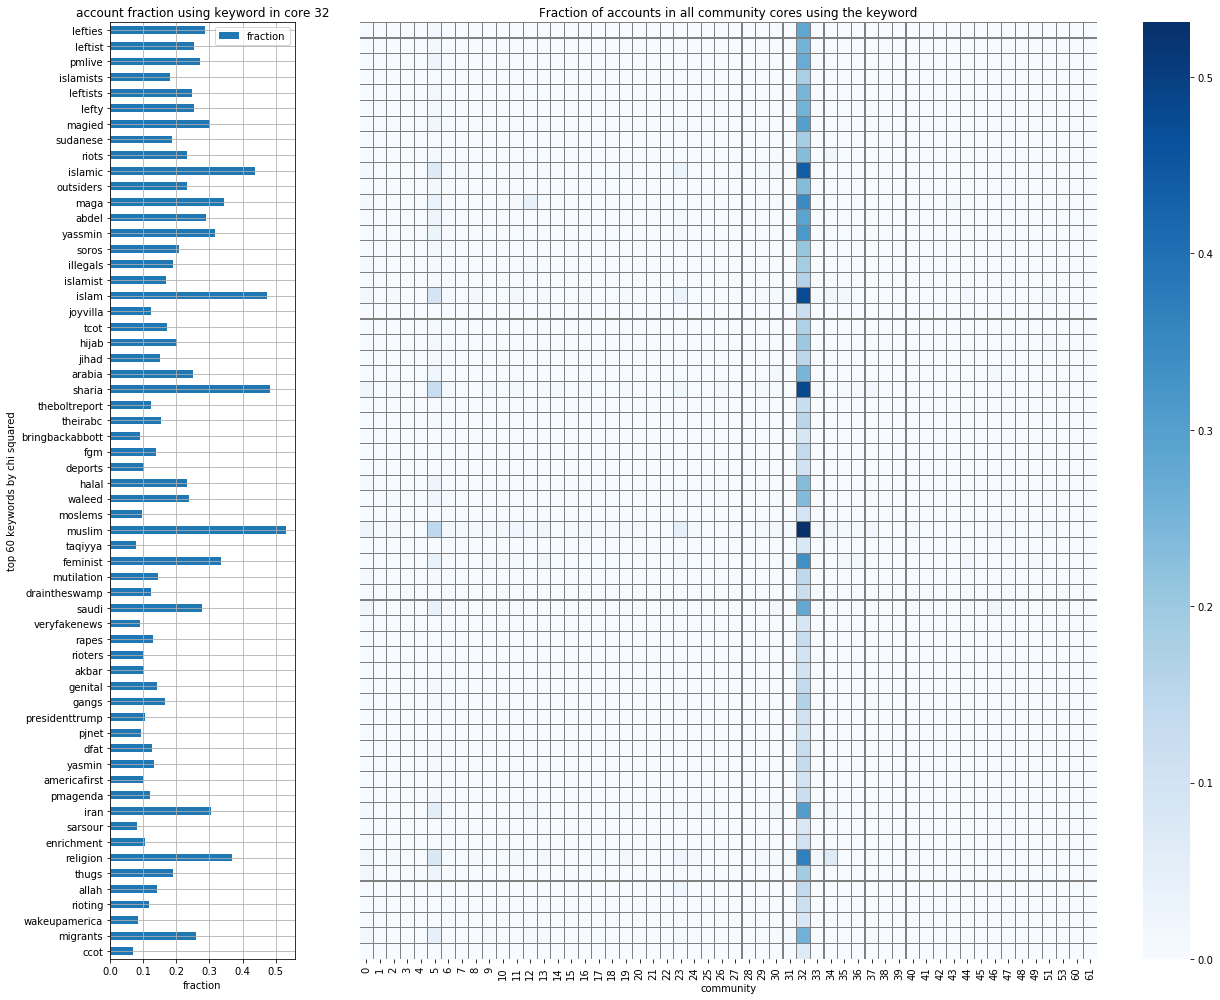



COMMUNITY 33
 n = 1550


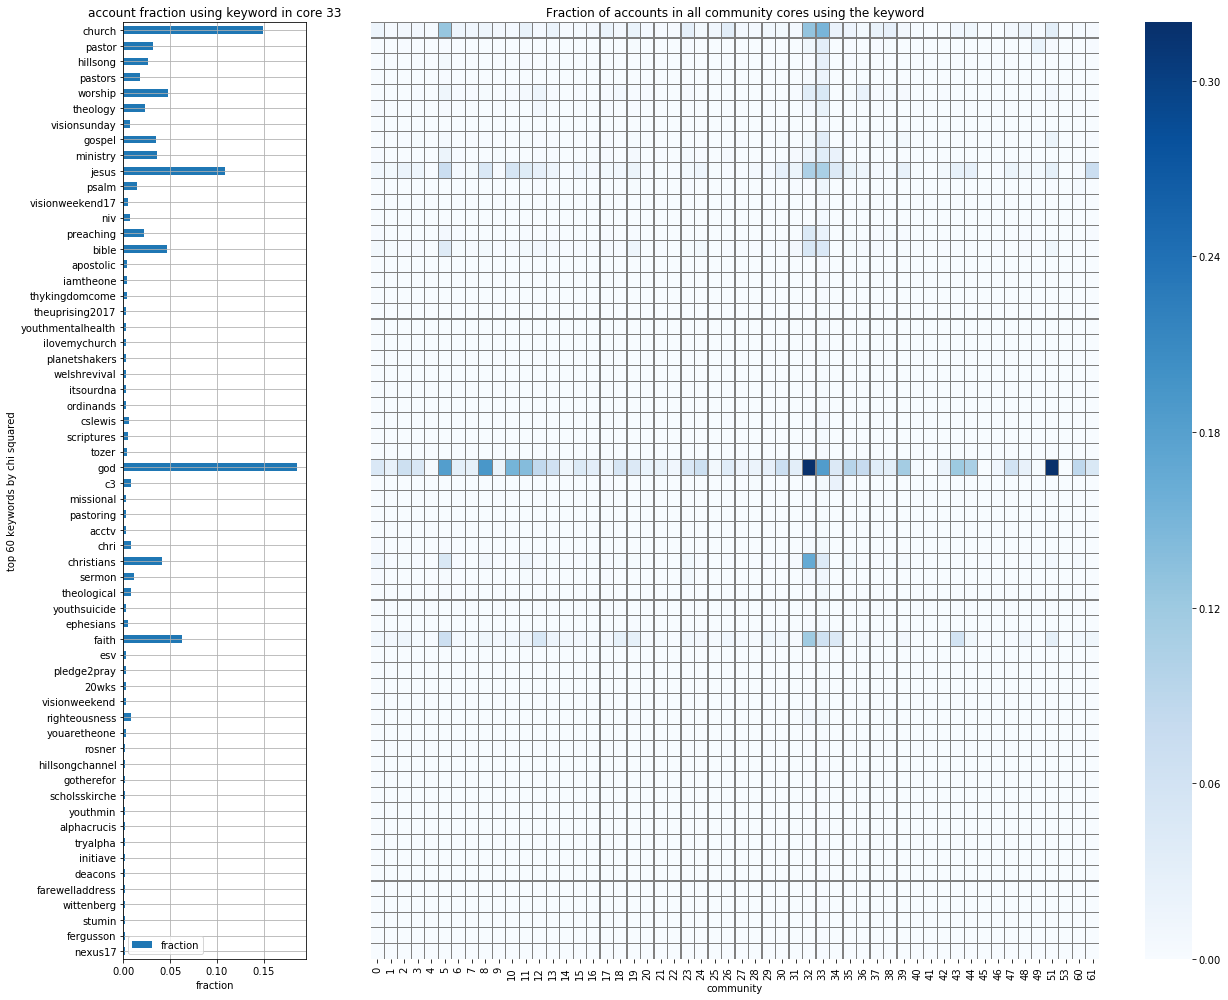



COMMUNITY 34
 n = 45


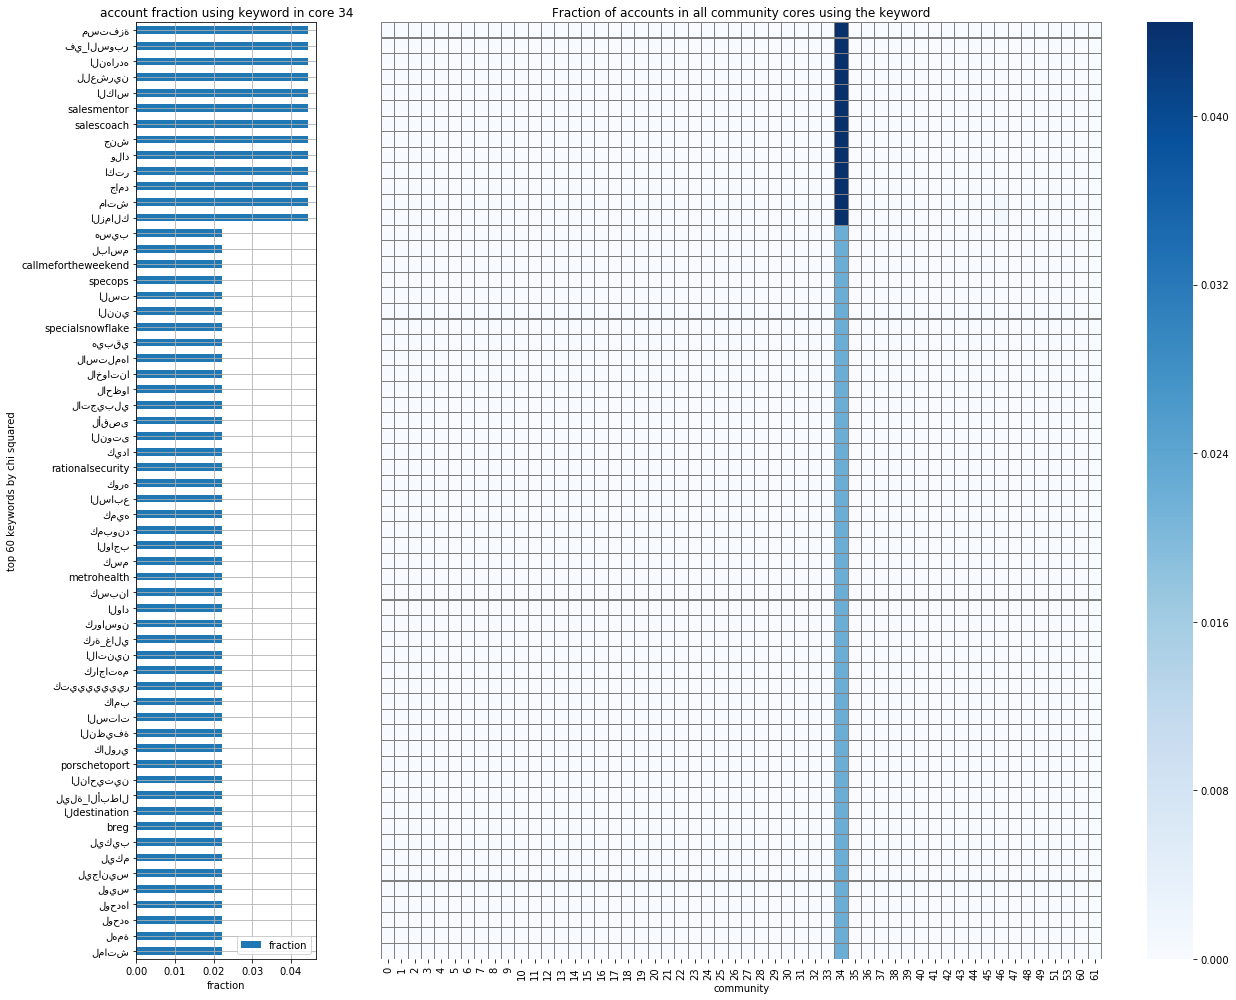



COMMUNITY 35
 n = 651


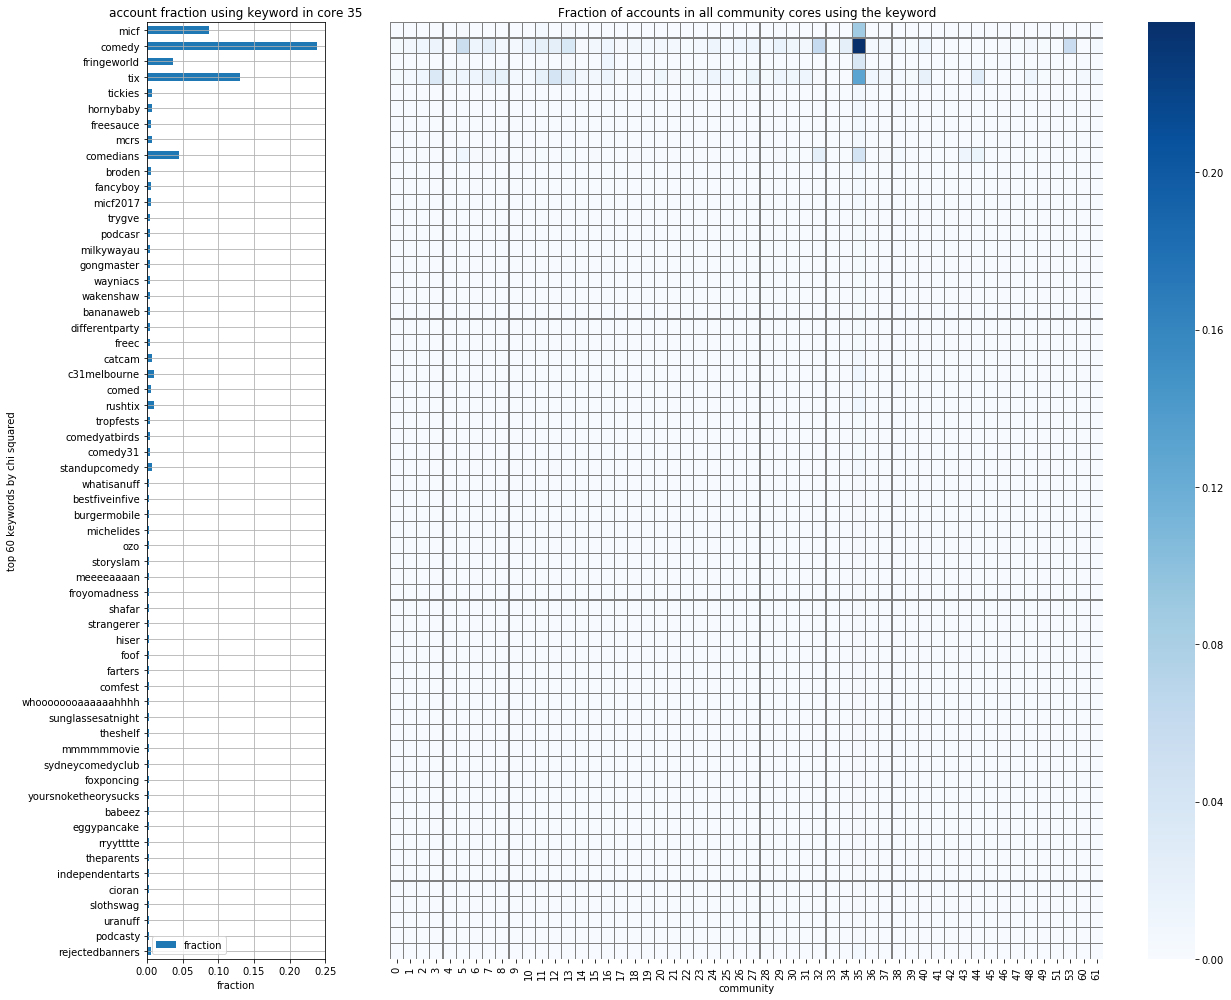



COMMUNITY 36
 n = 1008


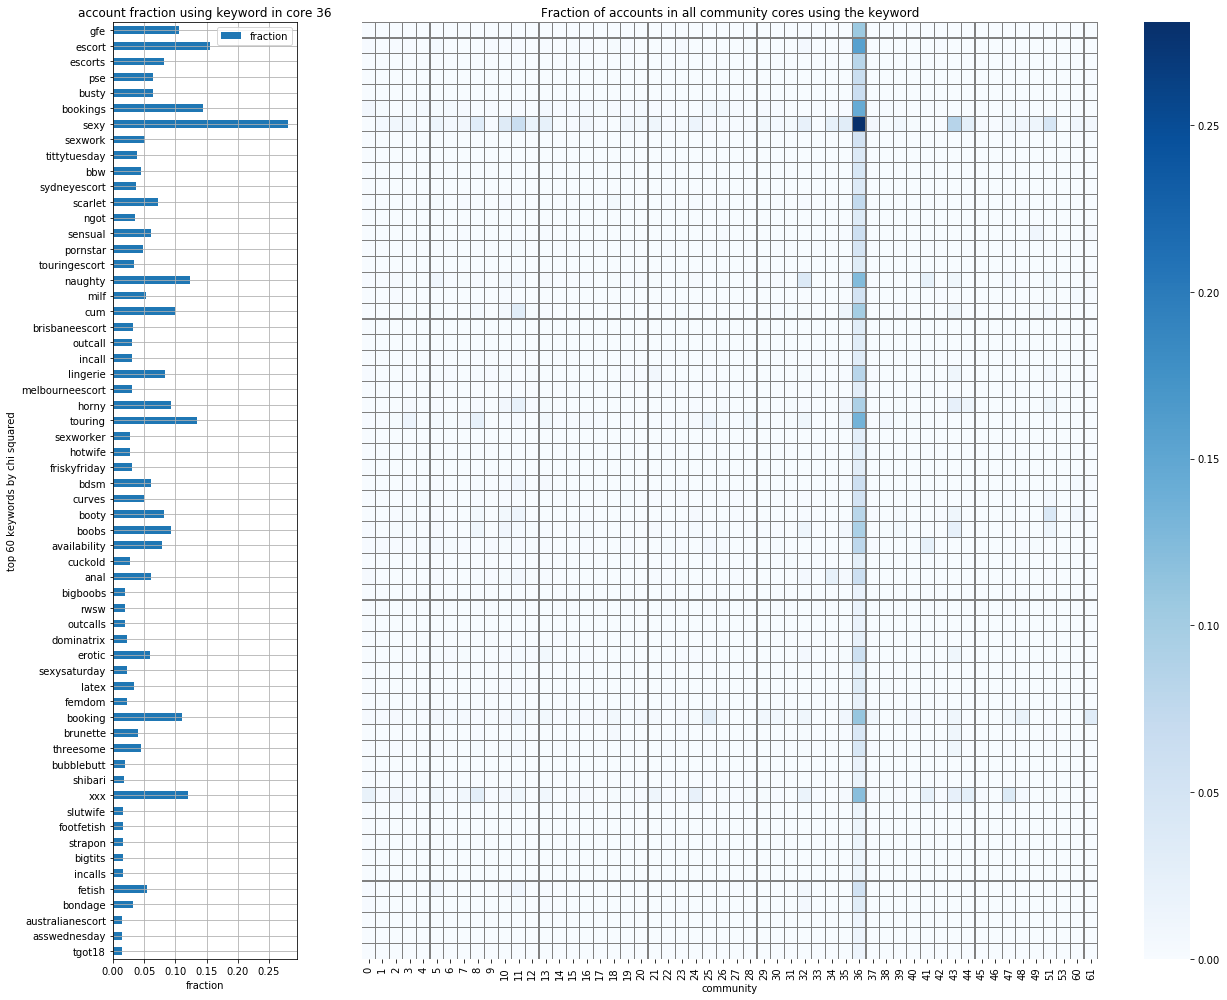



COMMUNITY 37
 n = 731


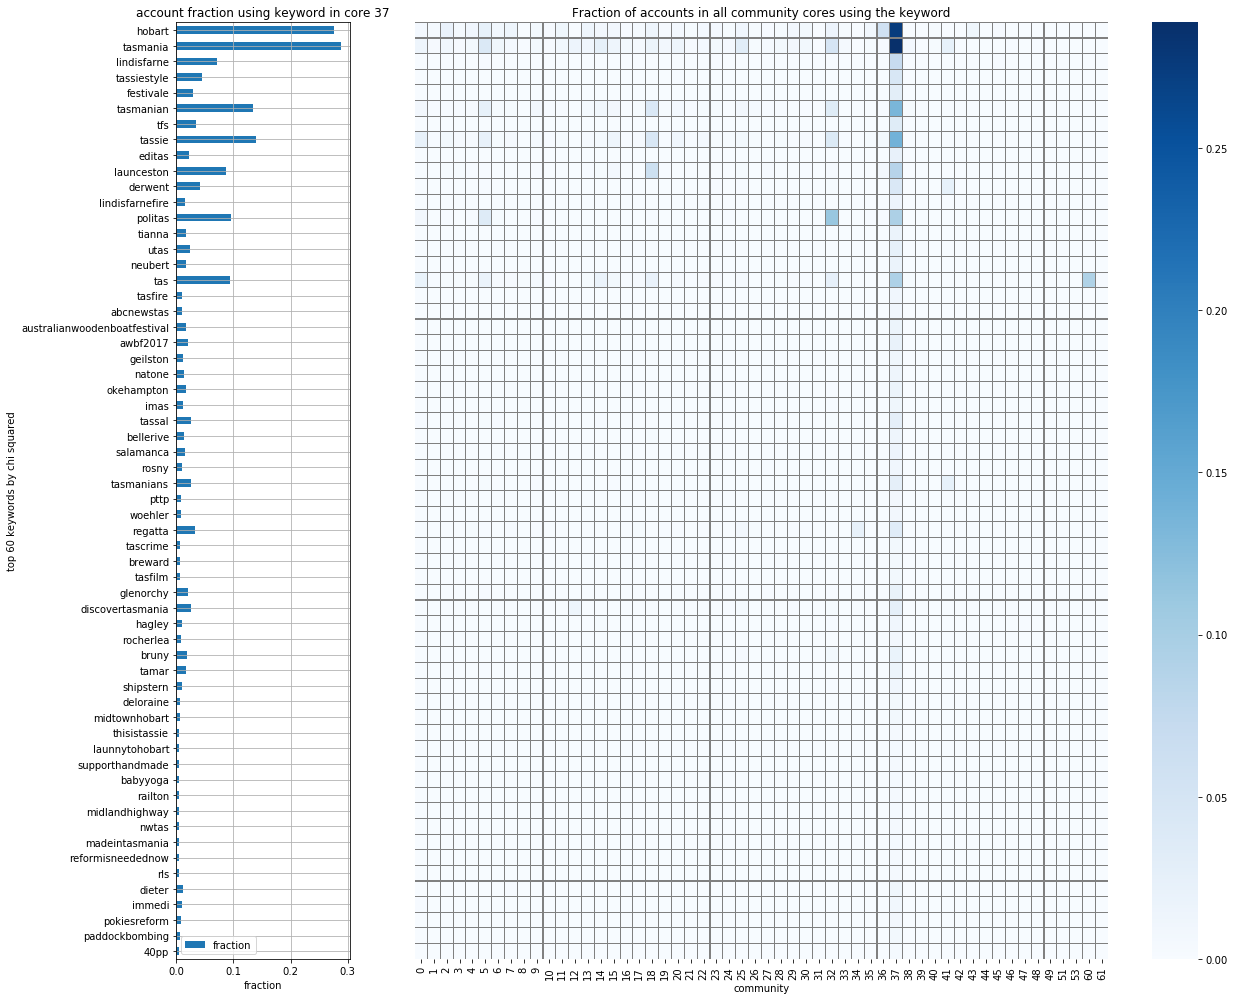



COMMUNITY 38
 n = 331


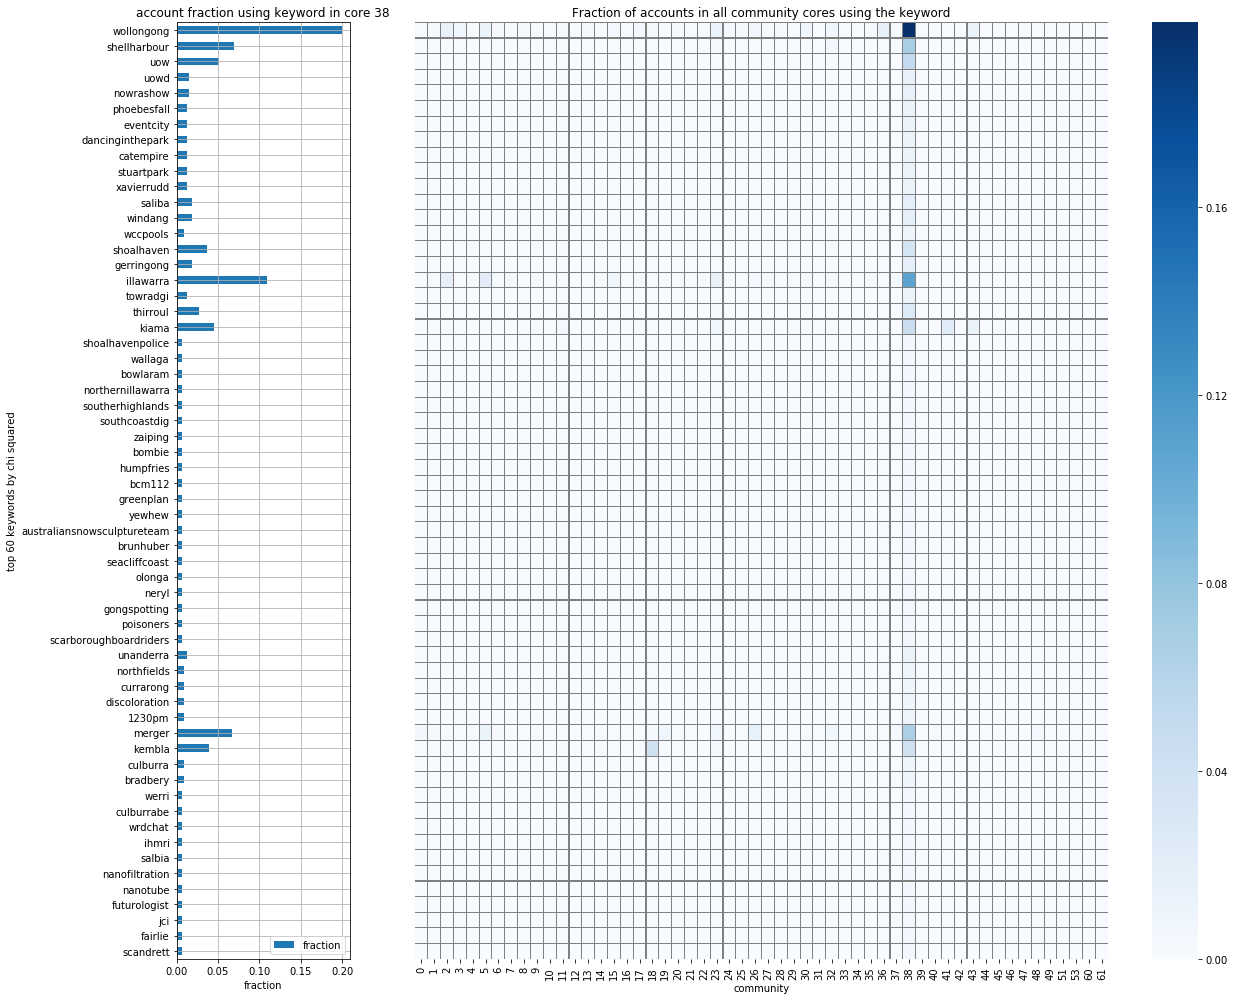



COMMUNITY 39
 n = 1974


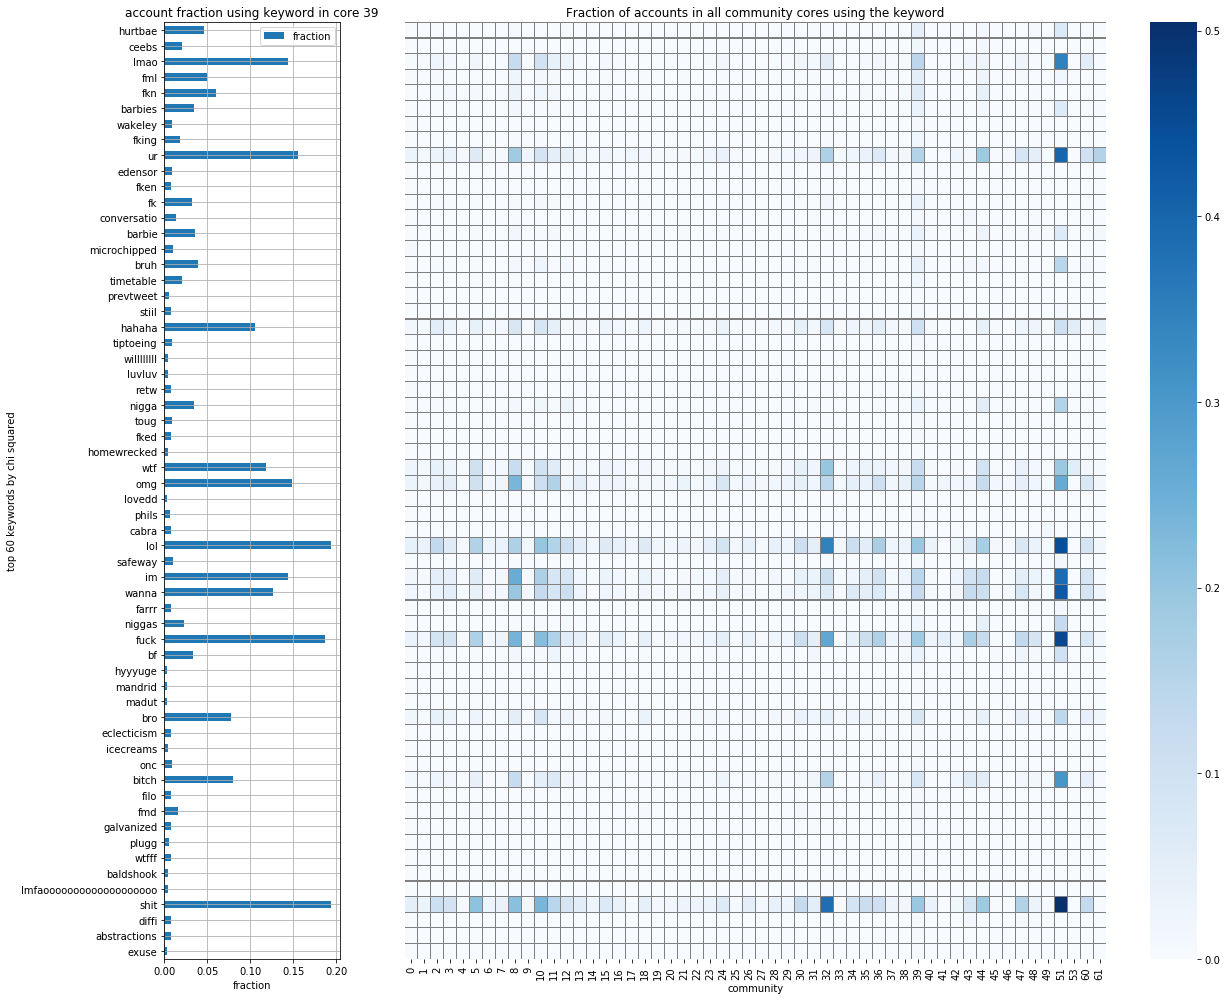



COMMUNITY 40
 n = 329


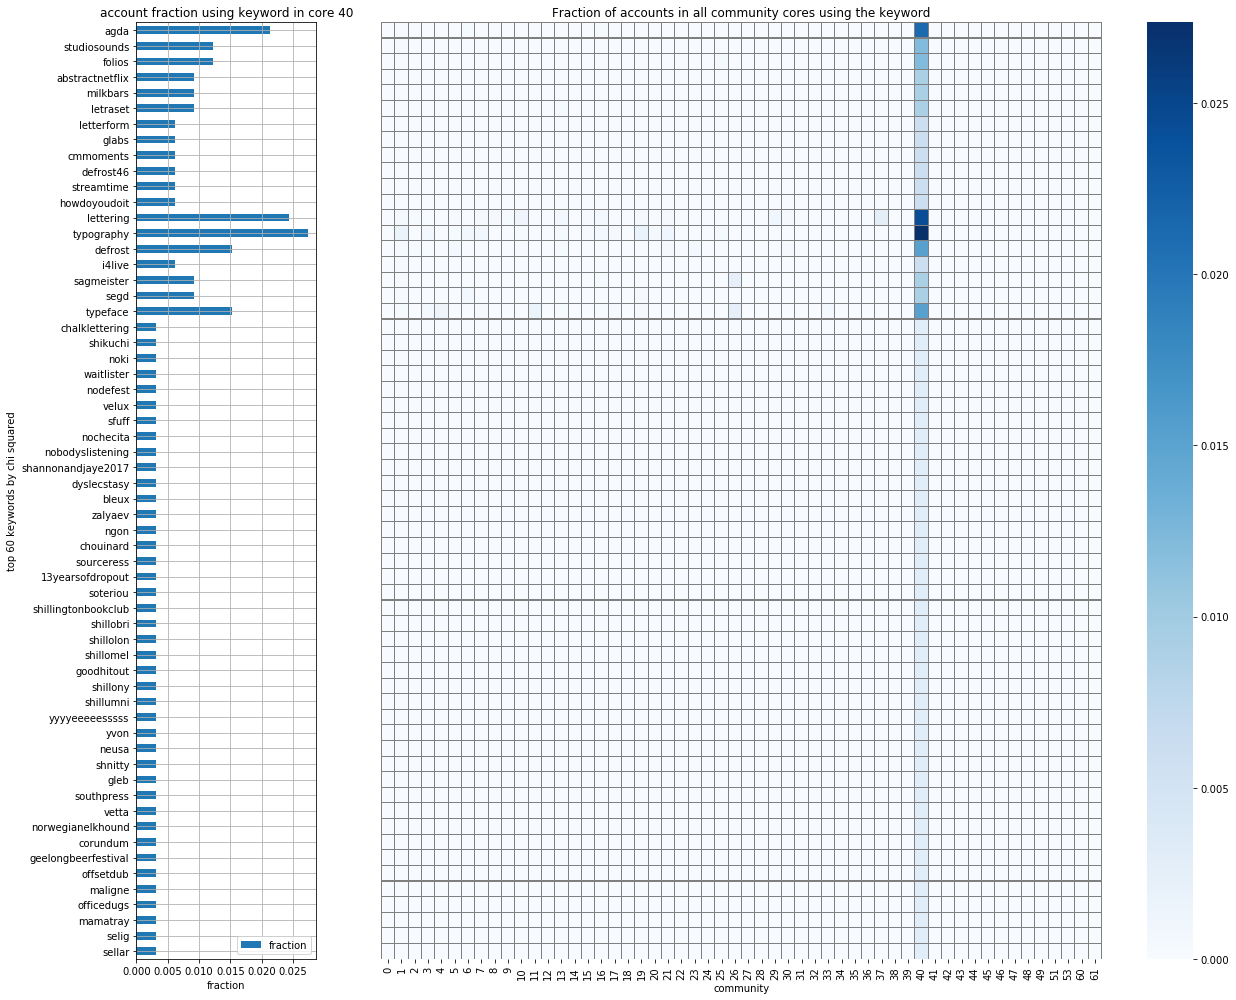



COMMUNITY 41
 n = 44


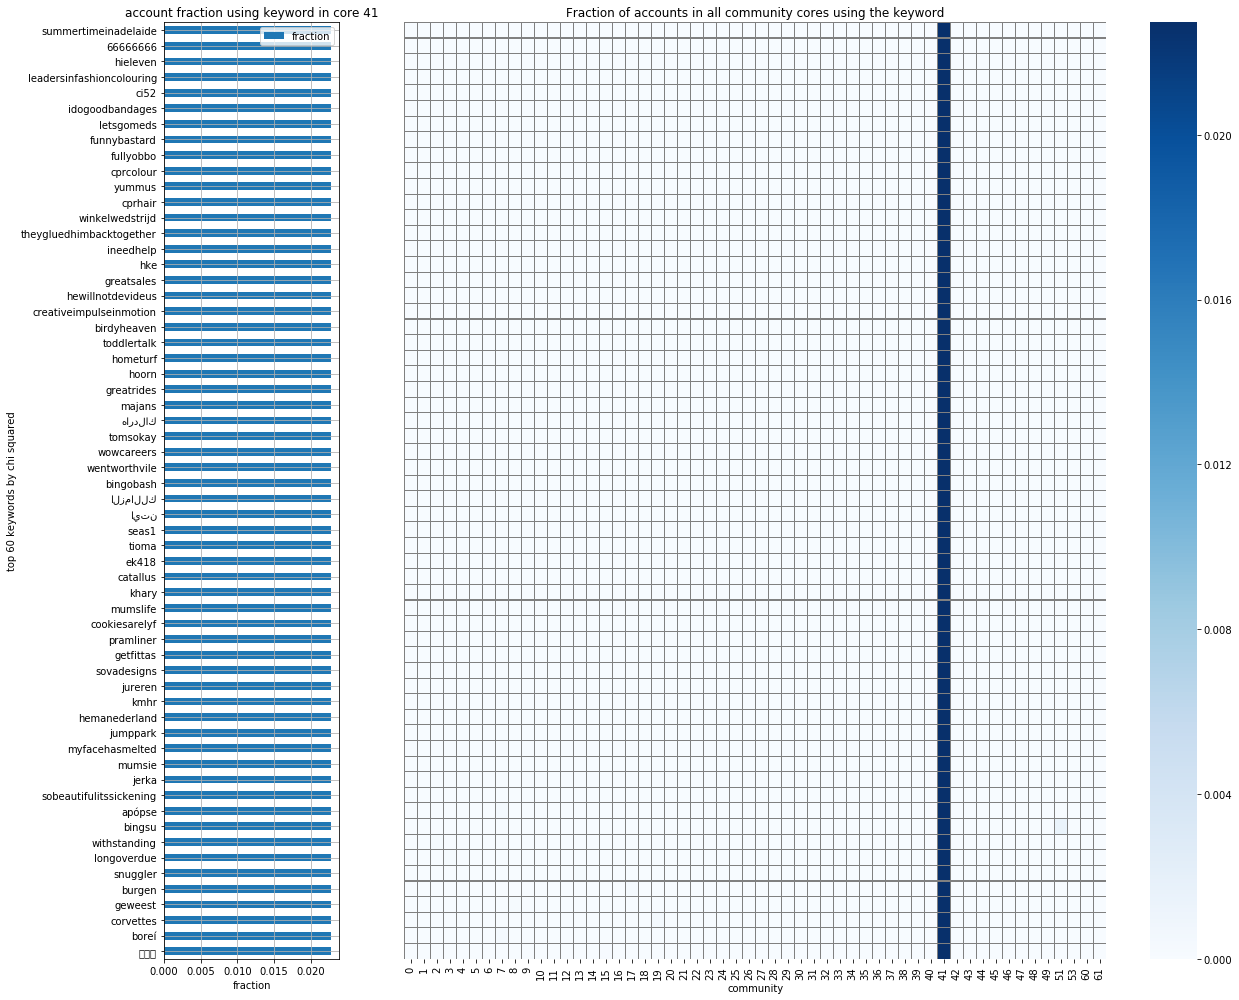



COMMUNITY 42
 n = 530


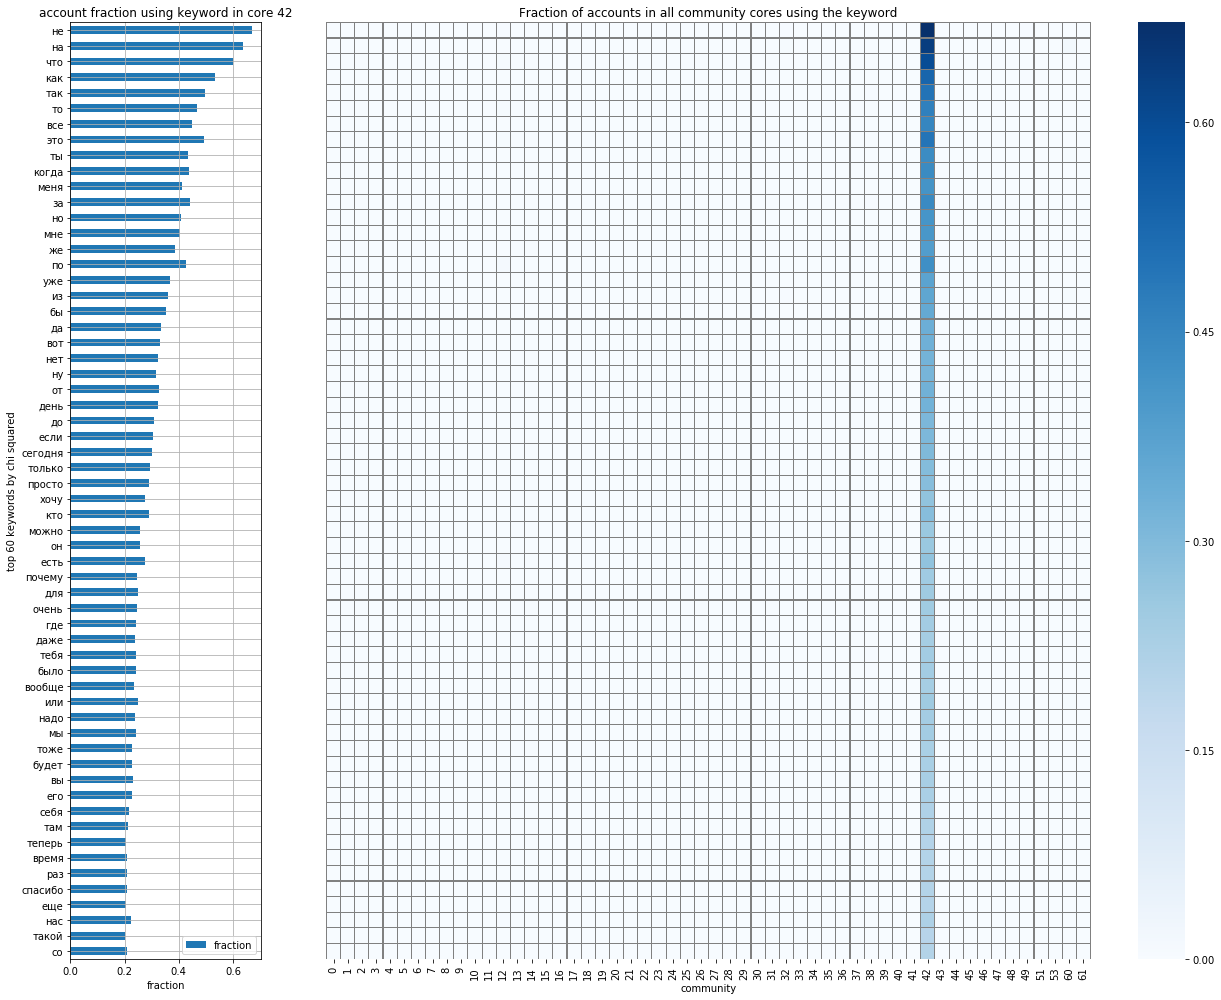



COMMUNITY 43
 n = 83


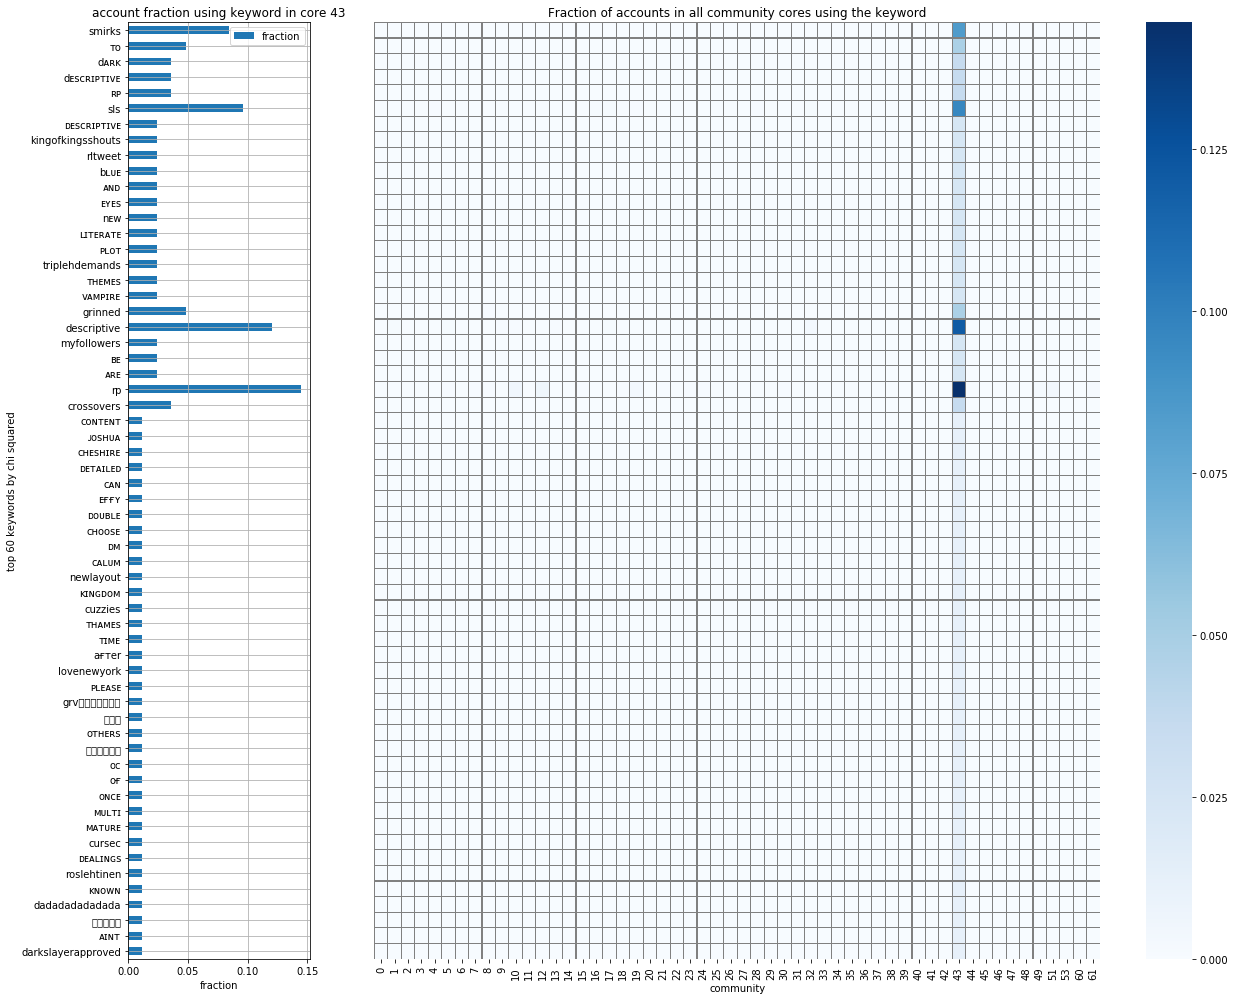



COMMUNITY 44
 n = 74


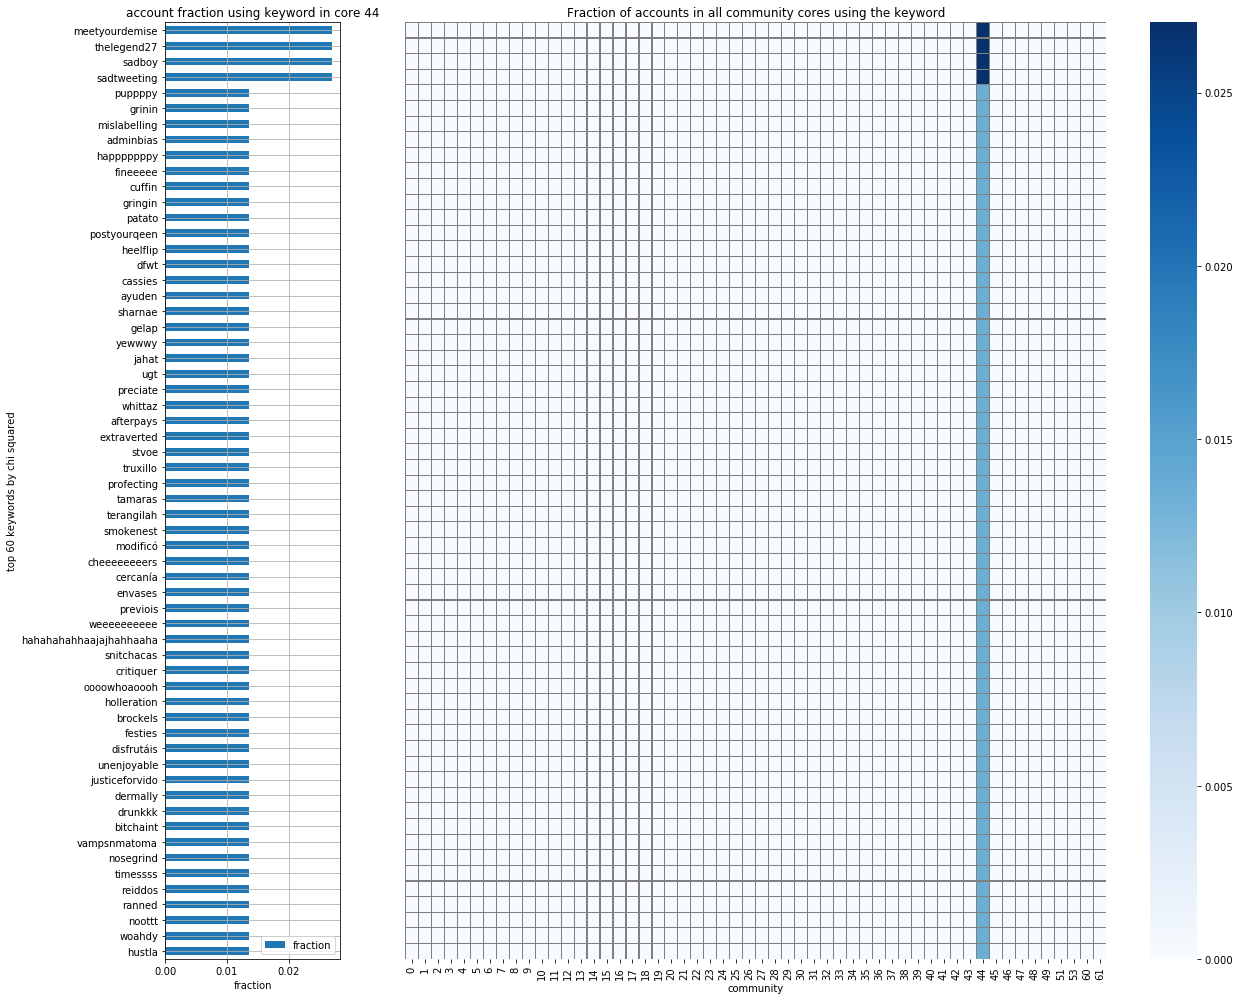



COMMUNITY 45
 n = 465


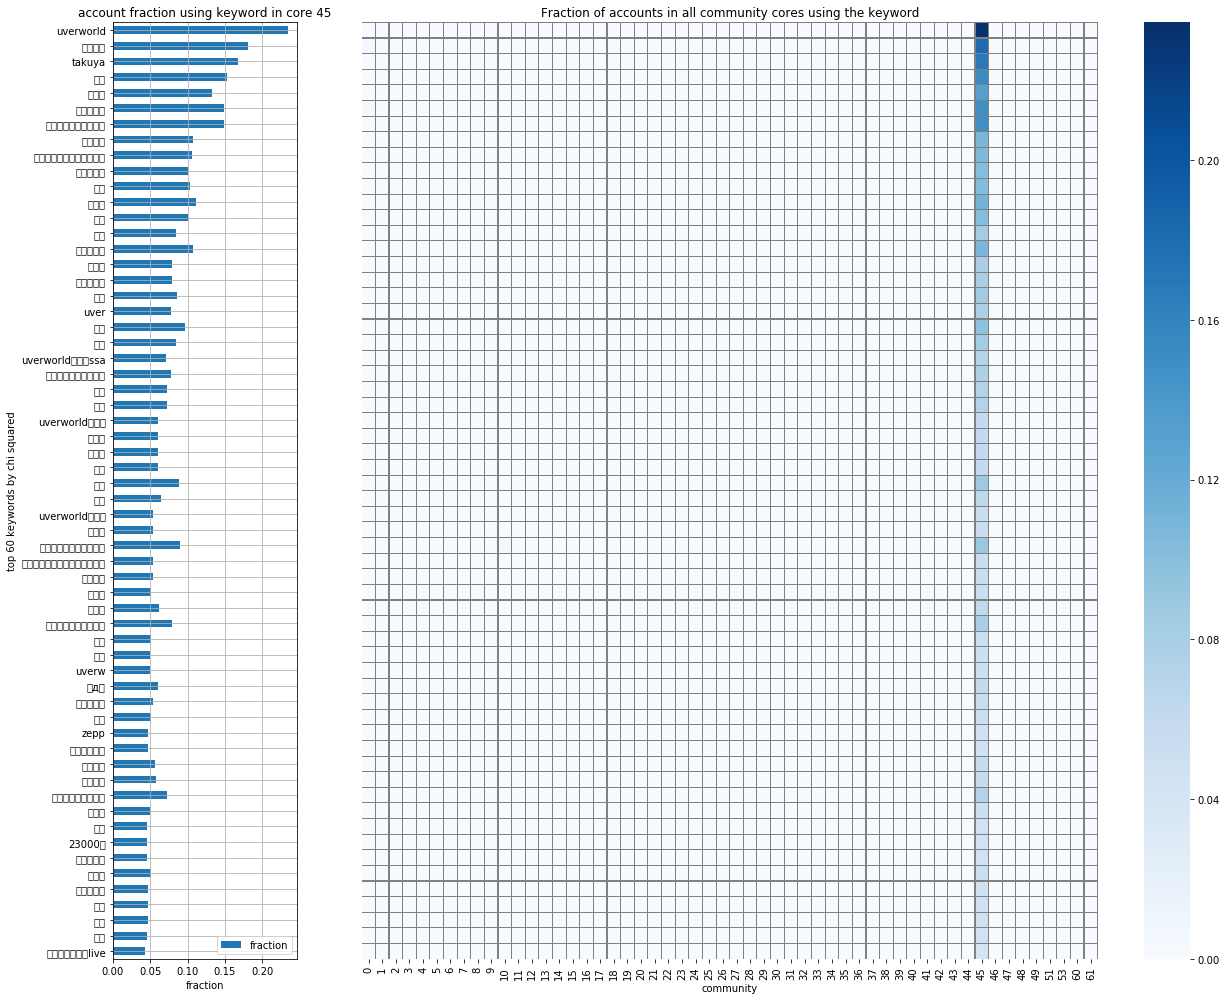



COMMUNITY 46
 n = 703


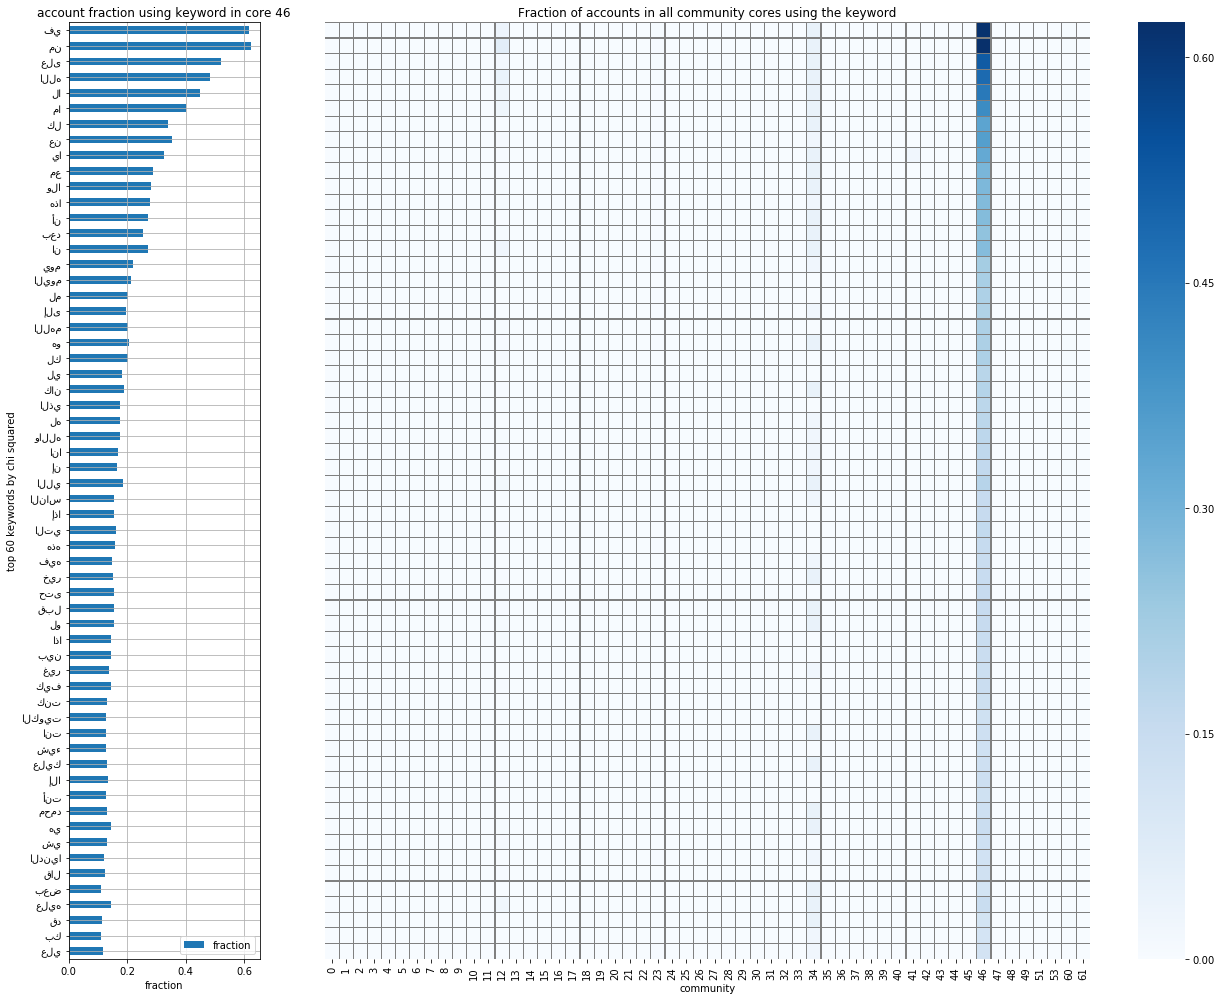



COMMUNITY 47
 n = 444


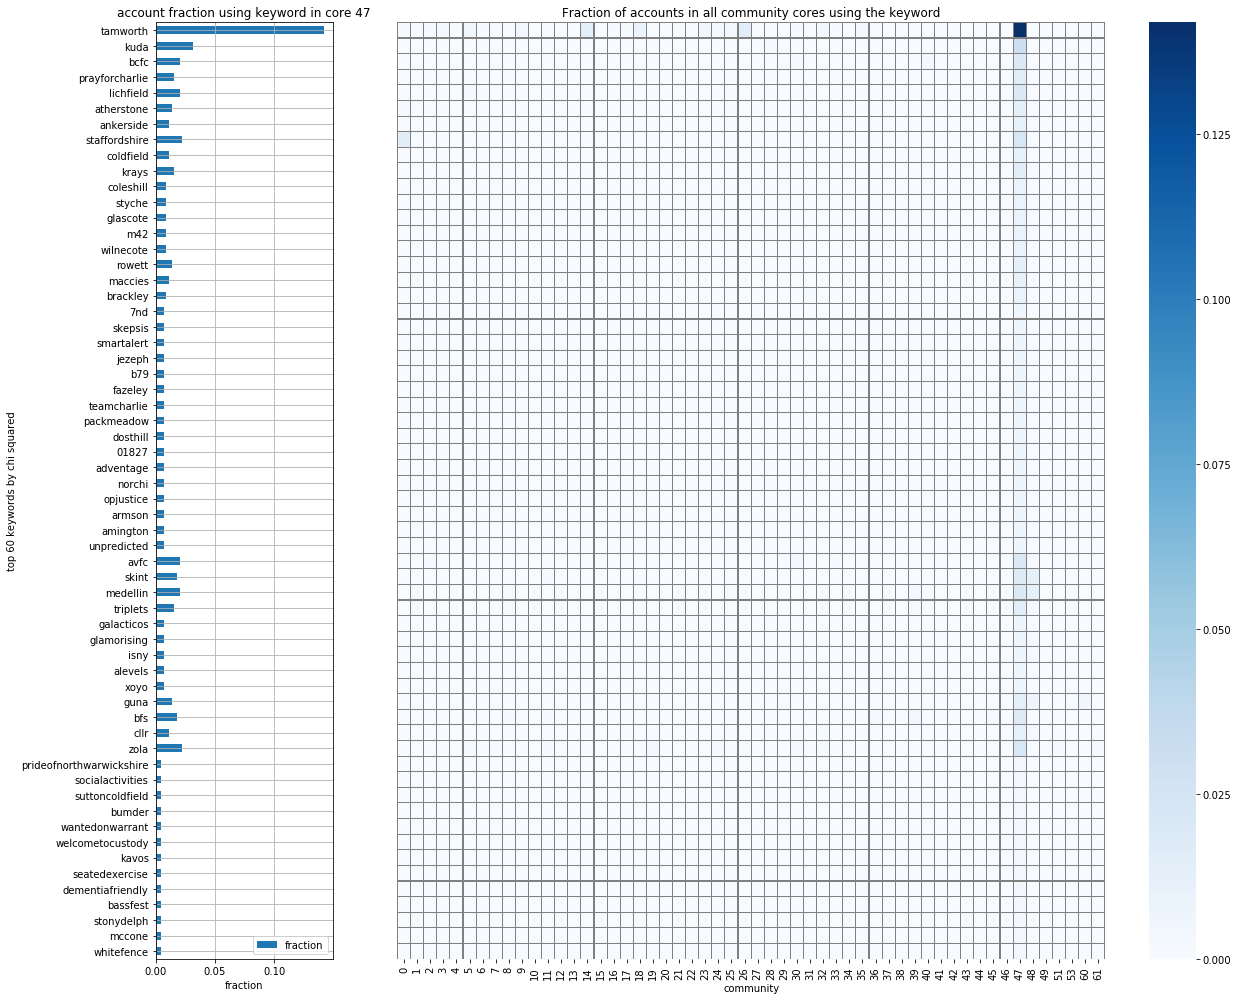



COMMUNITY 48
 n = 482


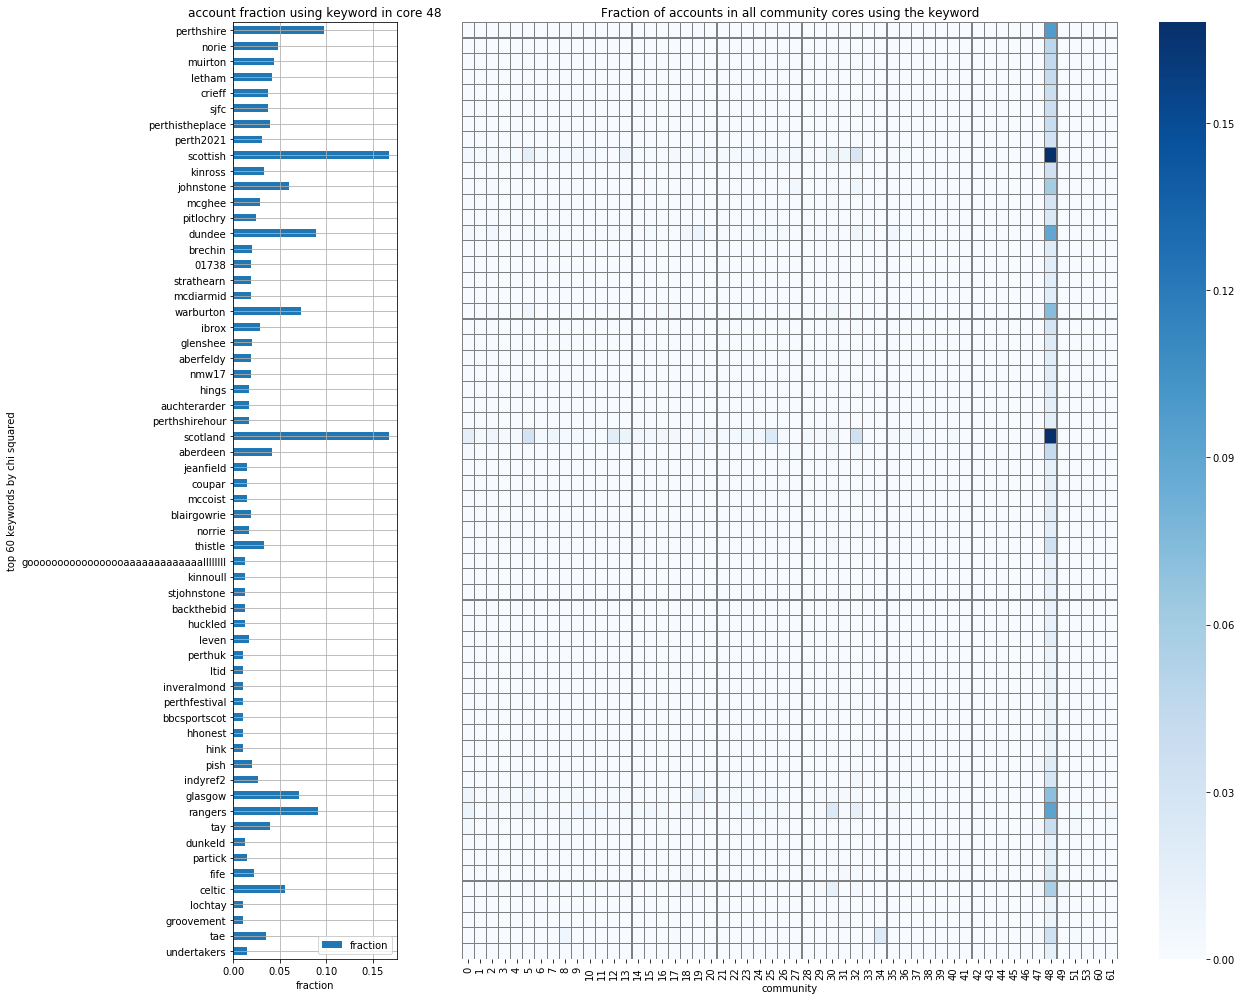



COMMUNITY 49
 n = 380


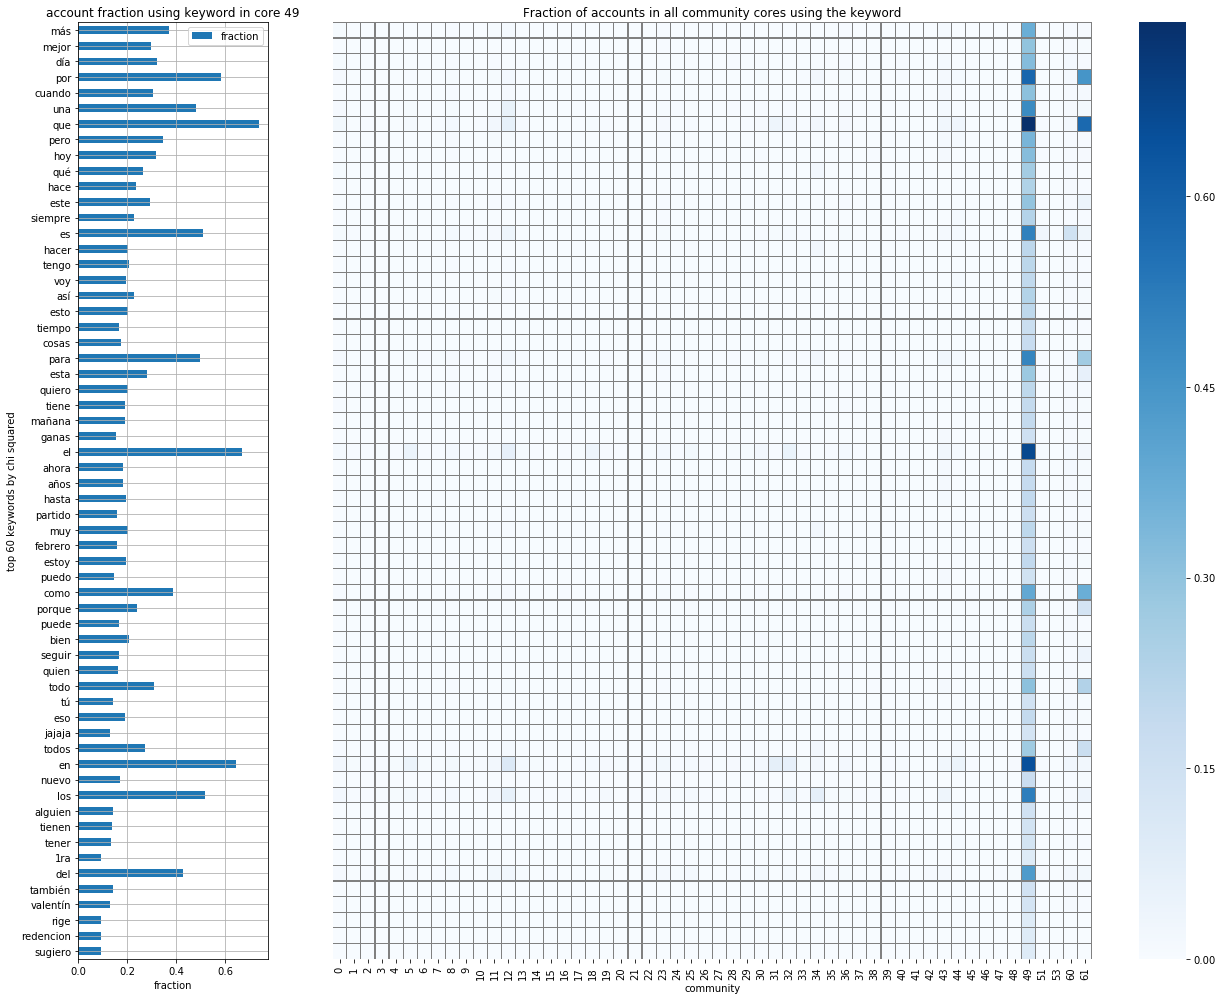



COMMUNITY 51
 n = 674


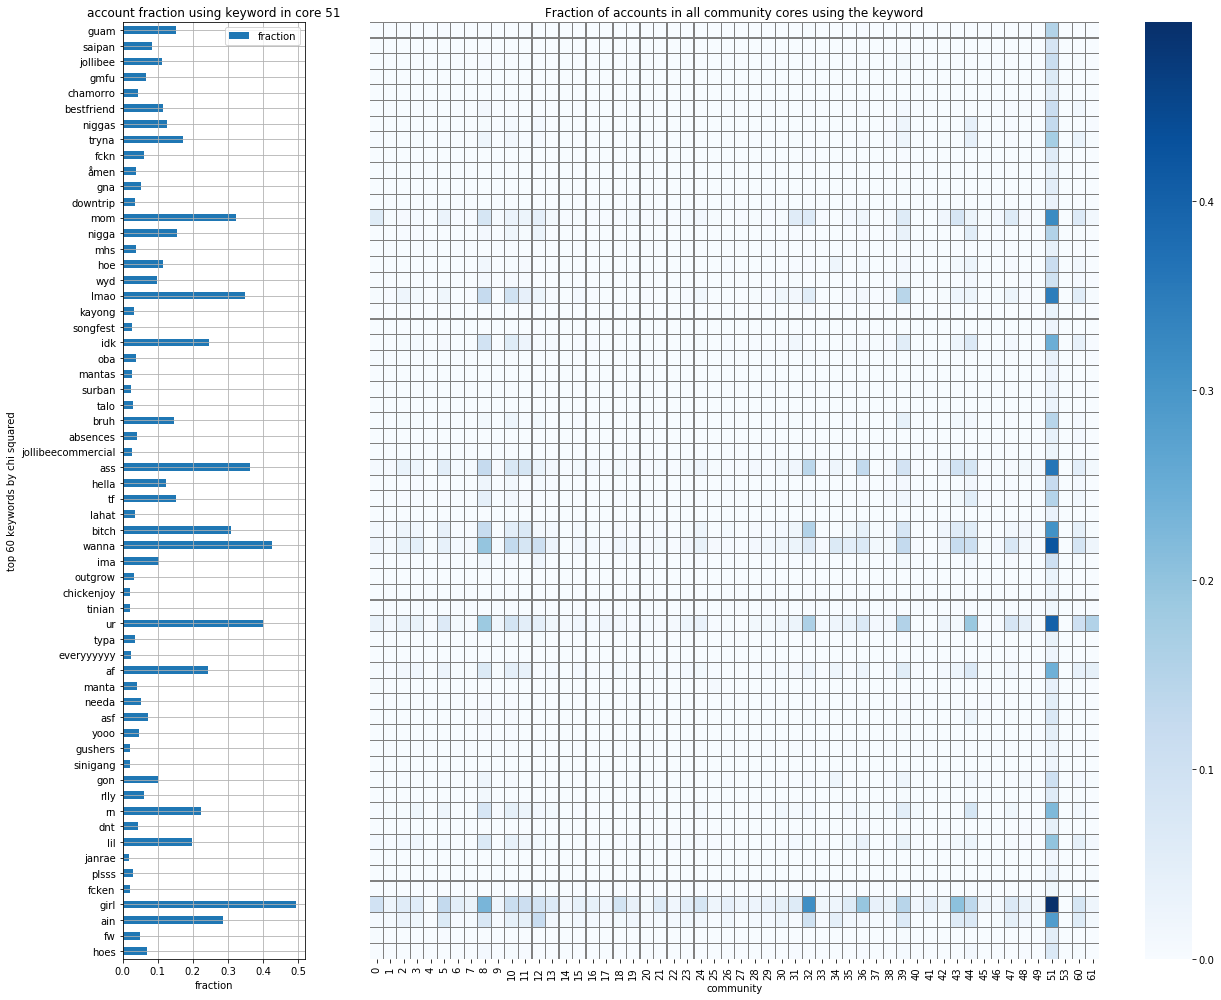



COMMUNITY 53
 n = 18


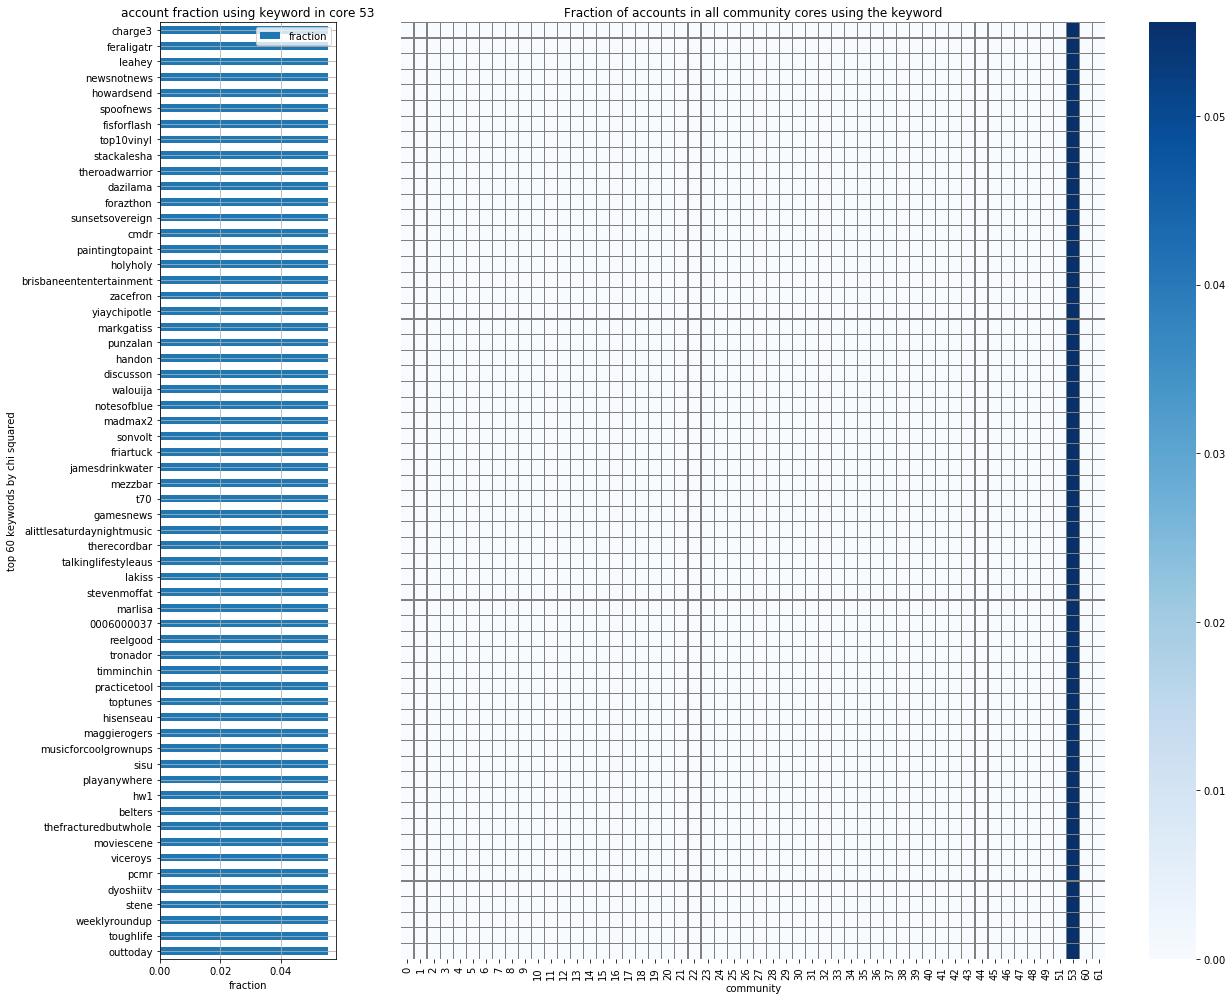



COMMUNITY 60
 n = 185


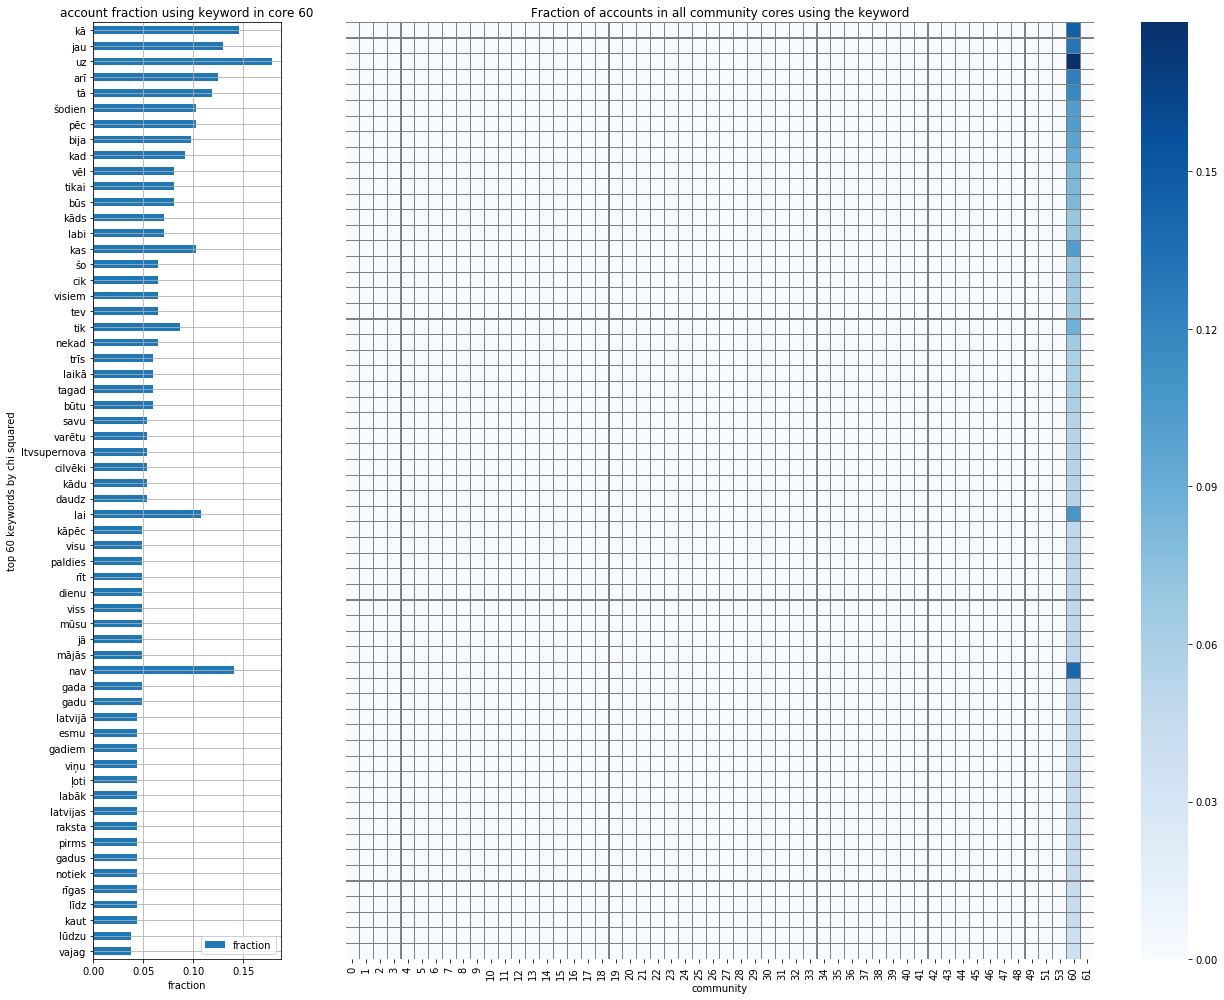



COMMUNITY 61
 n = 518


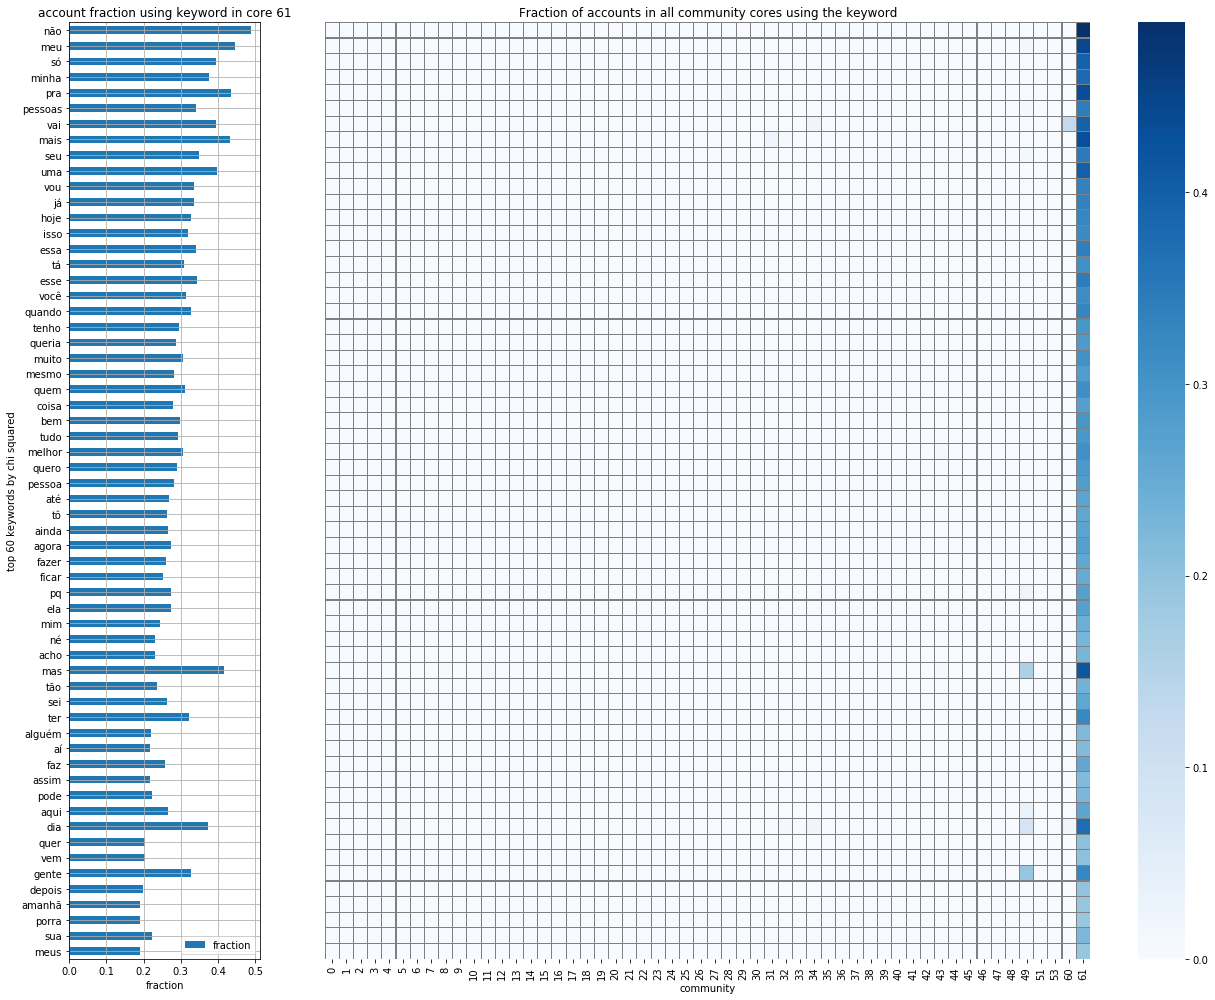

keywords
modularity_class                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     taiji, captivity, adoptdontshop, animalcruelty, animalrights, dolphins, seaworld, animal, dolphin, pets, usda, rspca, cruelty, animals, dogs, adoption, fur
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               startup, startups, marketing, tech, business, ai, digital, innovation, customer, data, strategy, customers, technology, companies, growth, tips, product, businesses, mobile, management, success
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       nrl, nrlallstars, rugby, broncos, charityshield, knights, foran, trial, dragons, league, tigers, manly, vickerman, sharks, jersey, players, season, footy
3                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  album, music, band, tour, songs, help, tune, song, game, great
4                                                                                                                                                                                                                                                                                                            

In [272]:
keyword_table, tdms = get_keywords(term_document_matrix=binary_term_document_matrix, vocabulary=binary_vocabulary,
                                   community_vector=community_vector, figsize=(18,14), top=60, test=False,
                                   treshold=0.05)

In [276]:
# save results to file

for key in tdms.keys():
    tdms[key].to_pickle('../../data/aus_to_aus/community_cores_10_percent_PLM_2.0/tweets/2017021/tdms_{key}_top60.pickle'.format(key=key))

In [274]:
keyword_table.to_pickle('../../data/aus_to_aus/community_cores_10_percent_PLM_2.0/tweets/2017021/keyword_table_top60_treshold5percent.pickle')

In [279]:
keyword_table.to_csv('../../data/aus_to_aus/community_cores_10_percent_PLM_2.0/tweets/2017021/keyword_table_top60_treshold5percent.csv')